In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
data_dir = '/content/drive/MyDrive/DL/traffic_Data/DATA'
import pandas as pd
labels_df = pd.read_csv('/content/drive/MyDrive/DL/labels.csv')

In [15]:
from keras.applications import Xception
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [24]:
images = []
labels = []

In [25]:
for class_folder in os.listdir(data_dir):
    class_id = int(class_folder)
    class_path = os.path.join(data_dir, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize images to a common size
        images.append(img)
        class_name = labels_df.loc[labels_df['ClassId'] == class_id, 'Name'].iloc[0]
        labels.append(class_name)

In [26]:
resized_images = []
for img in images:
    resized_img = cv2.resize(img, (224, 224))
    resized_images.append(resized_img)

In [28]:
images = np.array(resized_images)
labels = np.array(labels)

In [29]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
max_count = np.max(label_counts)

In [32]:
print(images.shape, labels.shape)

(4173, 224, 224, 3) (4173,)


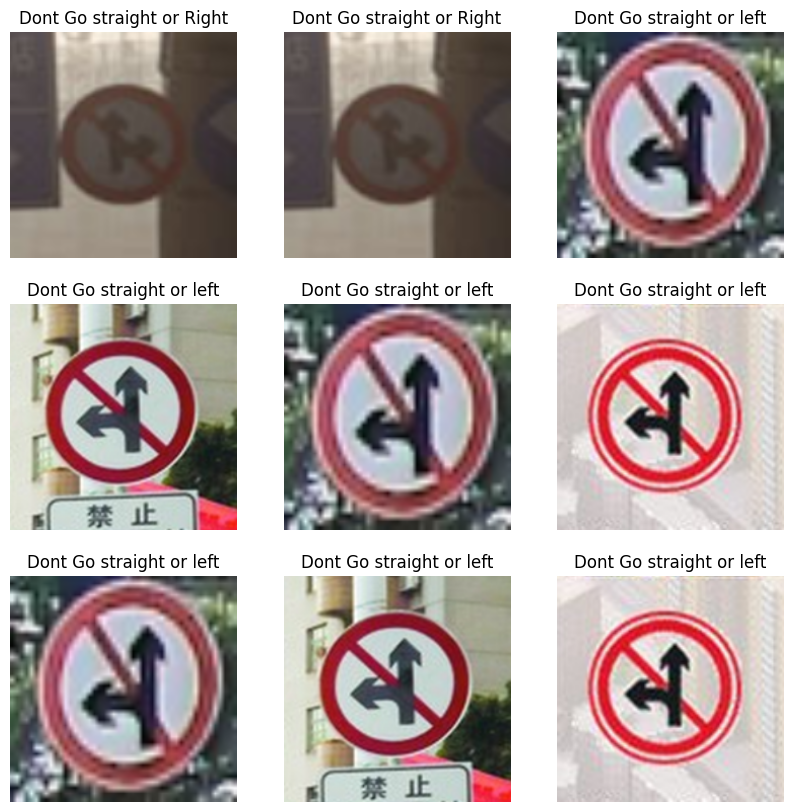

In [33]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

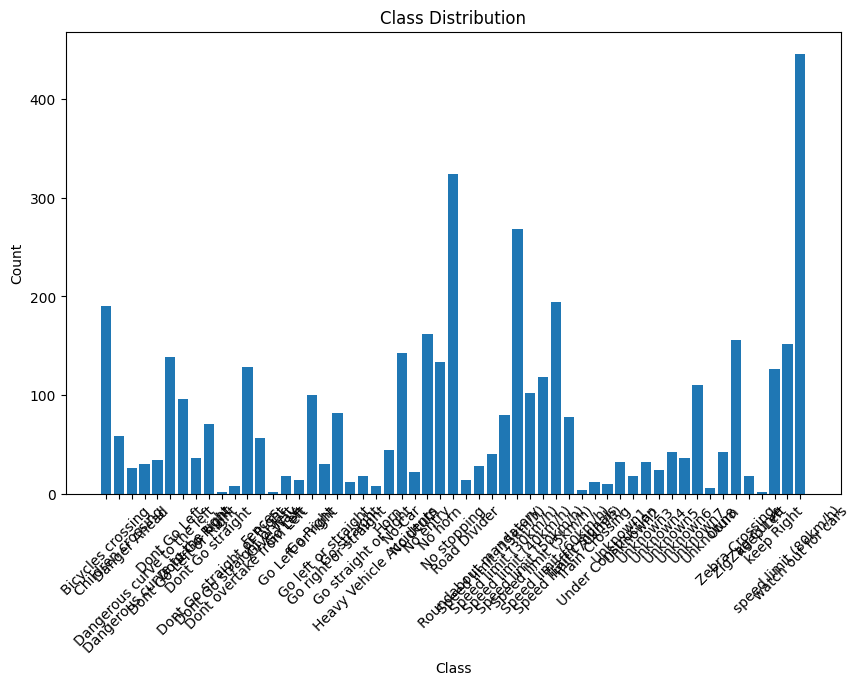

In [34]:

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [36]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

83683744/83683744 [==============================] - 1s 0us/step


In [37]:
for layer in base_model.layers:
    layer.trainable = False

In [38]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(len(unique_labels), activation='softmax')(x)
xception_model = Model(inputs=base_model.input, outputs=output)
xception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [39]:
checkpoint_path = "xception_model_weights.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='min',
                                      save_freq='epoch')

In [40]:
X_resized = np.array(resized_images)
X_train_resized, X_test_resized, y_train, y_test = train_test_split(X_resized, labels, test_size=0.2, random_state=42)

In [41]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [42]:
history = xception_model.fit(X_train_resized, y_train_encoded,
                             epochs=10,
                             batch_size=32,
                             validation_data=(X_test_resized, y_test_encoded),
                             callbacks=[checkpoint_callback])

Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 5.1242 - accuracy: 0.3209
Epoch 1: val_loss improved from inf to 2.05701, saving model to xception_model_weights.h5
105/105 [==============================] - 938s 9s/step - loss: 5.1242 - accuracy: 0.3209 - val_loss: 2.0570 - val_accuracy: 0.4910
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 1.6944 - accuracy: 0.5806
Epoch 2: val_loss improved from 2.05701 to 1.55105, saving model to xception_model_weights.h5
105/105 [==============================] - 930s 9s/step - loss: 1.6944 - accuracy: 0.5806 - val_loss: 1.5511 - val_accuracy: 0.6299
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 1.1886 - accuracy: 0.6944
Epoch 3: val_loss improved from 1.55105 to 0.97378, saving model to xception_model_weights.h5
105/105 [==============================] - 924s 9s/step - loss: 1.1886 - accuracy: 0.6944 - val_loss: 0.9738 - val_accuracy: 0.7377
Epoch 4/10
105/105 [==================

In [43]:
test_loss, test_acc = xception_model.evaluate(X_test_resized, y_test_encoded)
print("Test Accuracy:", test_acc)

27/27 [==============================] - 181s 7s/step - loss: 0.3930 - accuracy: 0.8934
Test Accuracy: 0.8934131860733032


In [44]:
layer_outputs = [layer.output for layer in xception_model.layers]
activation_model = Model(inputs=xception_model.input, outputs=layer_outputs)
sample_image = X_train_resized[0:1]
activations = activation_model.predict(sample_image)

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 4s 4s/step
input_1 (1, 224, 224, 3)


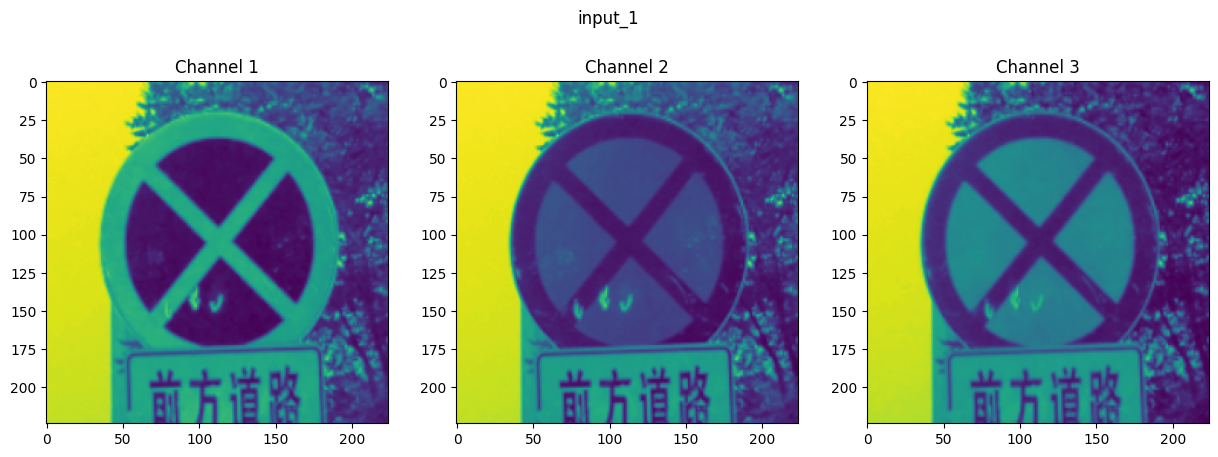

block1_conv1 (1, 111, 111, 32)


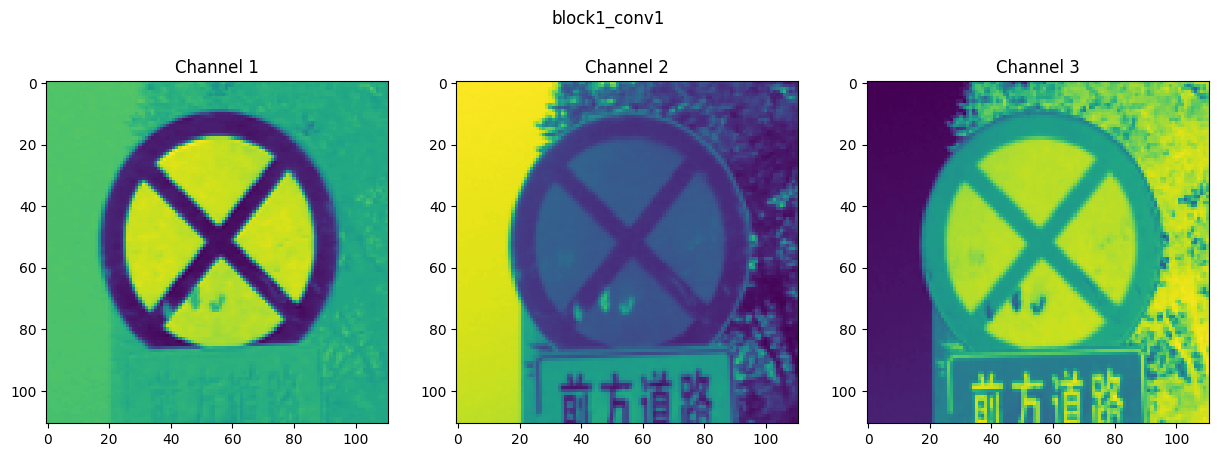

block1_conv1_bn (1, 111, 111, 32)


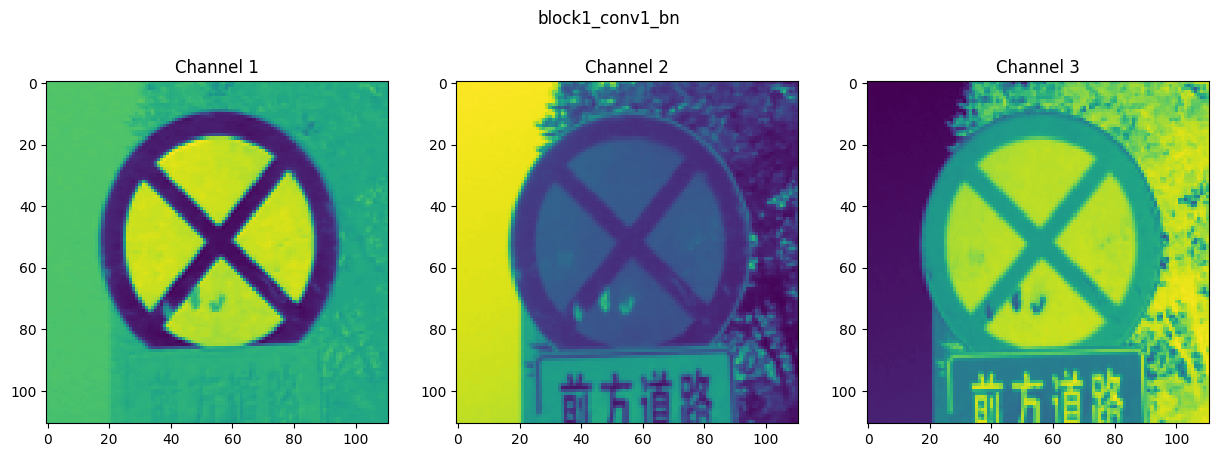

block1_conv1_act (1, 111, 111, 32)


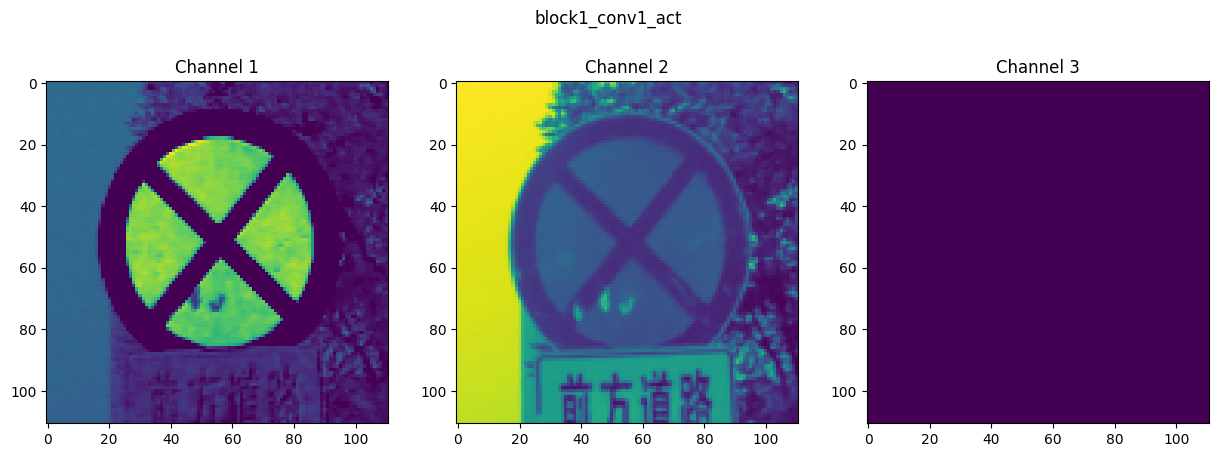

block1_conv2 (1, 109, 109, 64)


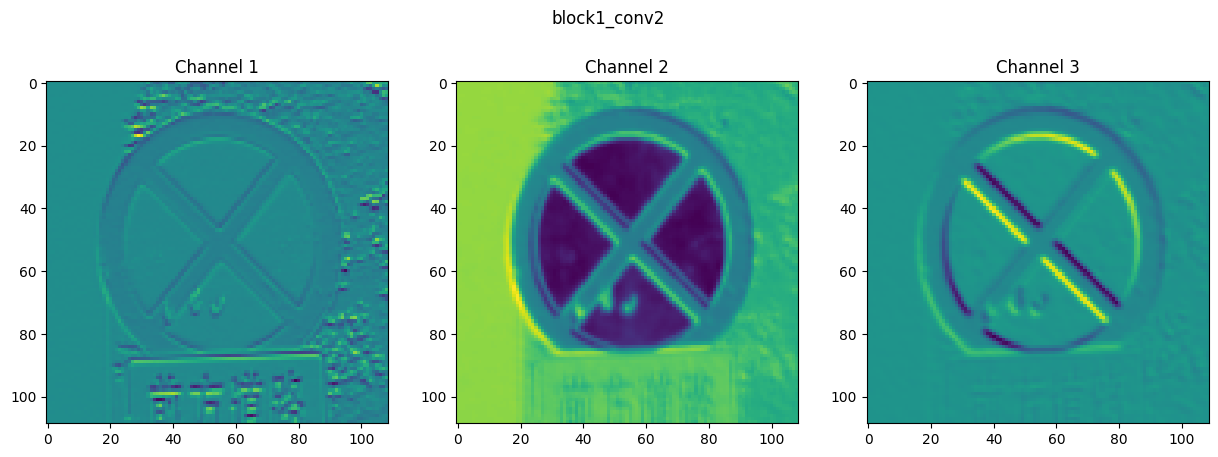

block1_conv2_bn (1, 109, 109, 64)


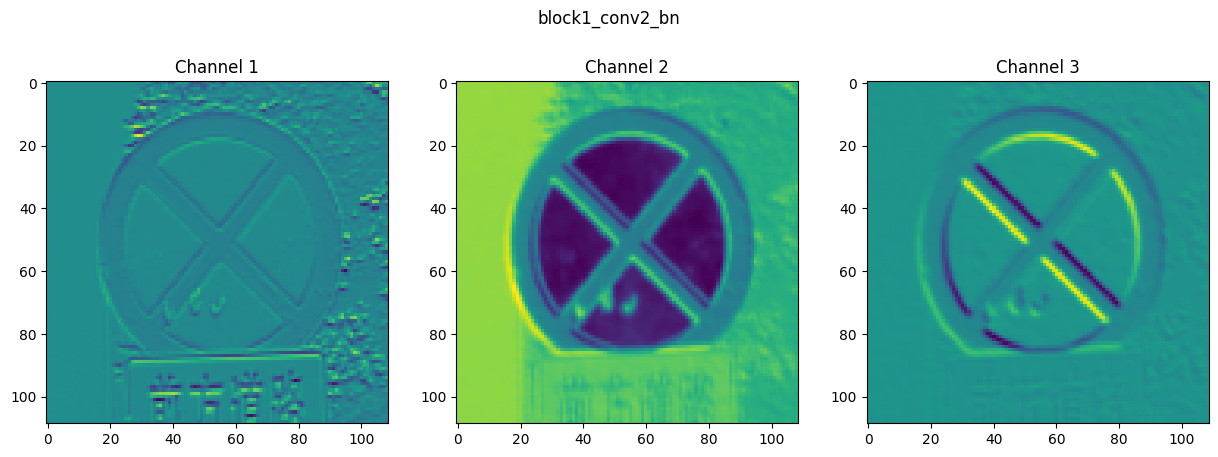

block1_conv2_act (1, 109, 109, 64)


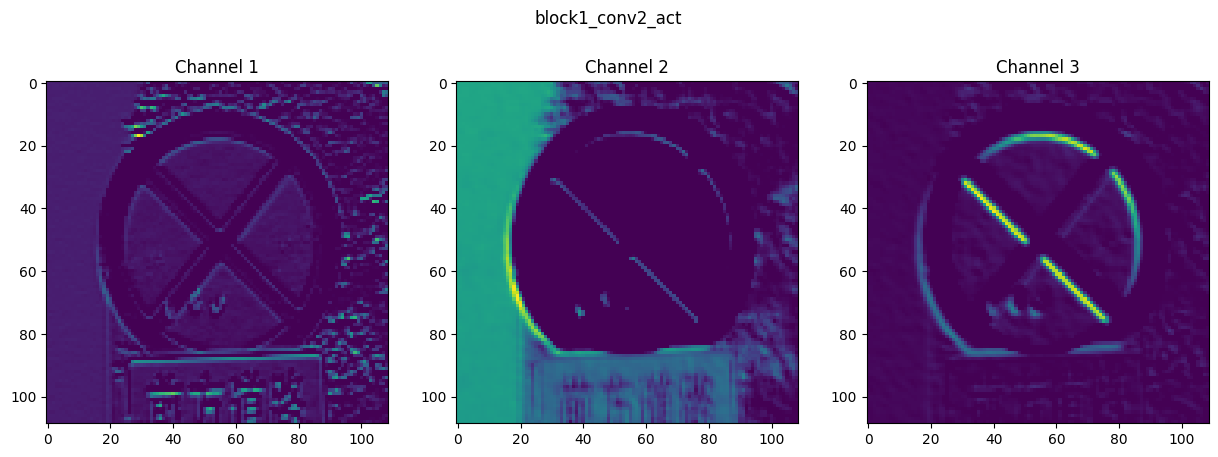

block2_sepconv1 (1, 109, 109, 128)


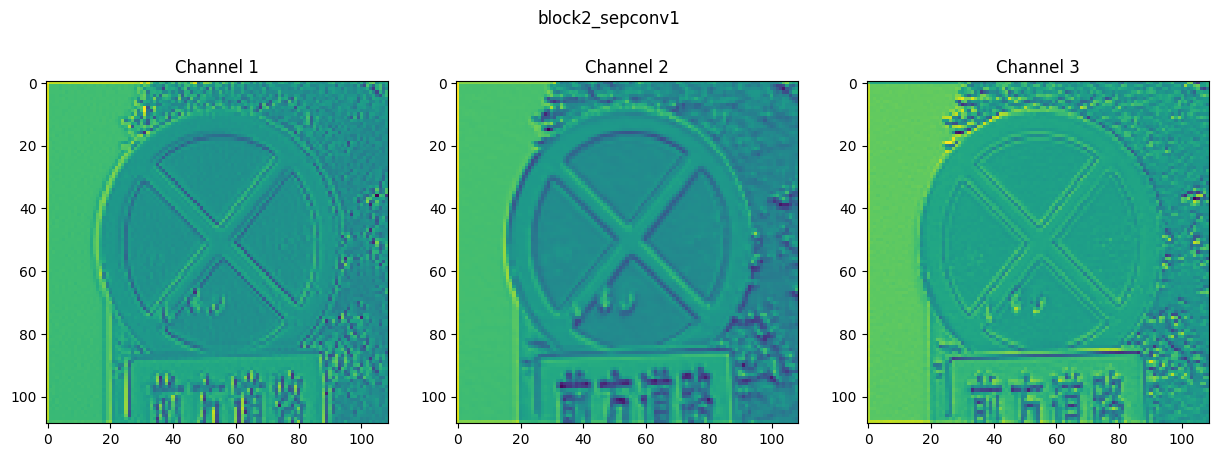

block2_sepconv1_bn (1, 109, 109, 128)


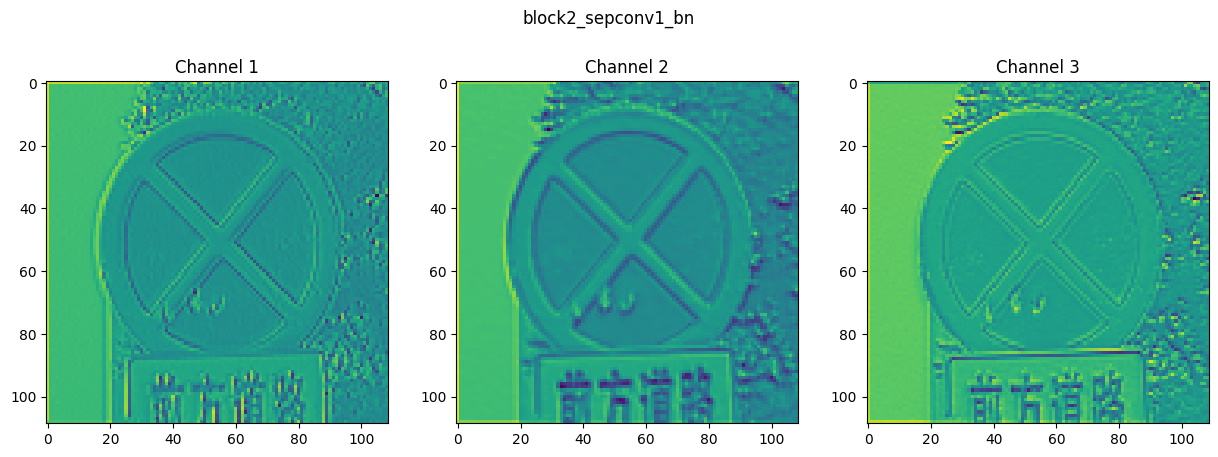

block2_sepconv2_act (1, 109, 109, 128)


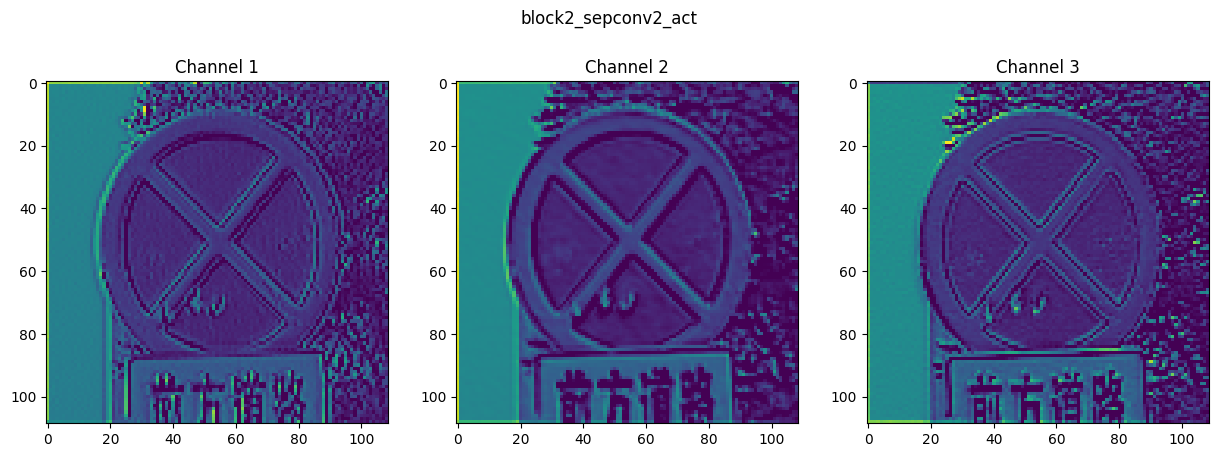

block2_sepconv2 (1, 109, 109, 128)


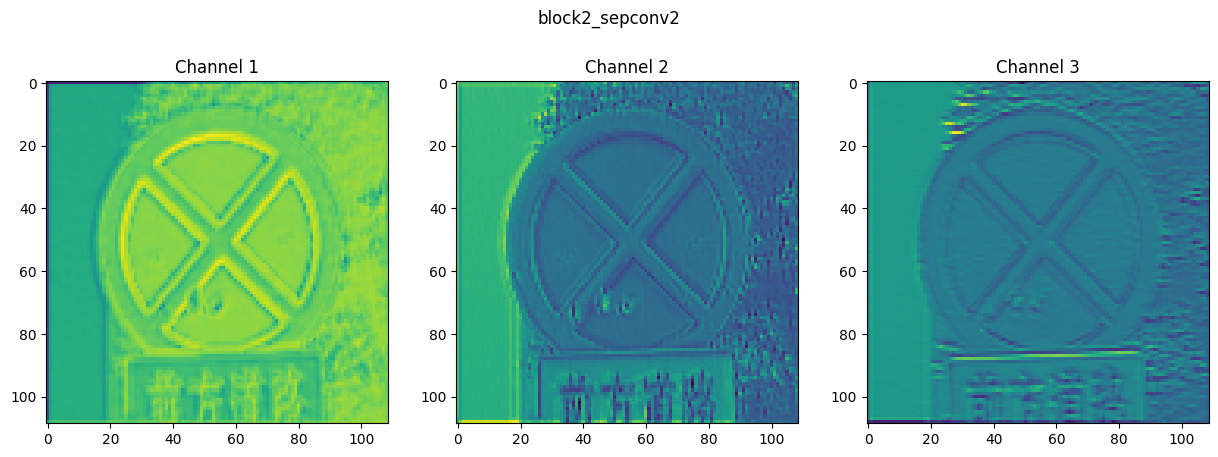

block2_sepconv2_bn (1, 109, 109, 128)


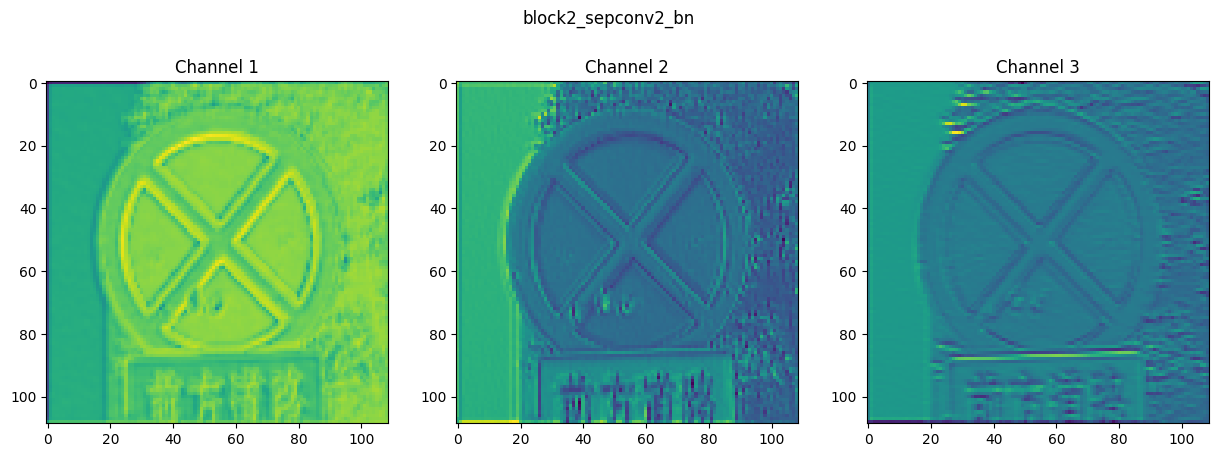

conv2d (1, 55, 55, 128)


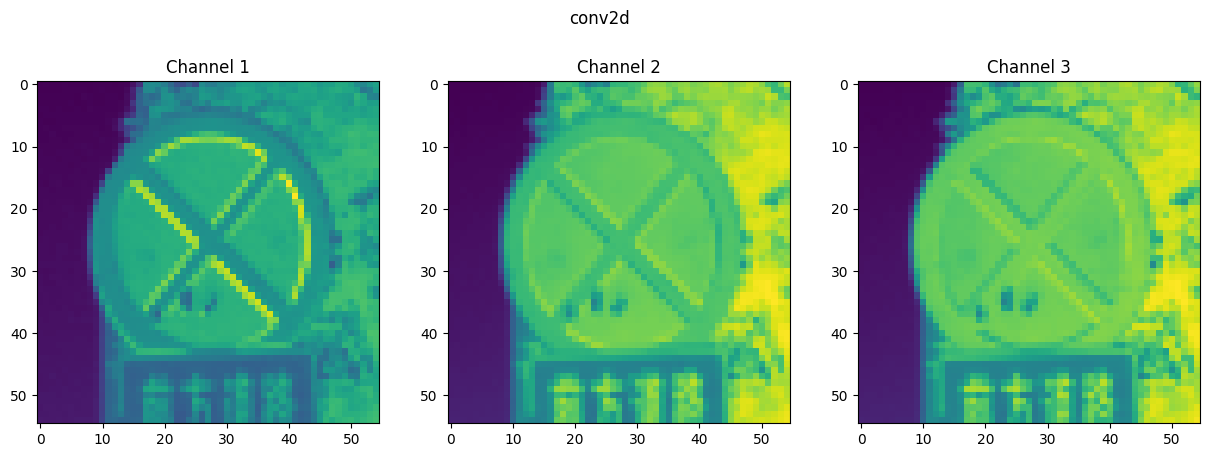

block2_pool (1, 55, 55, 128)


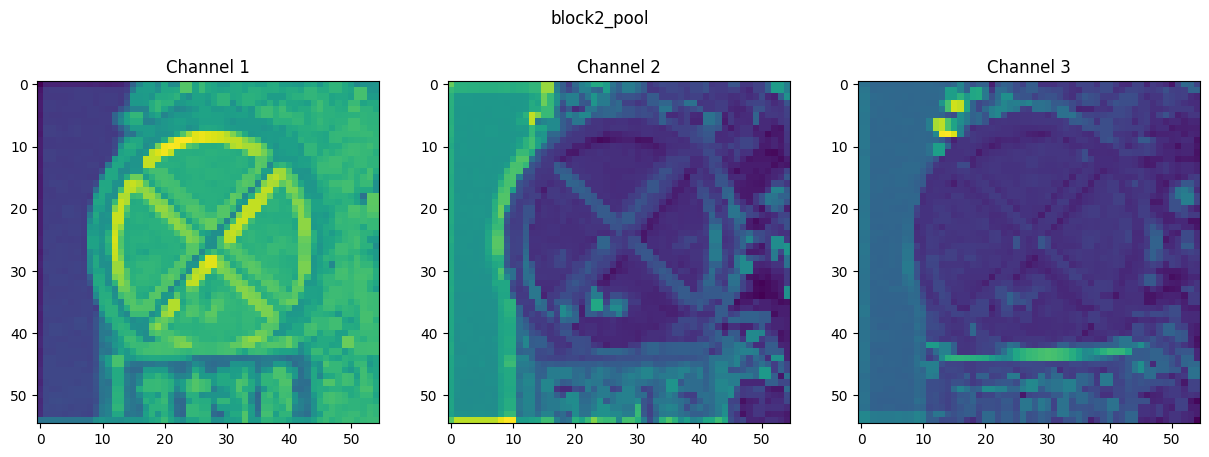

batch_normalization (1, 55, 55, 128)


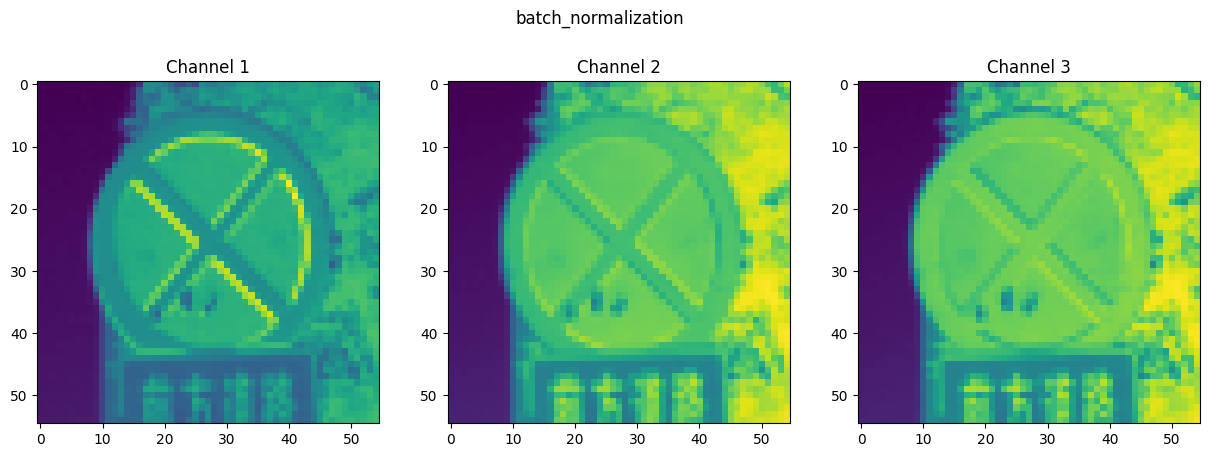

add (1, 55, 55, 128)


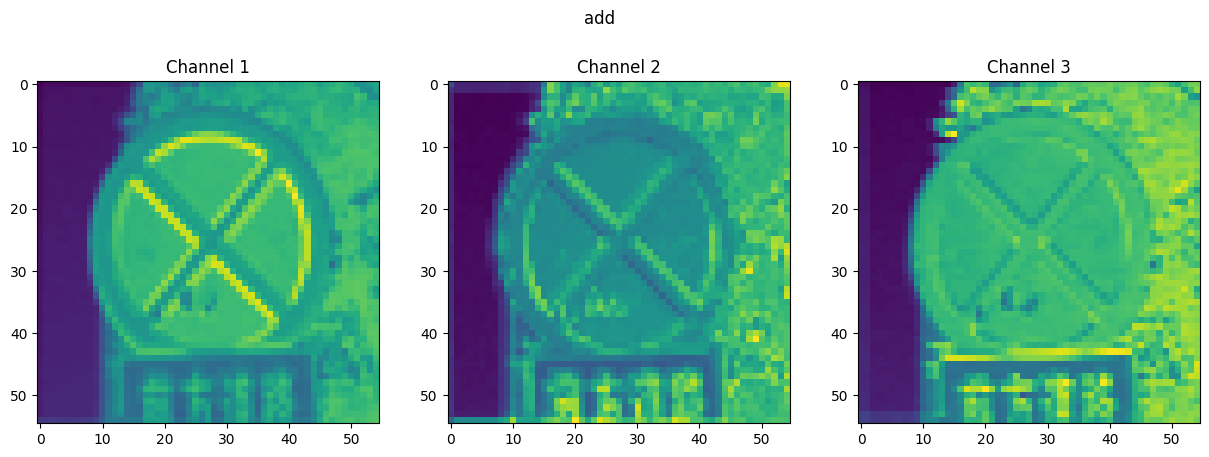

block3_sepconv1_act (1, 55, 55, 128)


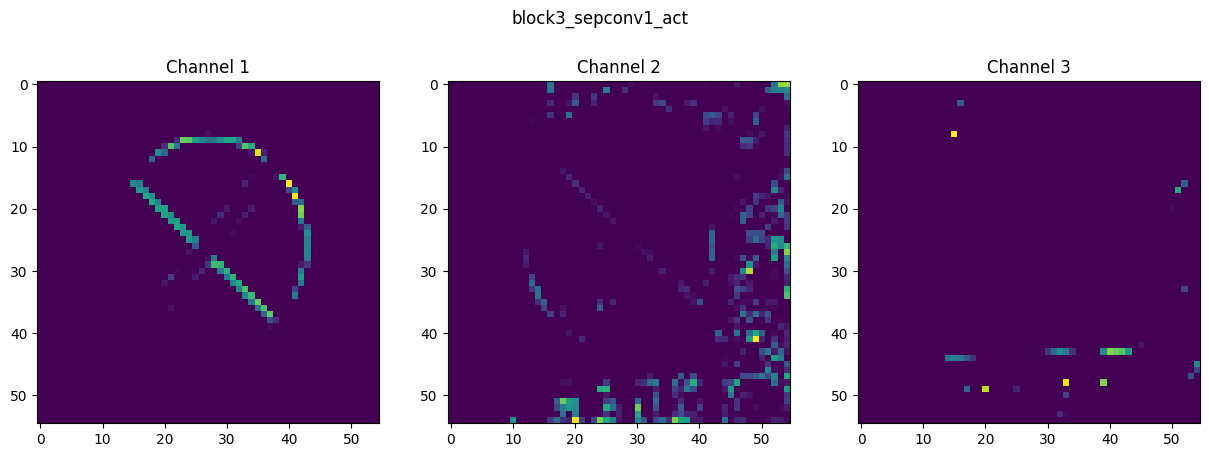

block3_sepconv1 (1, 55, 55, 256)


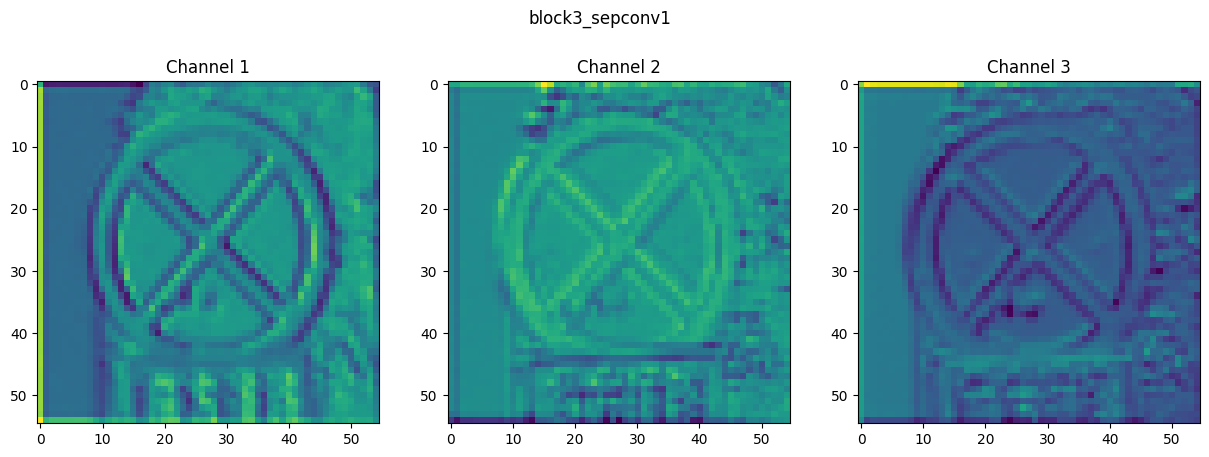

block3_sepconv1_bn (1, 55, 55, 256)


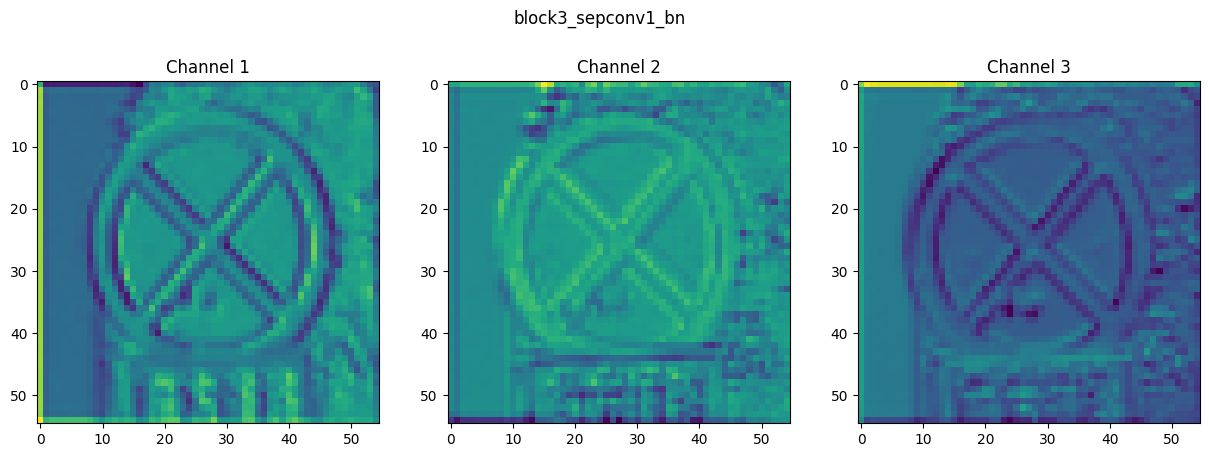

block3_sepconv2_act (1, 55, 55, 256)


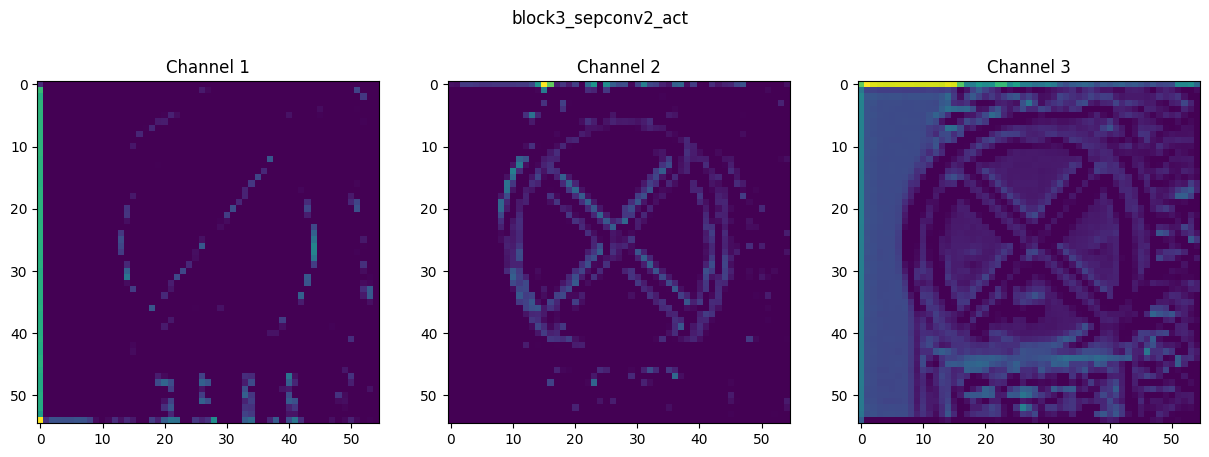

block3_sepconv2 (1, 55, 55, 256)


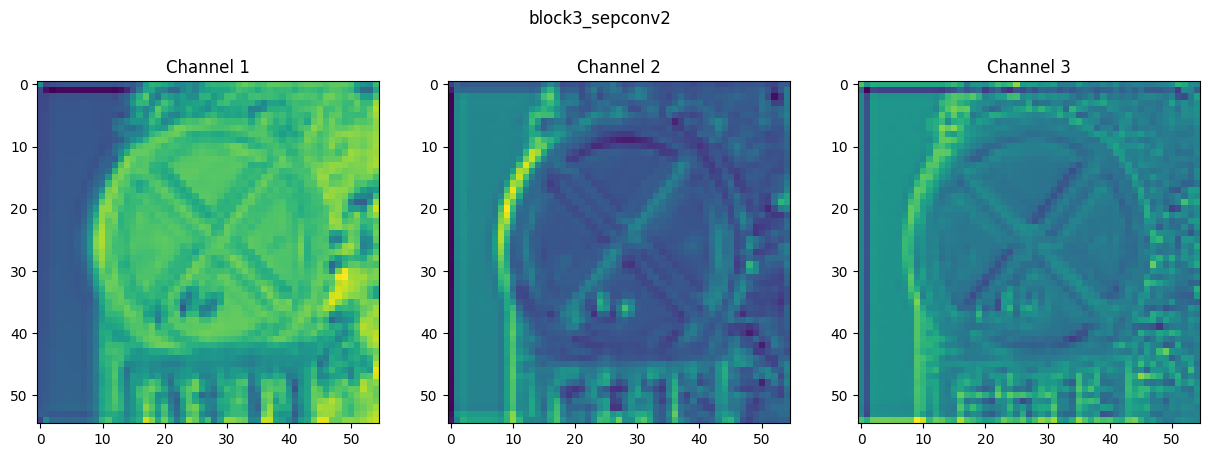

block3_sepconv2_bn (1, 55, 55, 256)


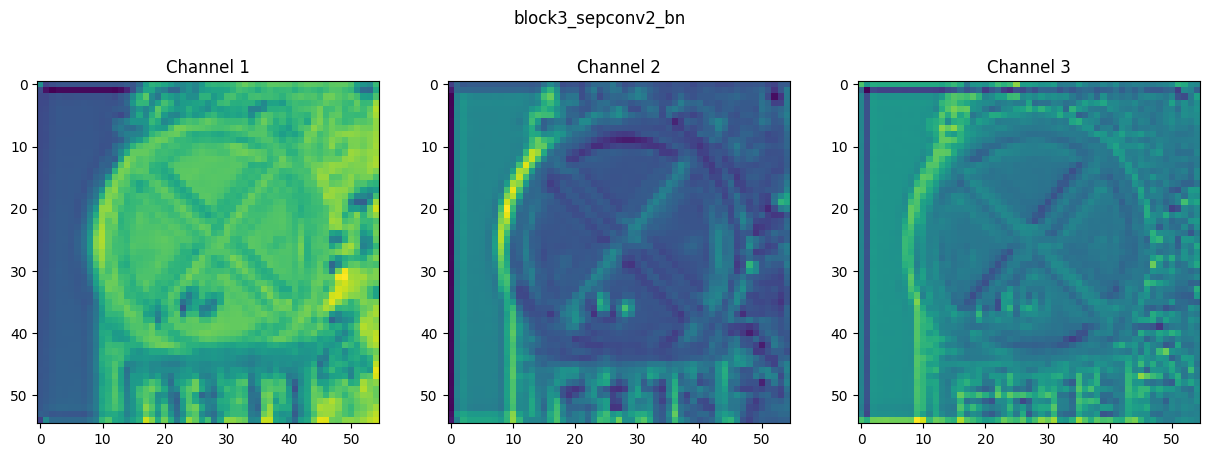

conv2d_1 (1, 28, 28, 256)


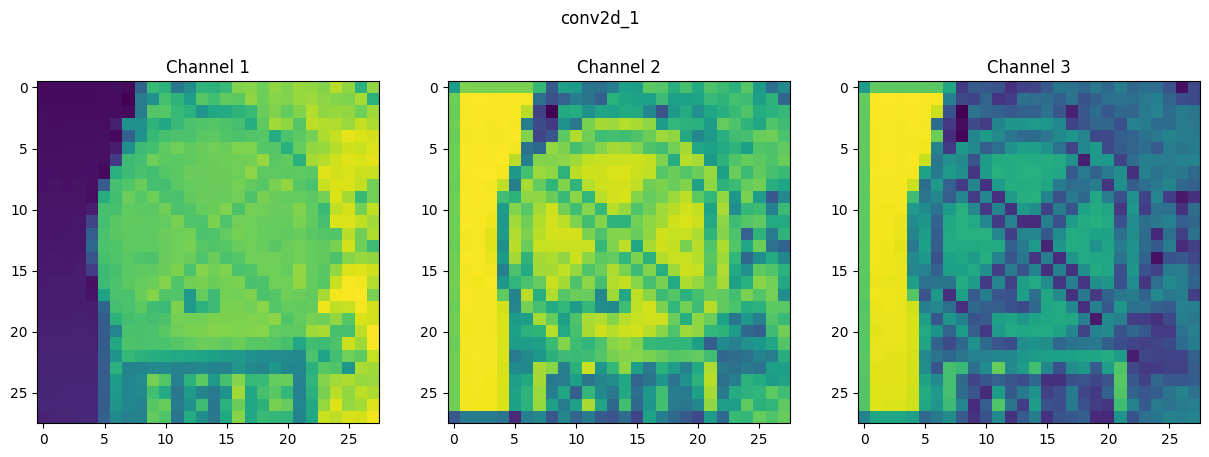

block3_pool (1, 28, 28, 256)


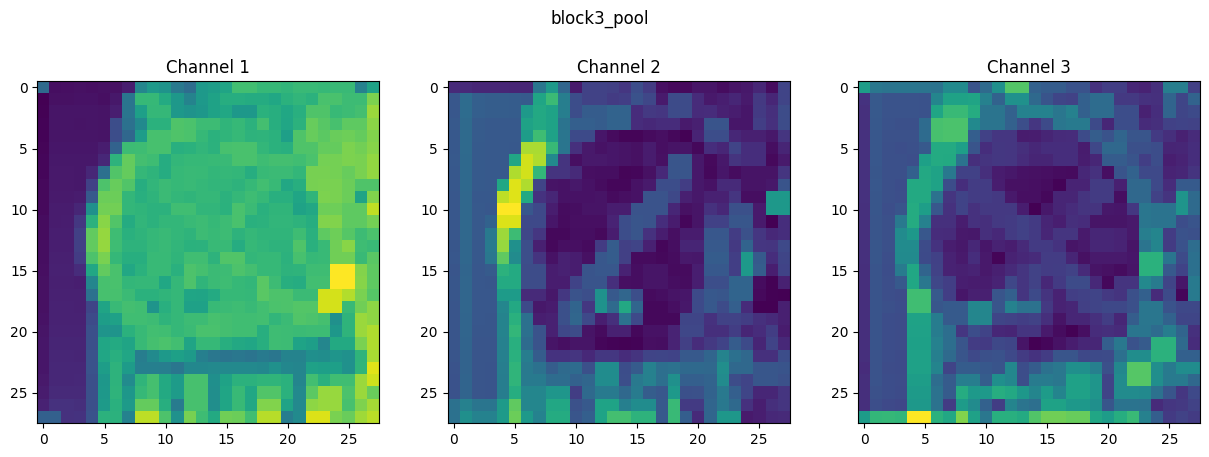

batch_normalization_1 (1, 28, 28, 256)


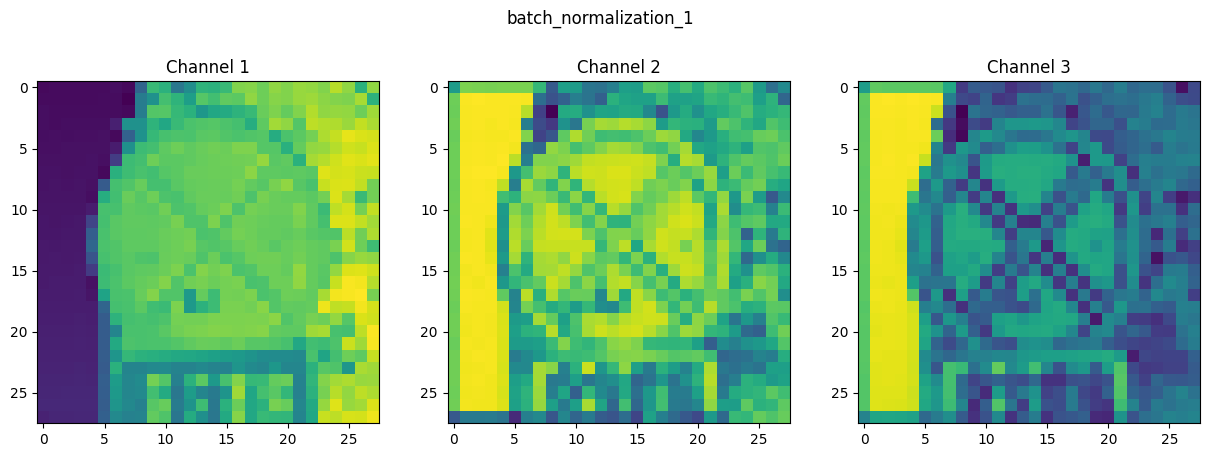

add_1 (1, 28, 28, 256)


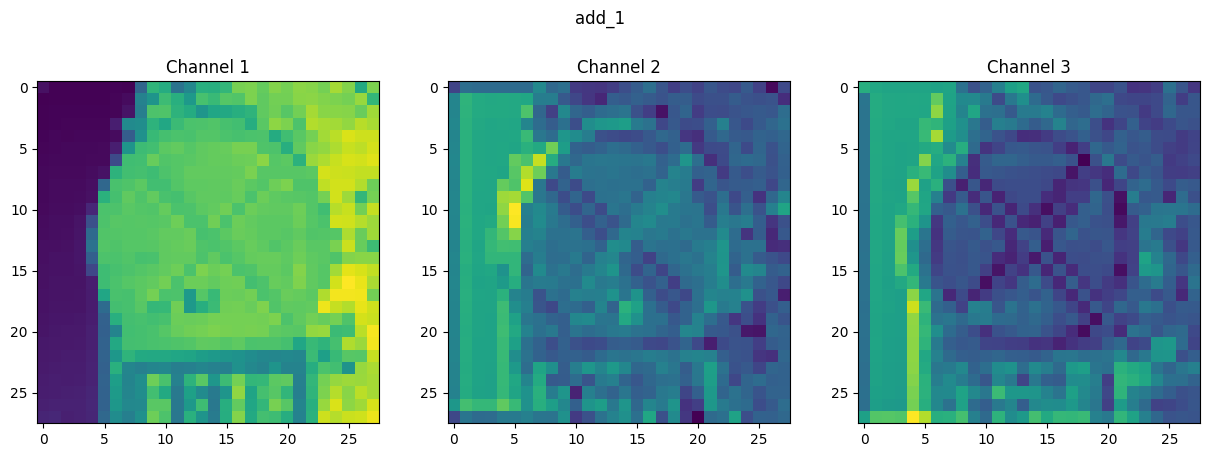

block4_sepconv1_act (1, 28, 28, 256)


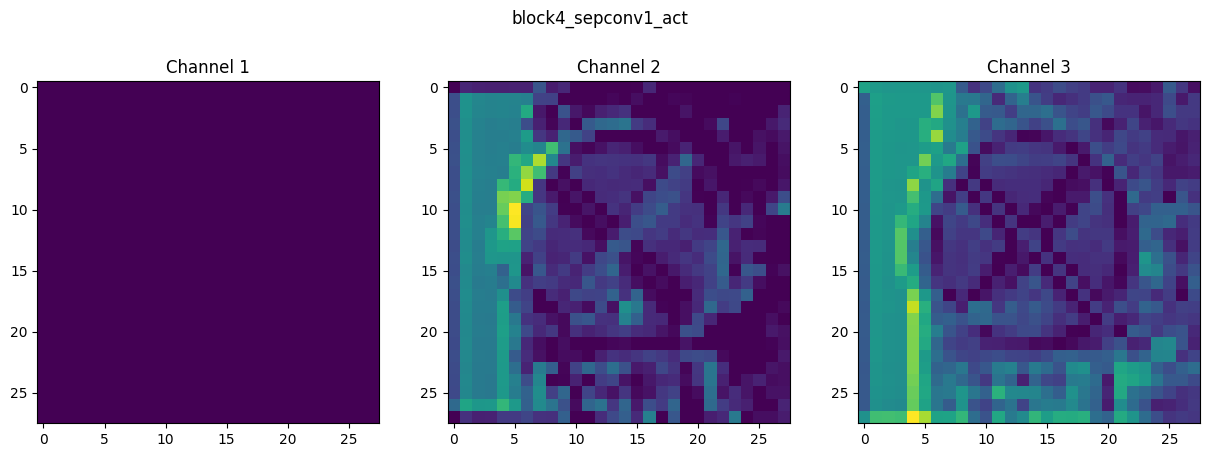

block4_sepconv1 (1, 28, 28, 728)


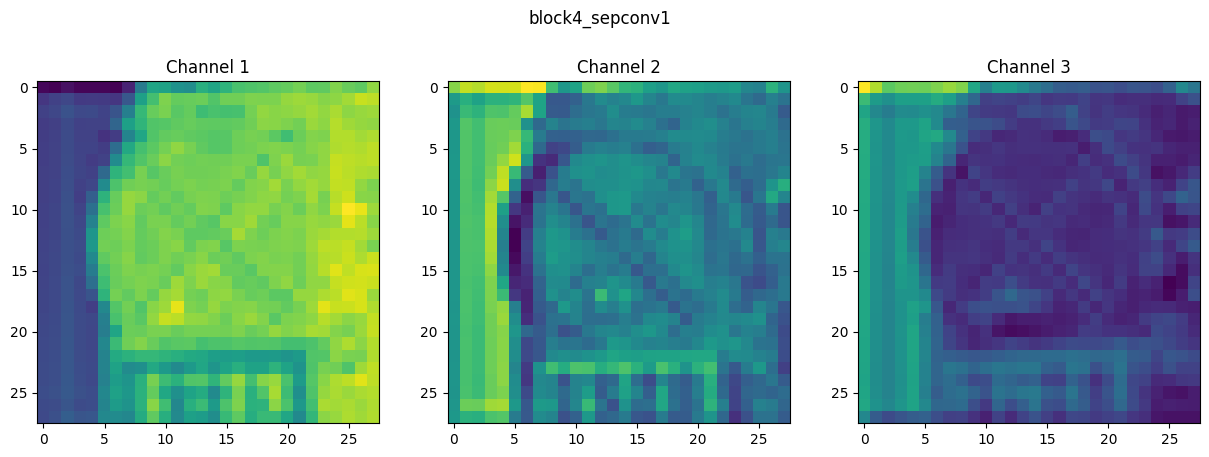

block4_sepconv1_bn (1, 28, 28, 728)


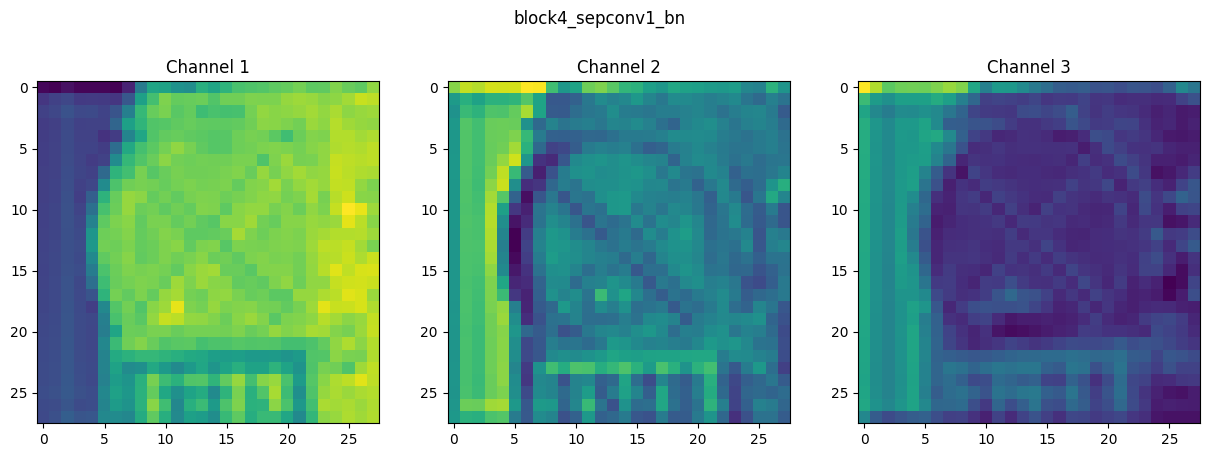

block4_sepconv2_act (1, 28, 28, 728)


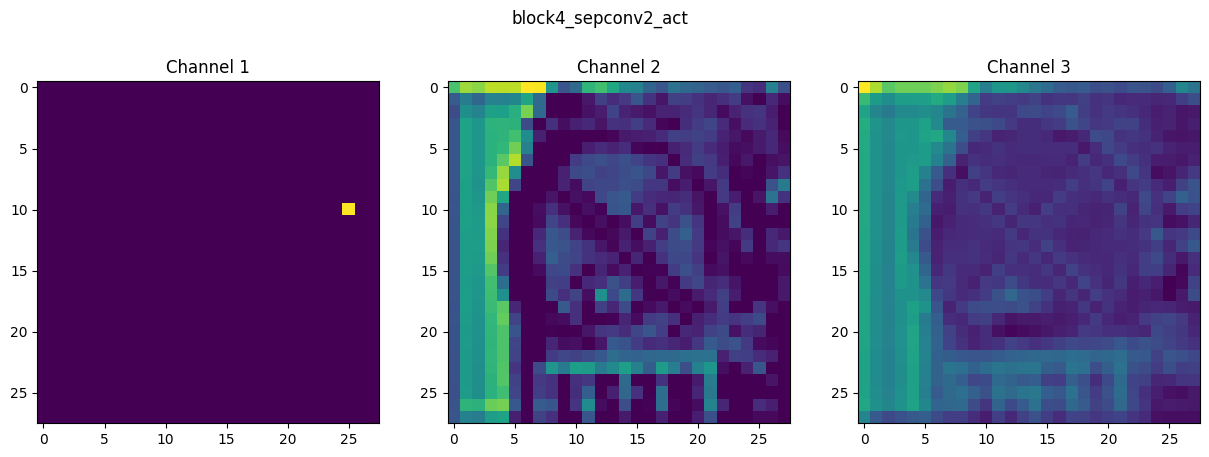

block4_sepconv2 (1, 28, 28, 728)


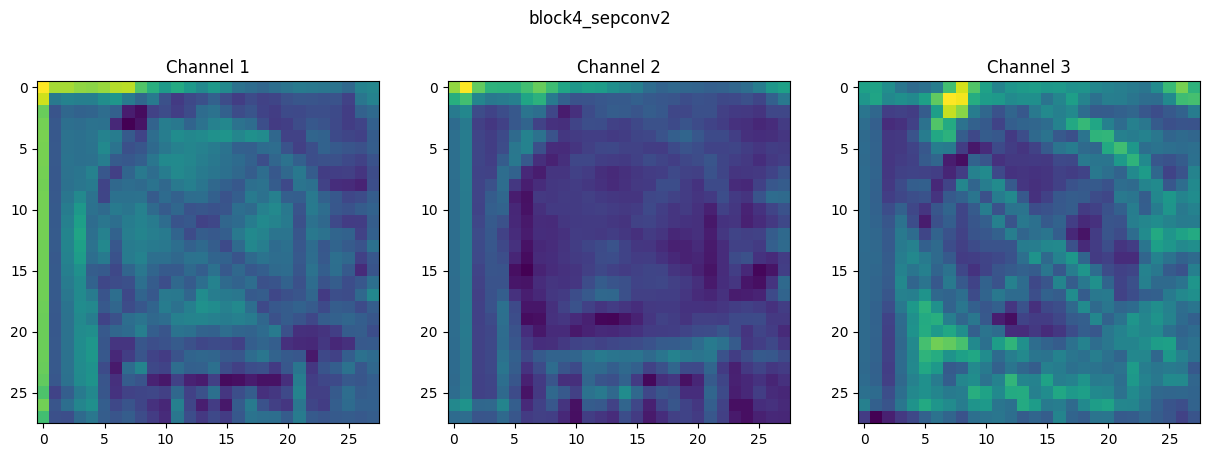

block4_sepconv2_bn (1, 28, 28, 728)


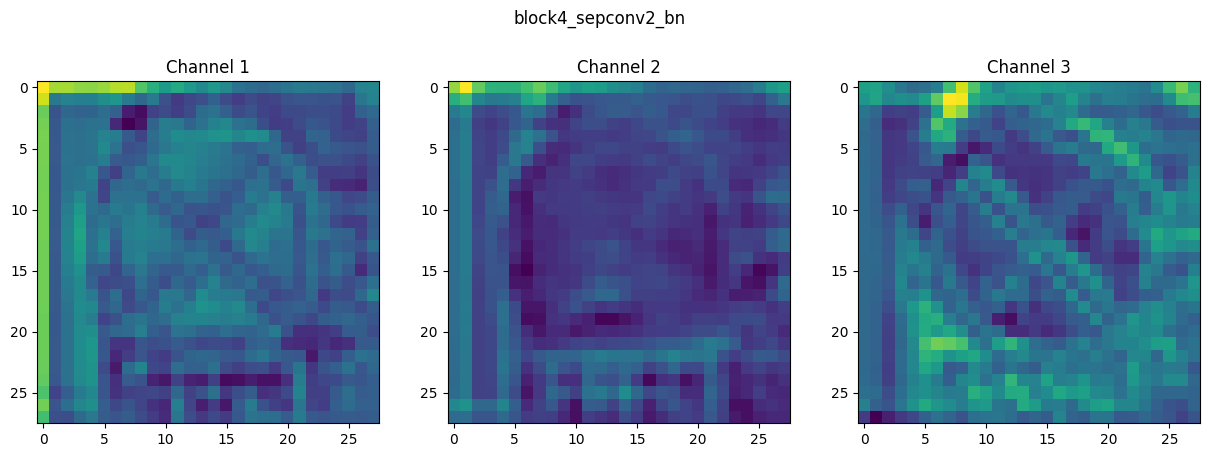

conv2d_2 (1, 14, 14, 728)


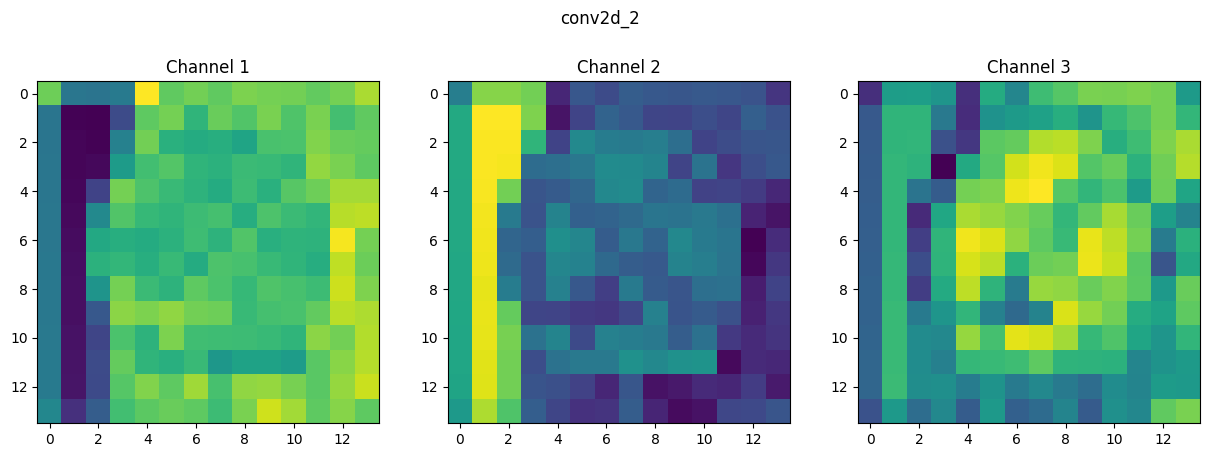

block4_pool (1, 14, 14, 728)


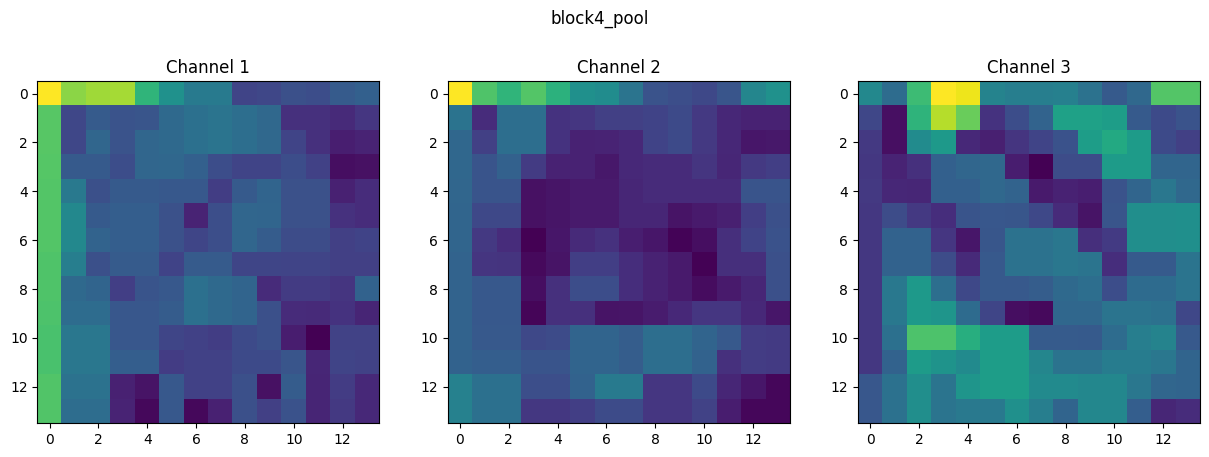

batch_normalization_2 (1, 14, 14, 728)


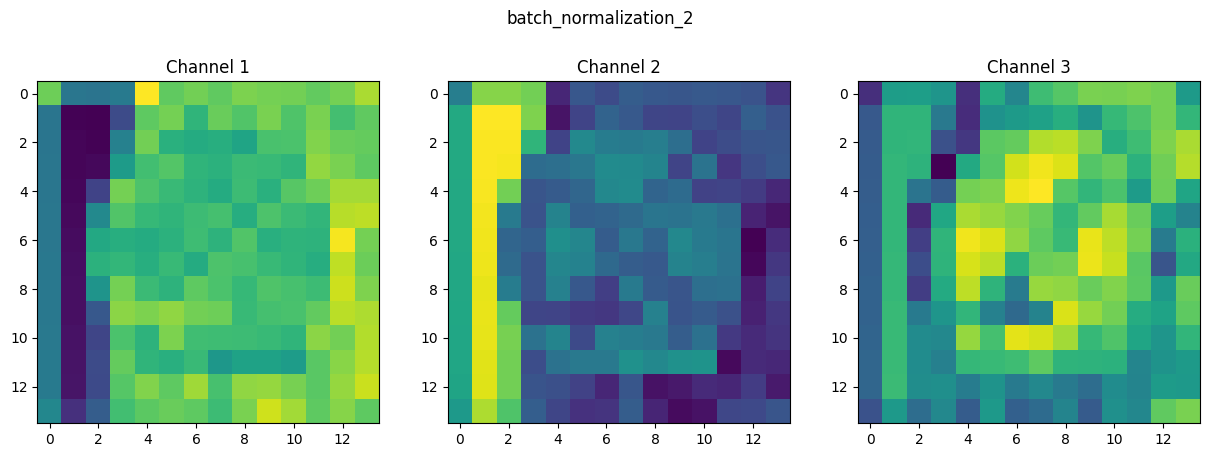

add_2 (1, 14, 14, 728)


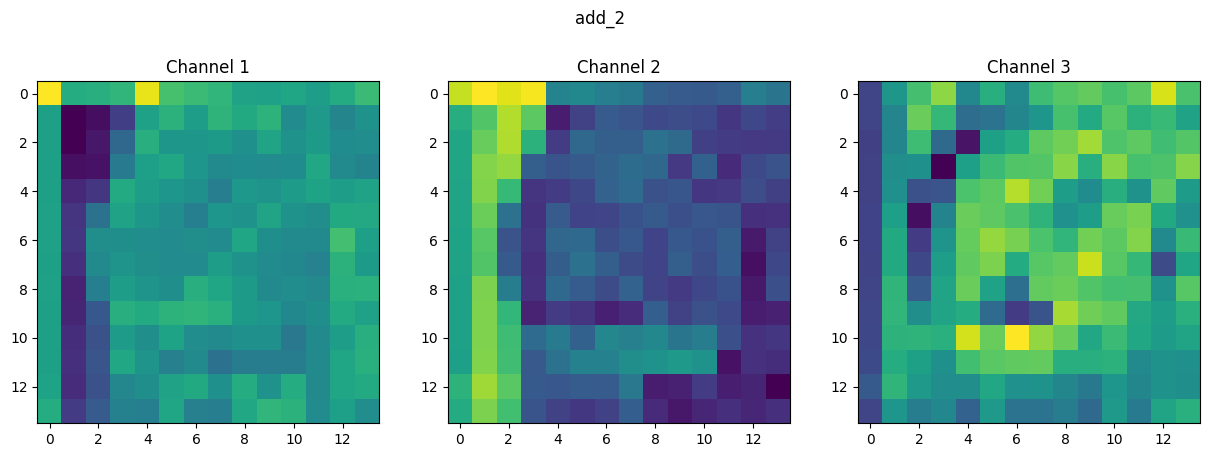

block5_sepconv1_act (1, 14, 14, 728)


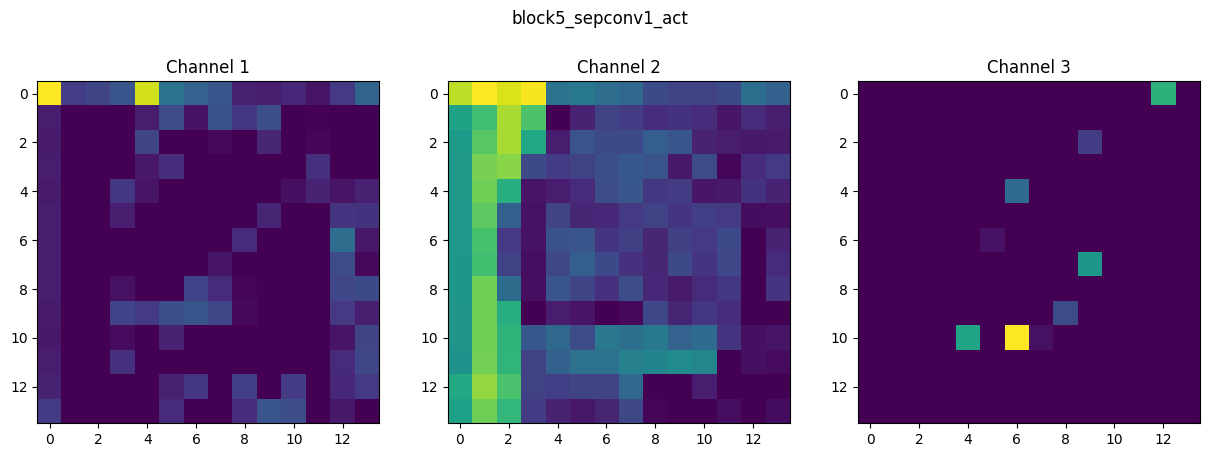

block5_sepconv1 (1, 14, 14, 728)


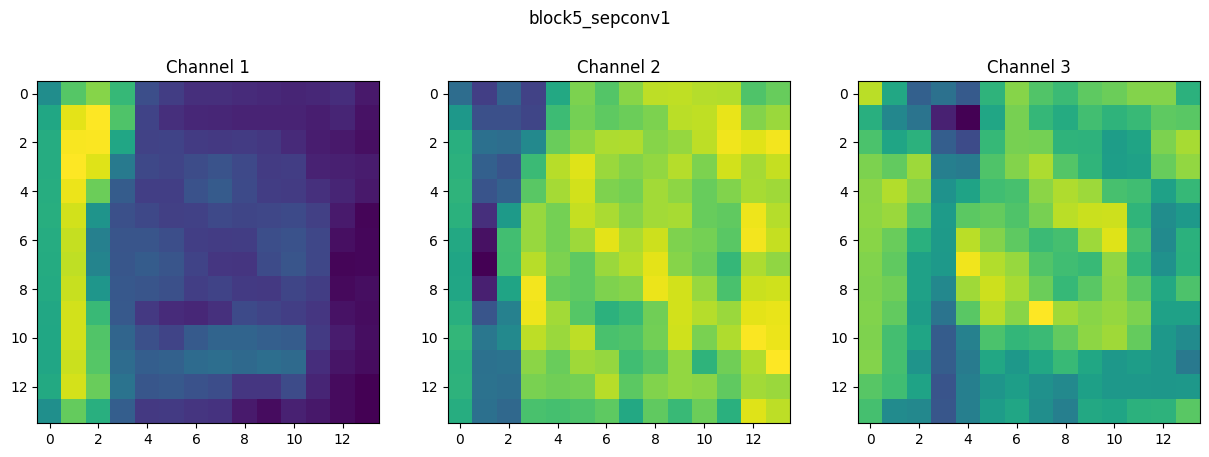

block5_sepconv1_bn (1, 14, 14, 728)


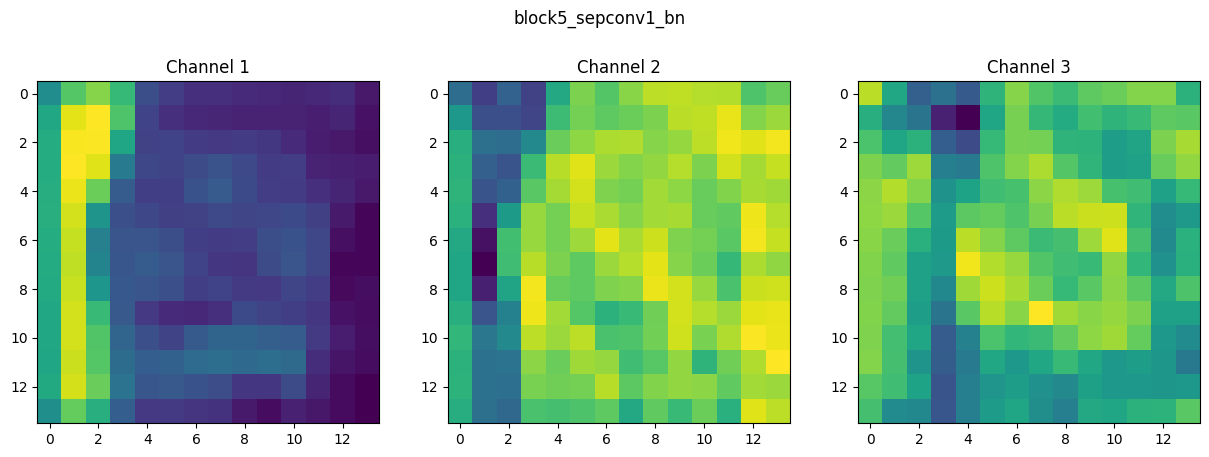

block5_sepconv2_act (1, 14, 14, 728)


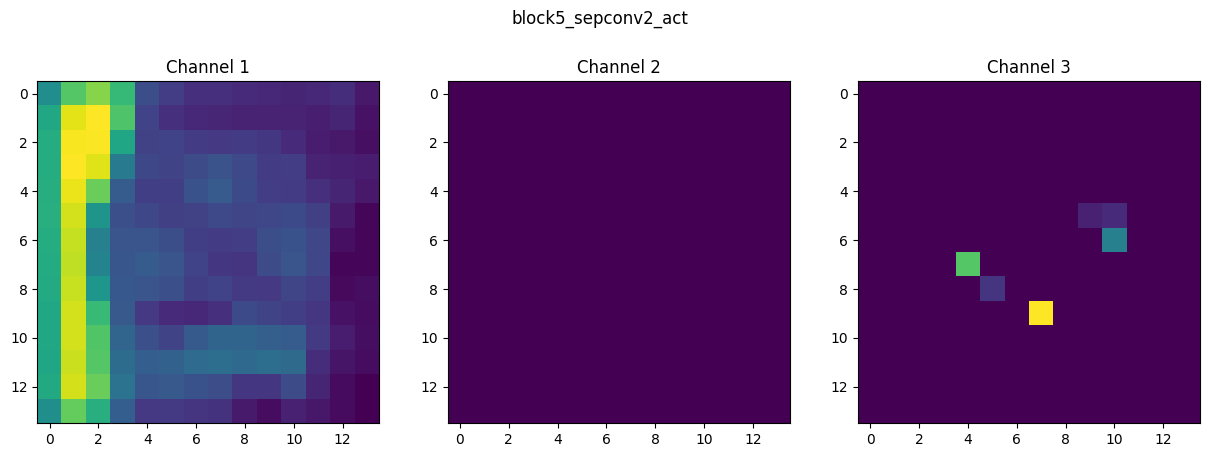

block5_sepconv2 (1, 14, 14, 728)


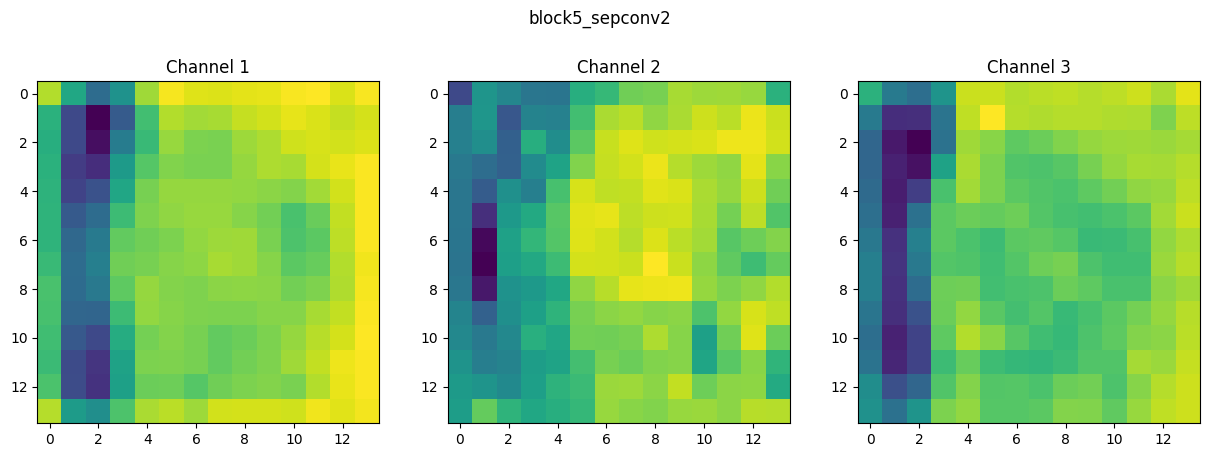

block5_sepconv2_bn (1, 14, 14, 728)


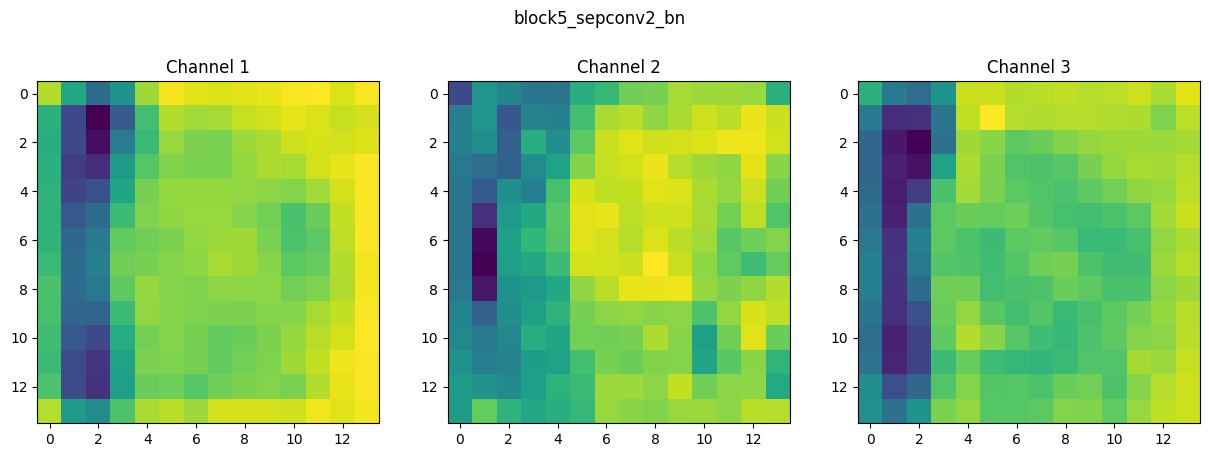

block5_sepconv3_act (1, 14, 14, 728)


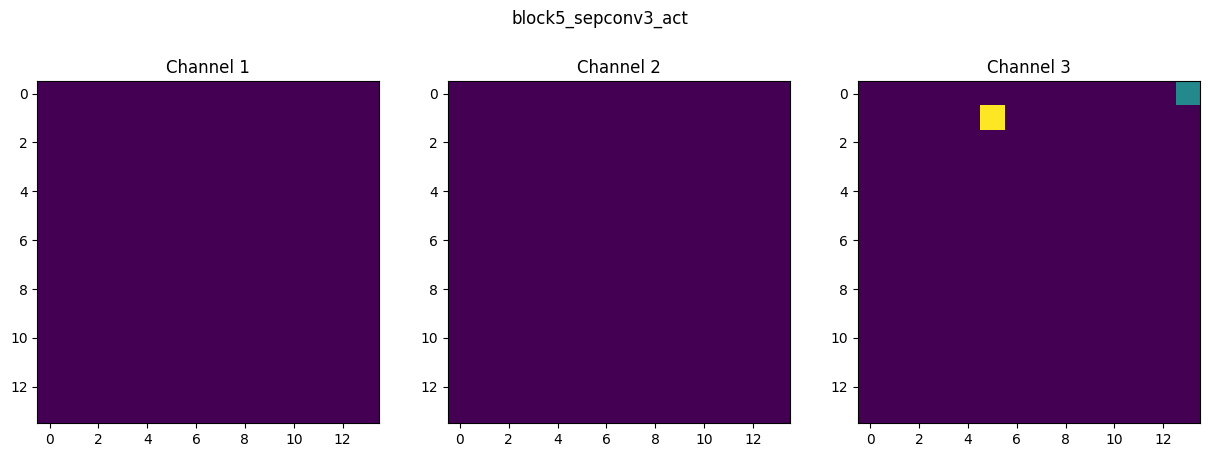

block5_sepconv3 (1, 14, 14, 728)


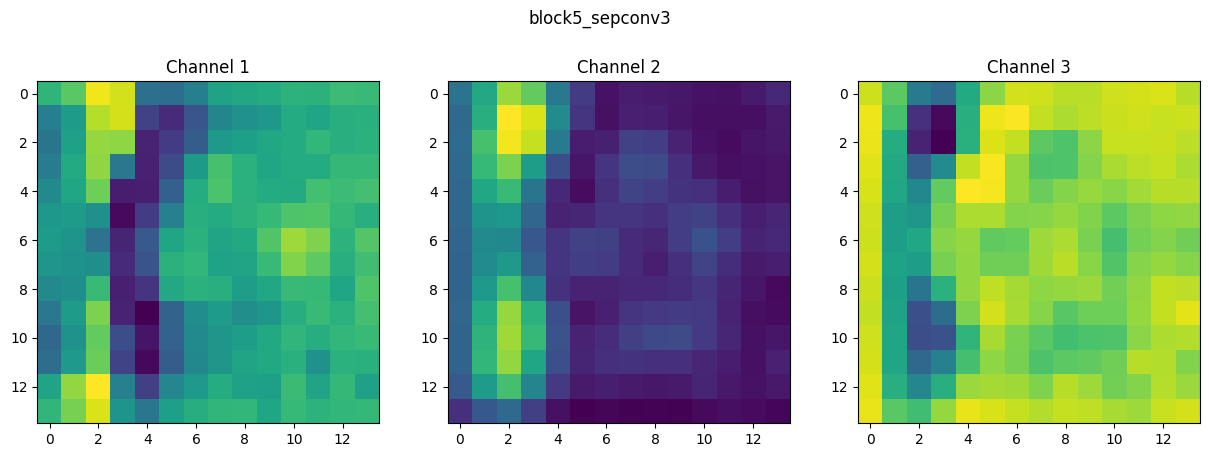

block5_sepconv3_bn (1, 14, 14, 728)


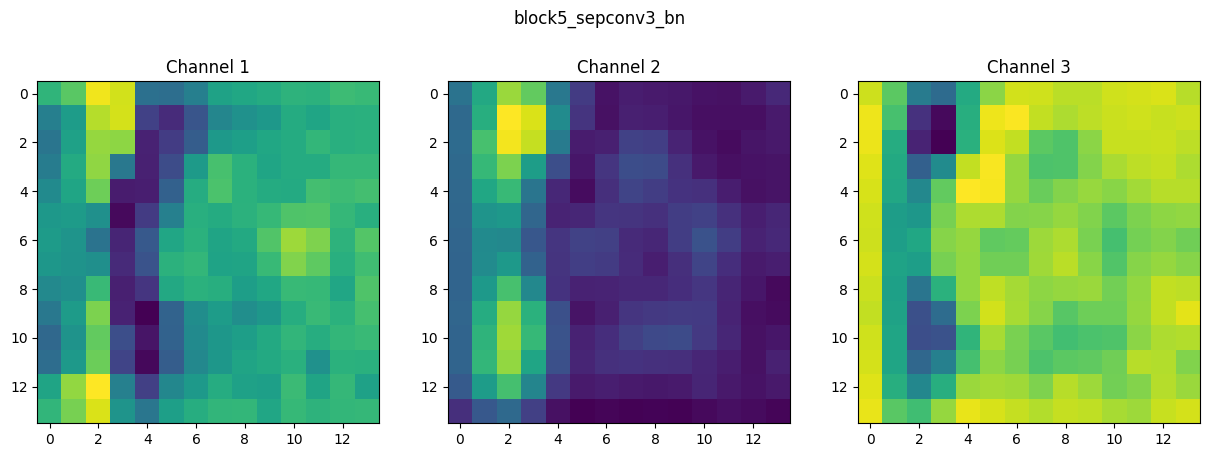

add_3 (1, 14, 14, 728)


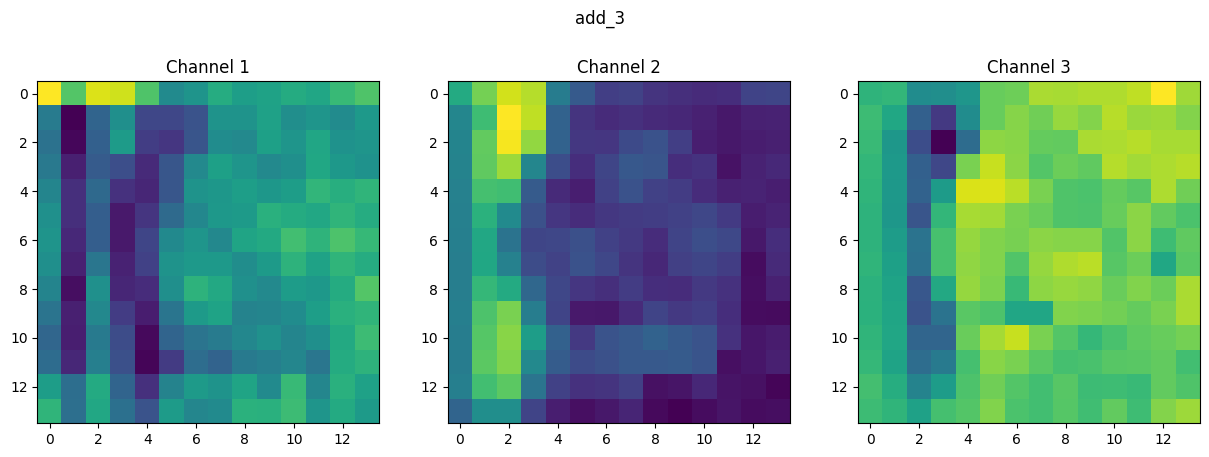

block6_sepconv1_act (1, 14, 14, 728)


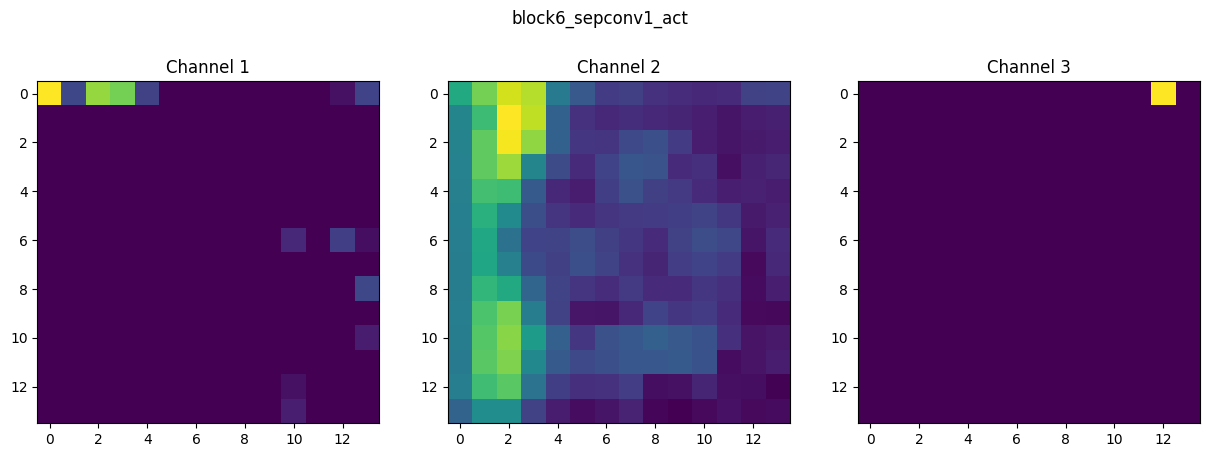

block6_sepconv1 (1, 14, 14, 728)


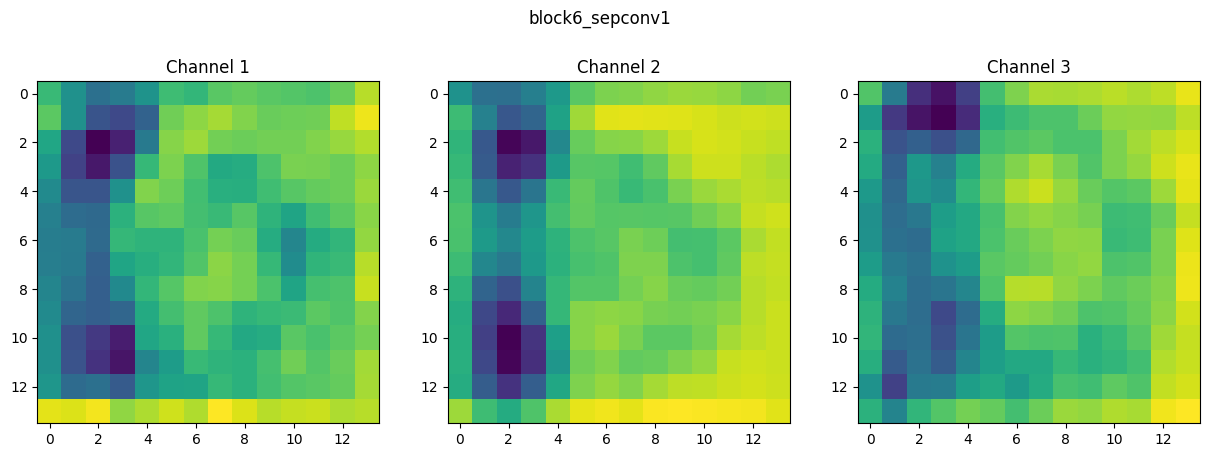

block6_sepconv1_bn (1, 14, 14, 728)


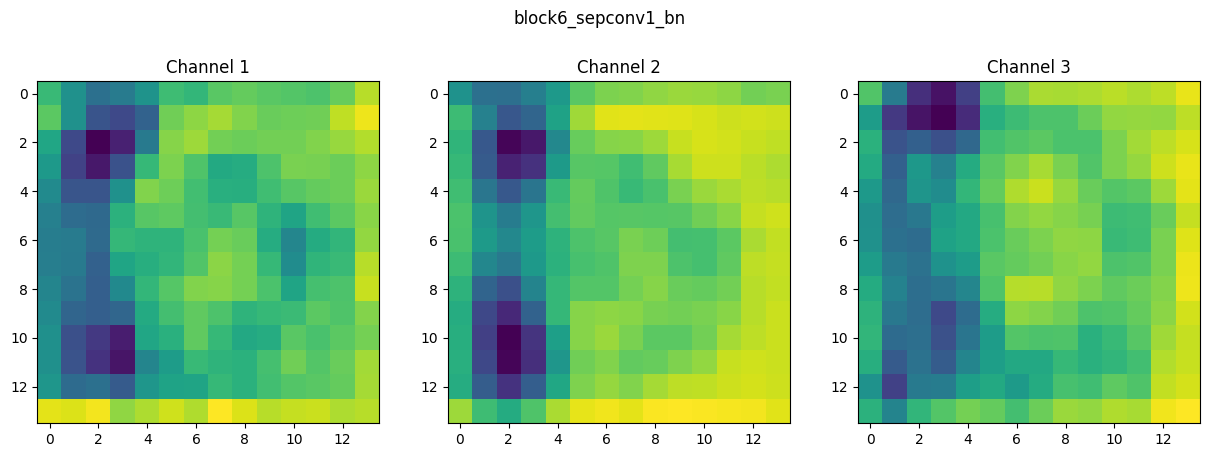

block6_sepconv2_act (1, 14, 14, 728)


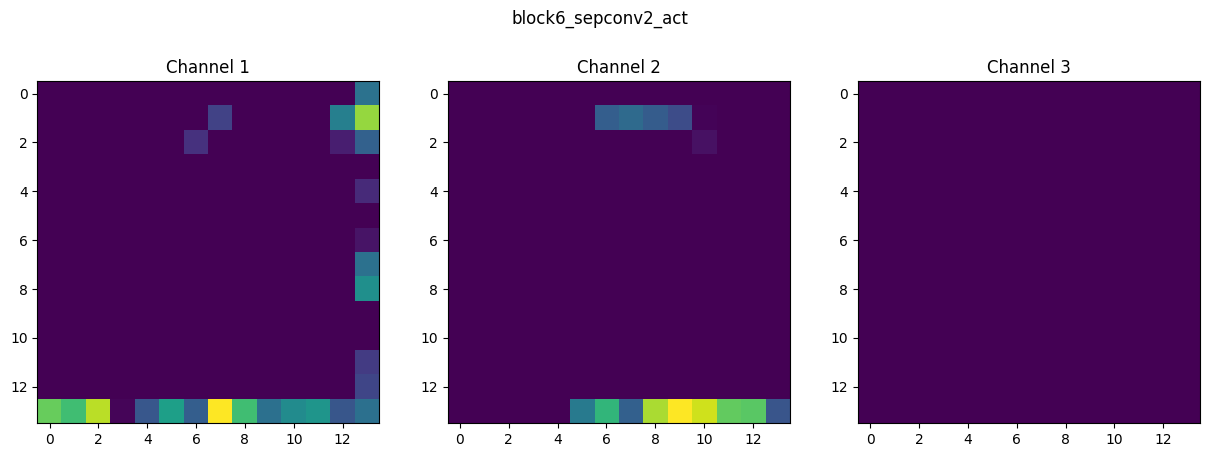

block6_sepconv2 (1, 14, 14, 728)


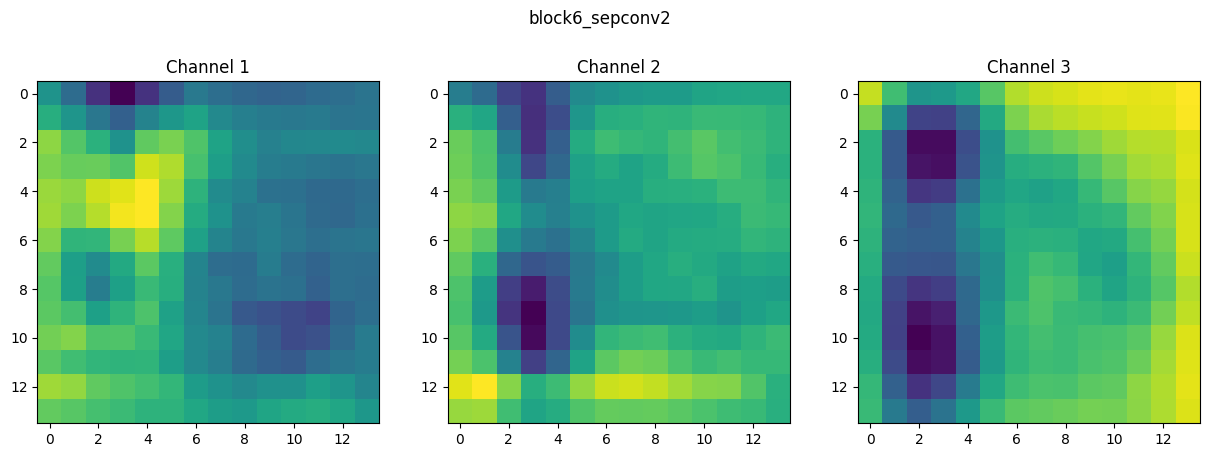

block6_sepconv2_bn (1, 14, 14, 728)


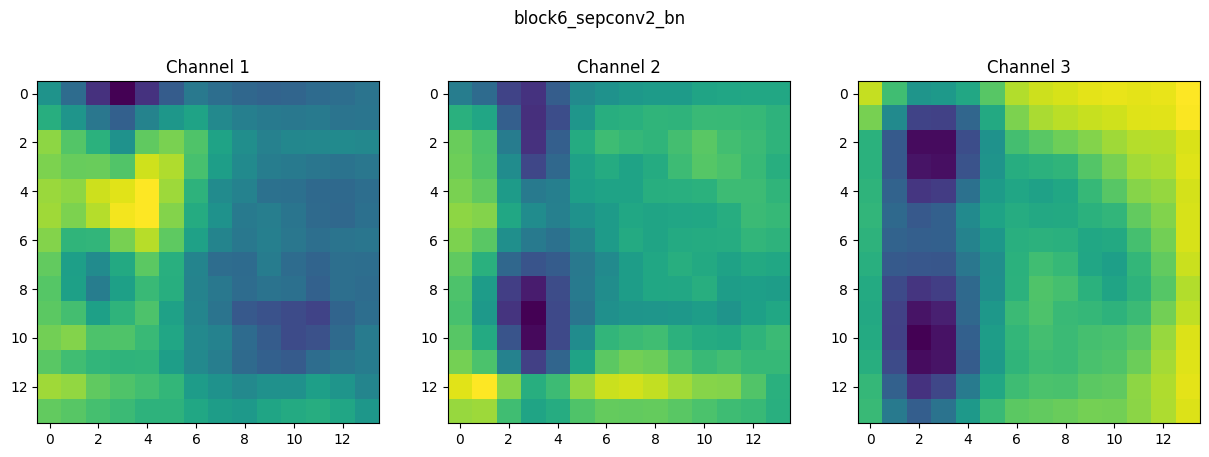

block6_sepconv3_act (1, 14, 14, 728)


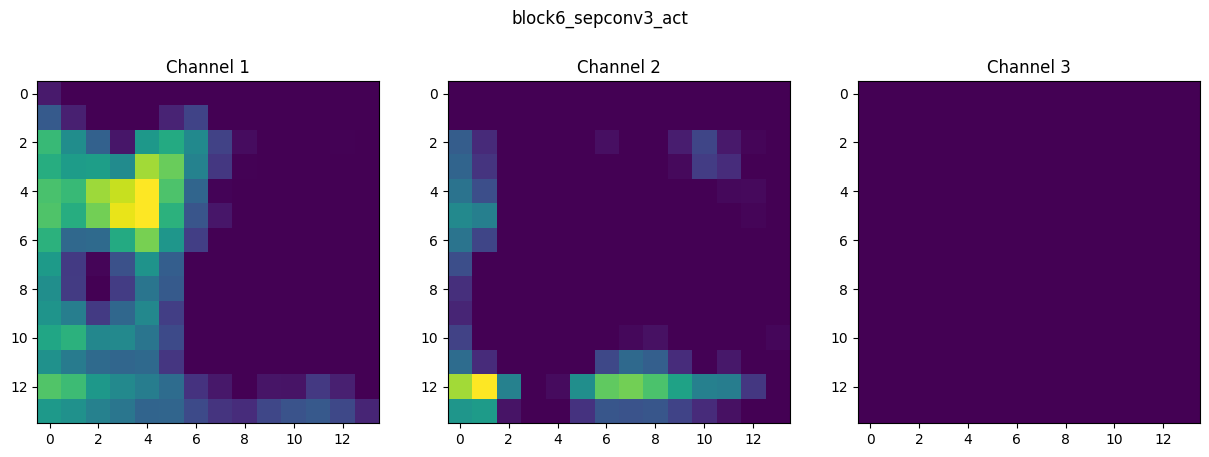

block6_sepconv3 (1, 14, 14, 728)


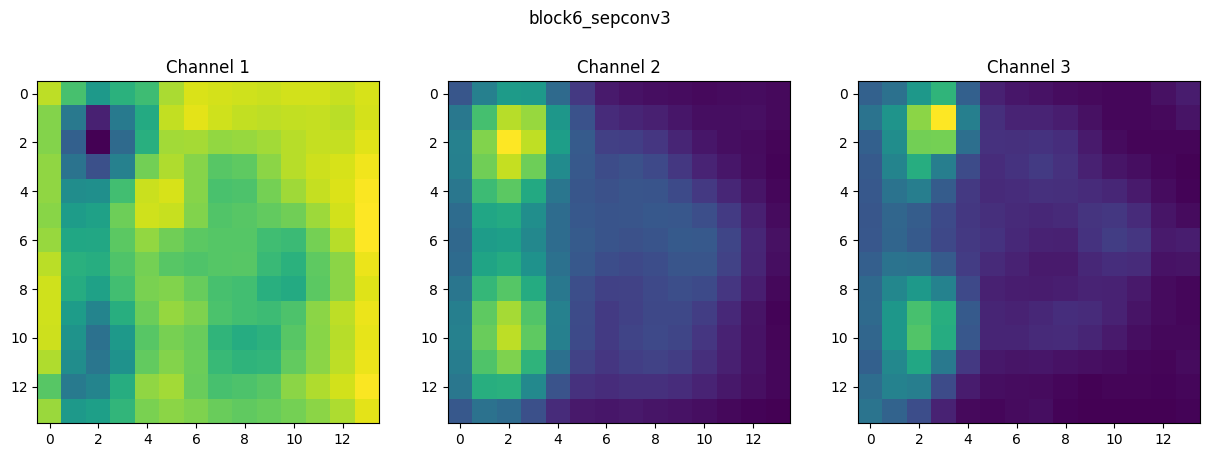

block6_sepconv3_bn (1, 14, 14, 728)


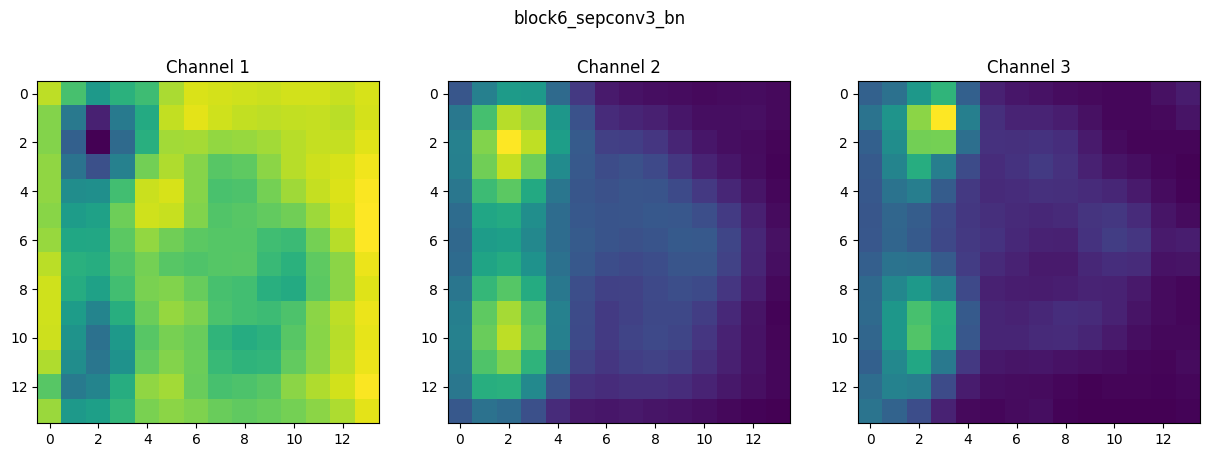

add_4 (1, 14, 14, 728)


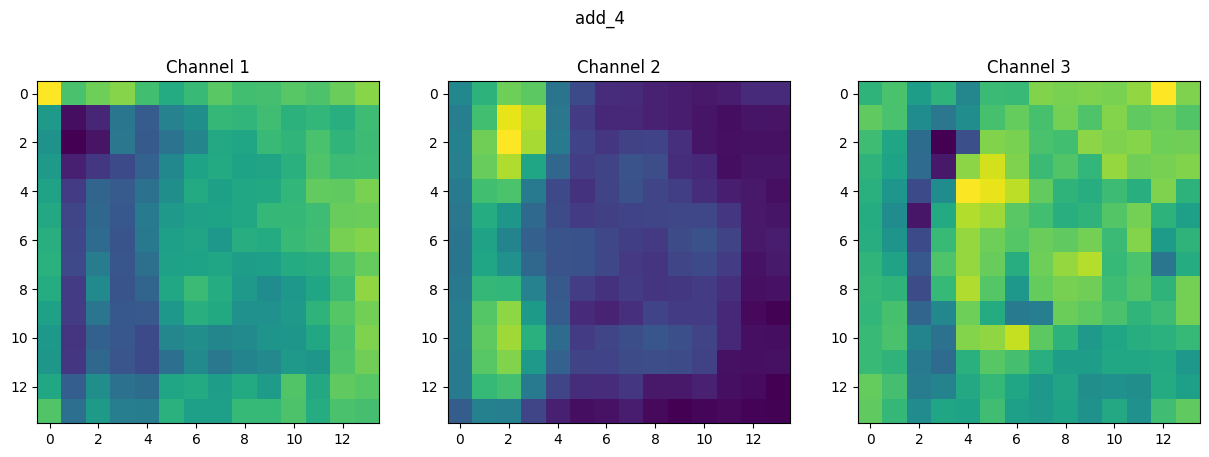

block7_sepconv1_act (1, 14, 14, 728)


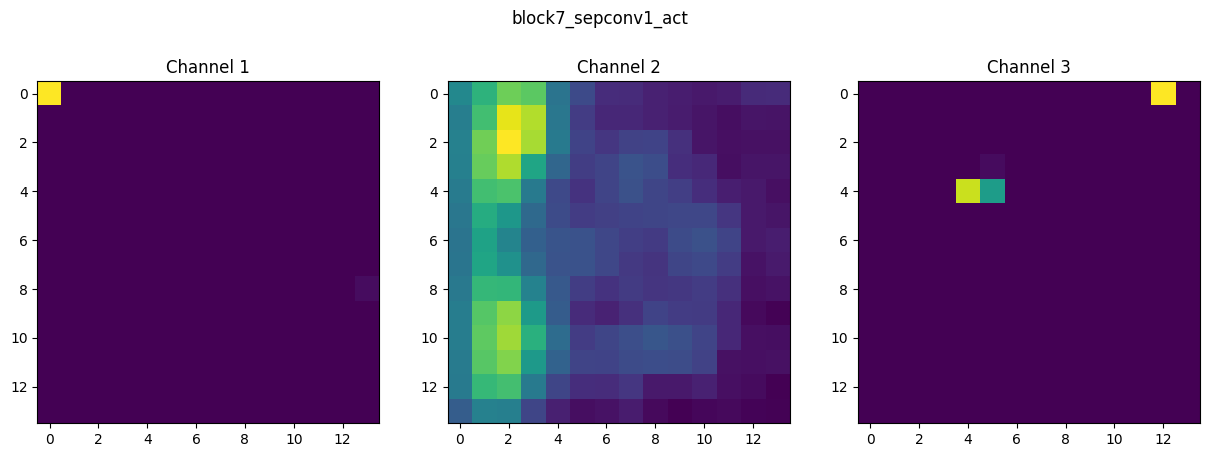

block7_sepconv1 (1, 14, 14, 728)


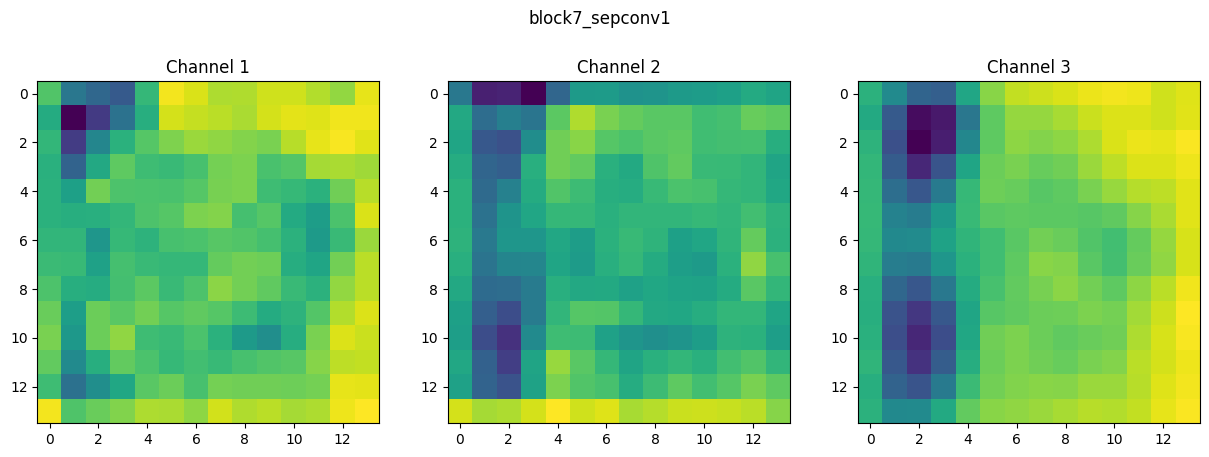

block7_sepconv1_bn (1, 14, 14, 728)


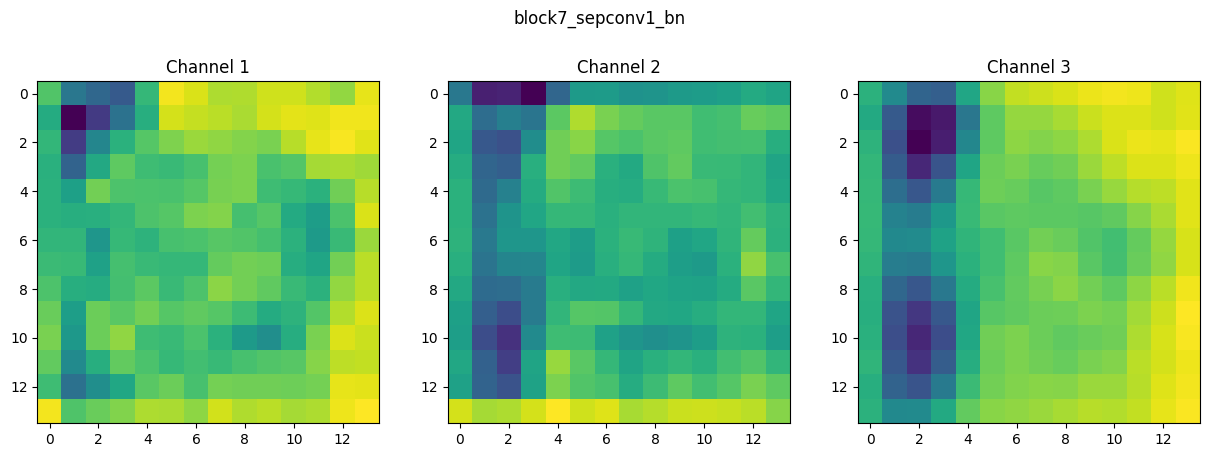

block7_sepconv2_act (1, 14, 14, 728)


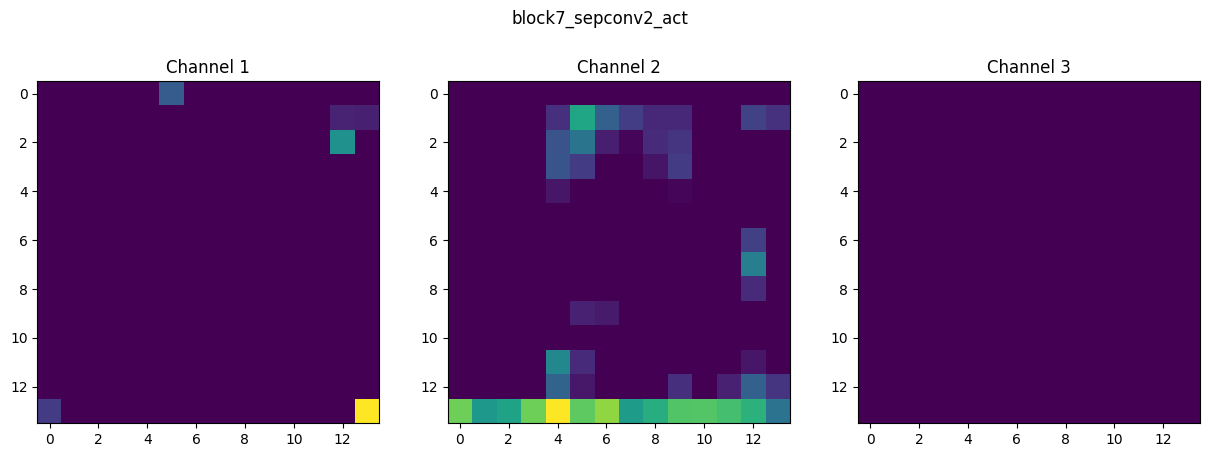

block7_sepconv2 (1, 14, 14, 728)


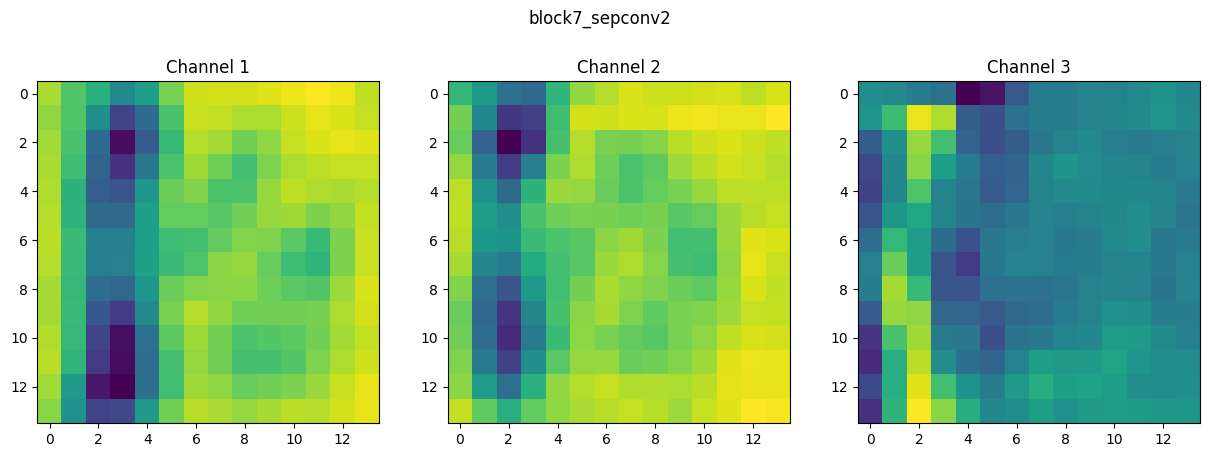

block7_sepconv2_bn (1, 14, 14, 728)


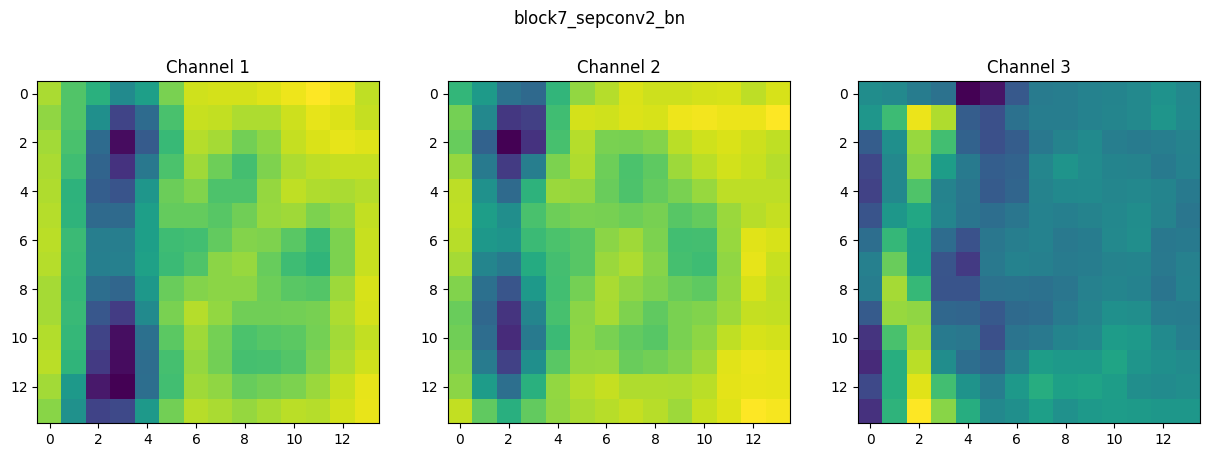

block7_sepconv3_act (1, 14, 14, 728)


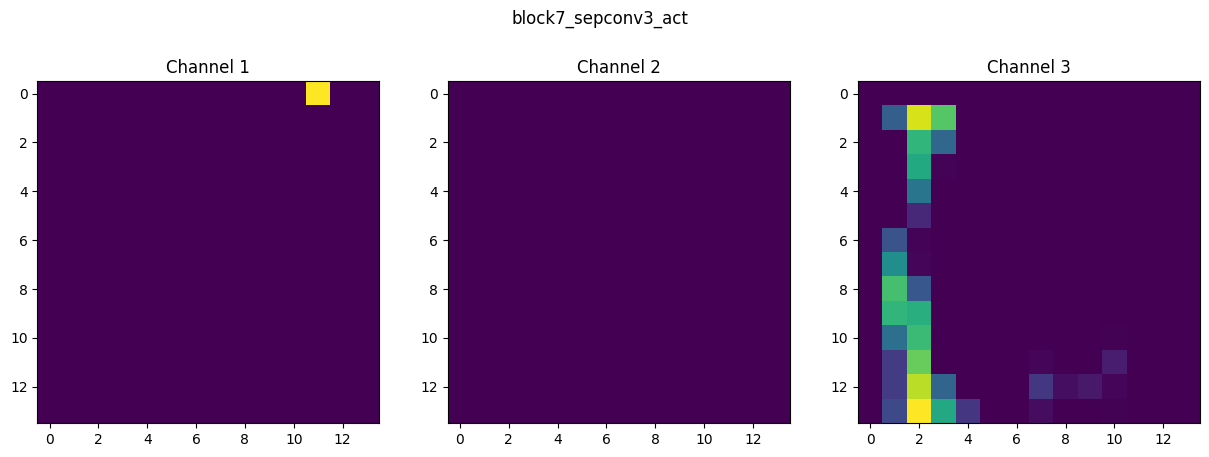

block7_sepconv3 (1, 14, 14, 728)


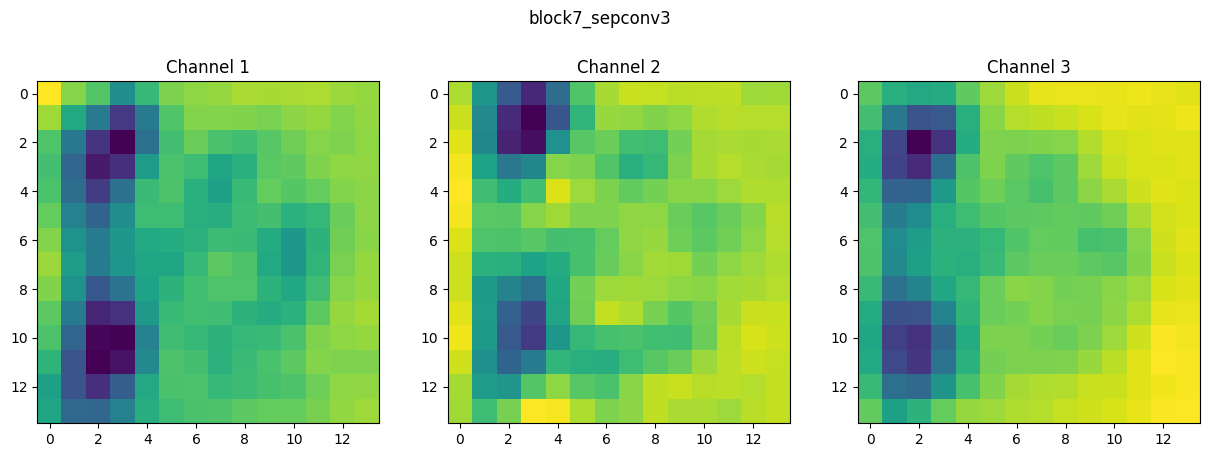

block7_sepconv3_bn (1, 14, 14, 728)


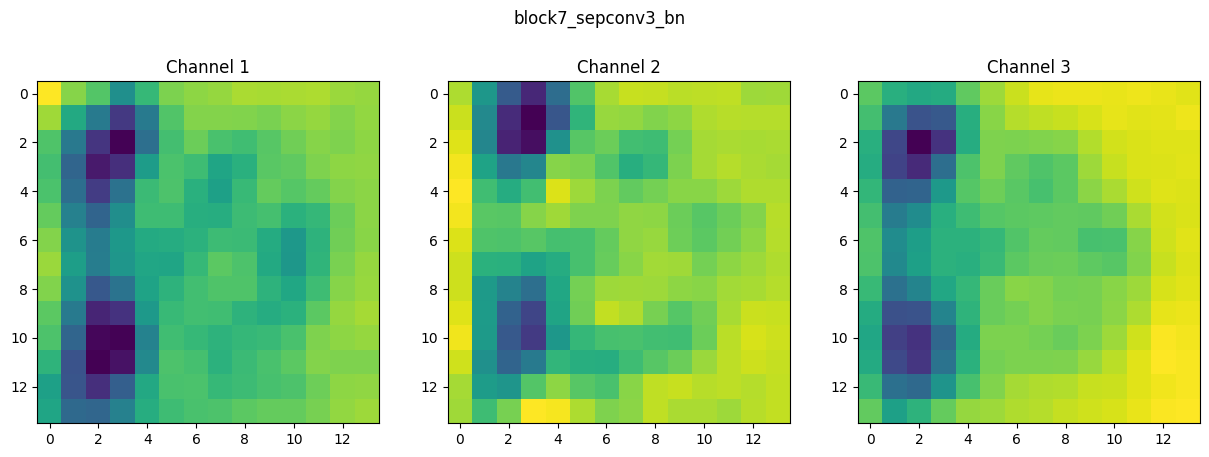

add_5 (1, 14, 14, 728)


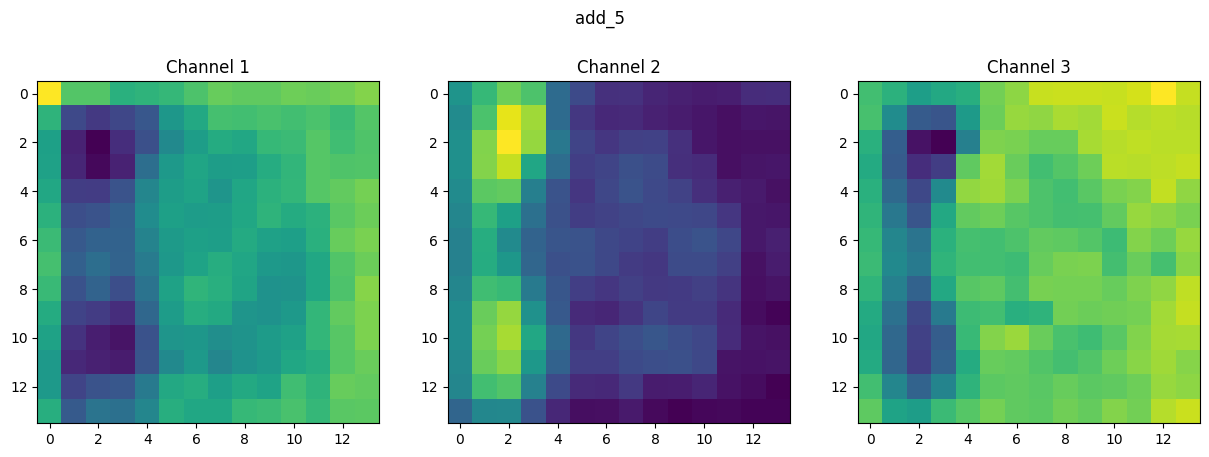

block8_sepconv1_act (1, 14, 14, 728)


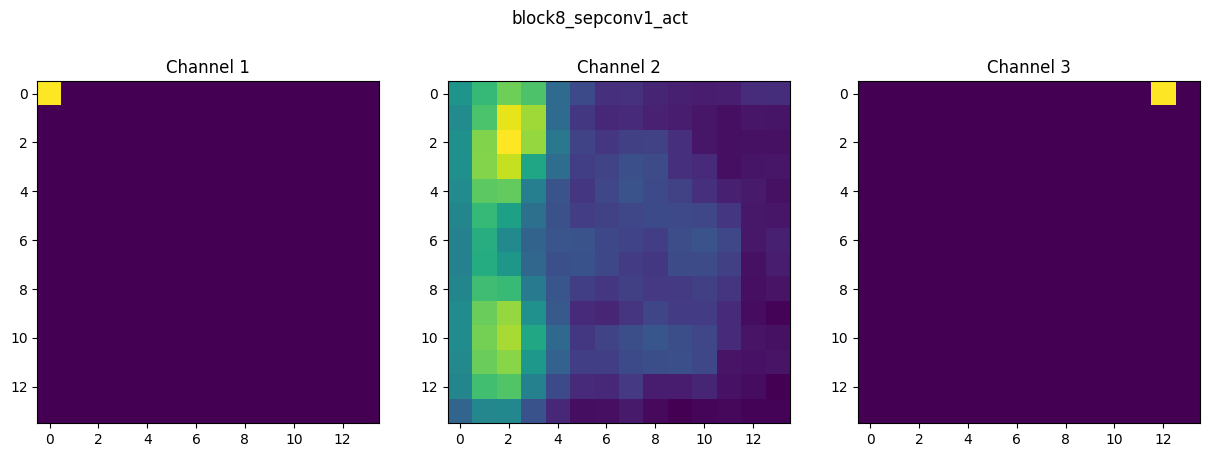

block8_sepconv1 (1, 14, 14, 728)


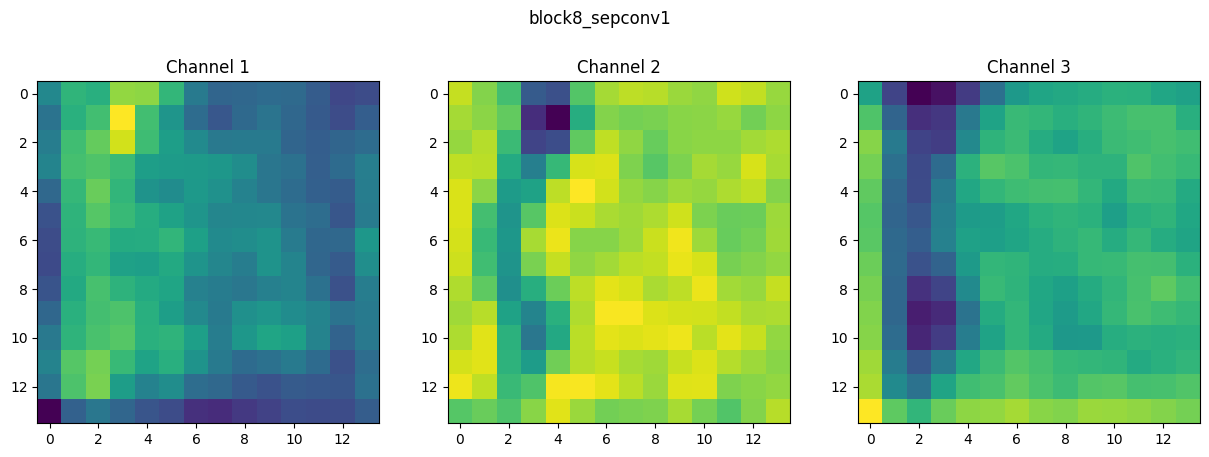

block8_sepconv1_bn (1, 14, 14, 728)


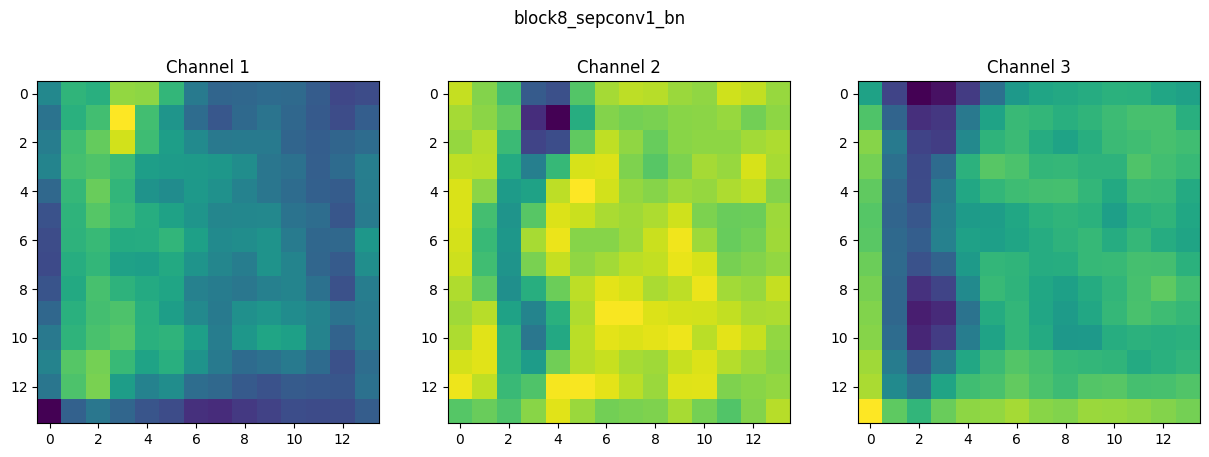

block8_sepconv2_act (1, 14, 14, 728)


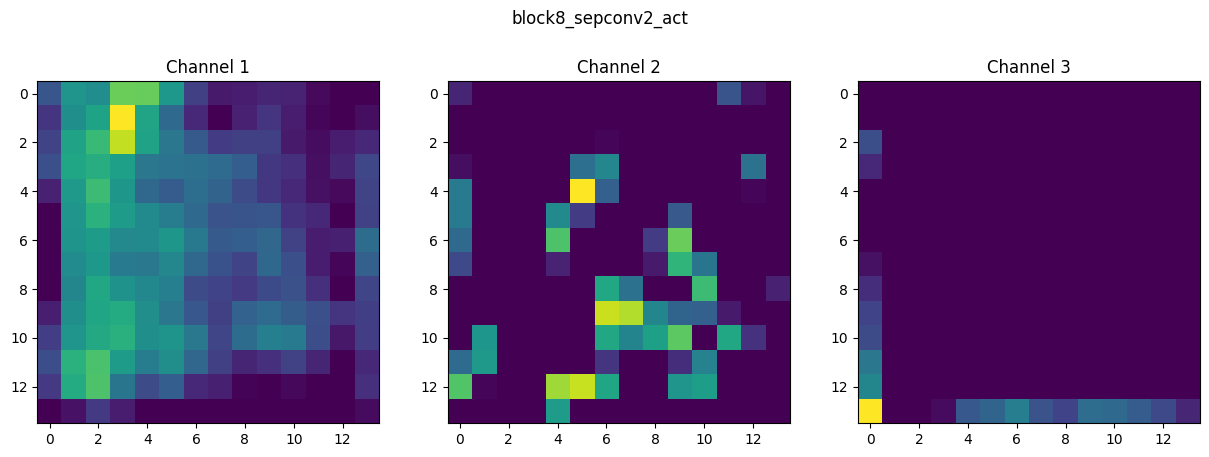

block8_sepconv2 (1, 14, 14, 728)


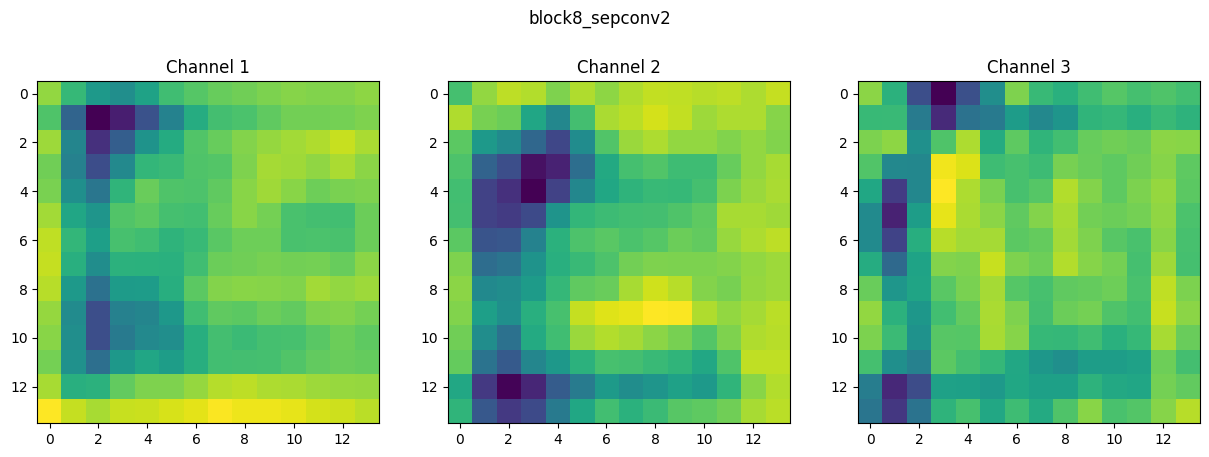

block8_sepconv2_bn (1, 14, 14, 728)


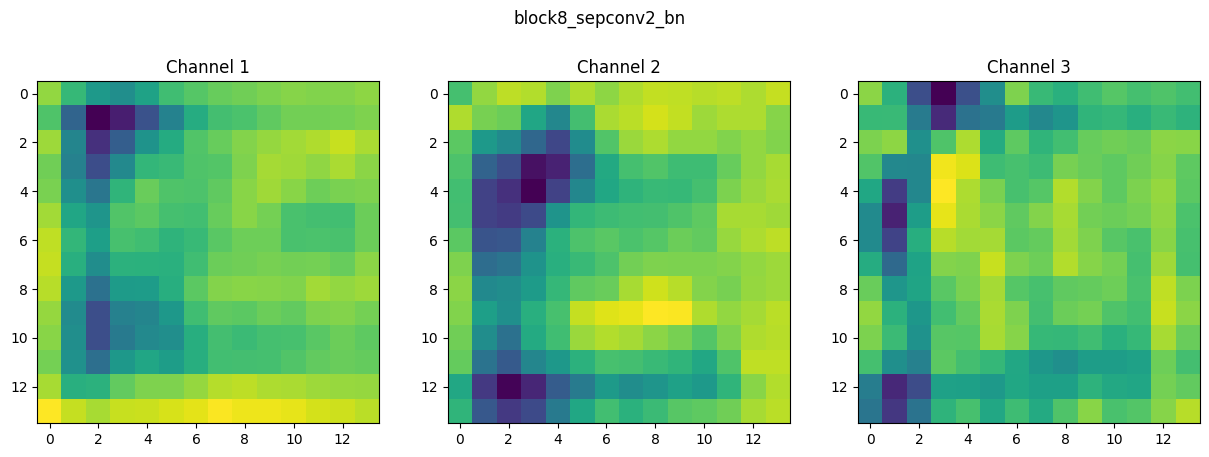

block8_sepconv3_act (1, 14, 14, 728)


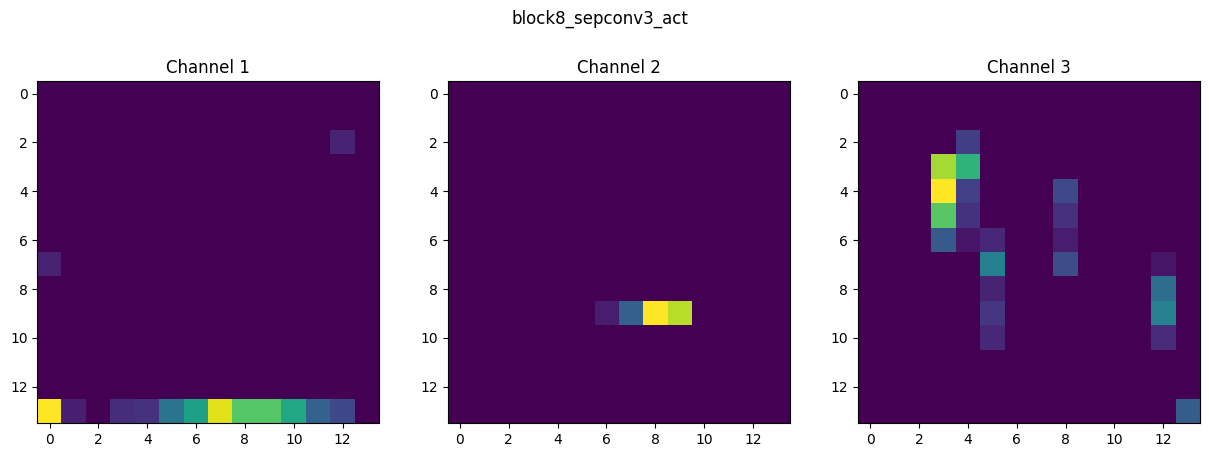

block8_sepconv3 (1, 14, 14, 728)


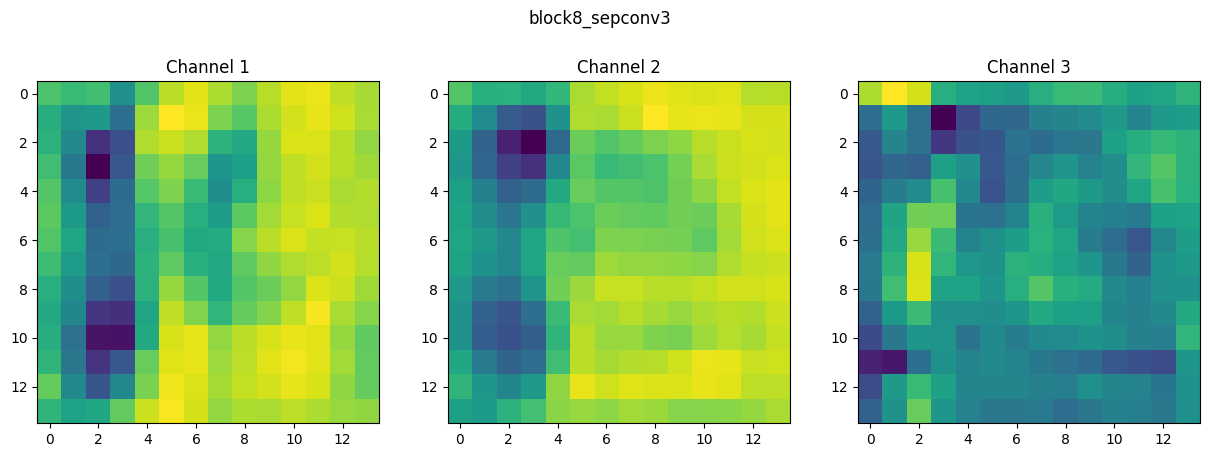

block8_sepconv3_bn (1, 14, 14, 728)


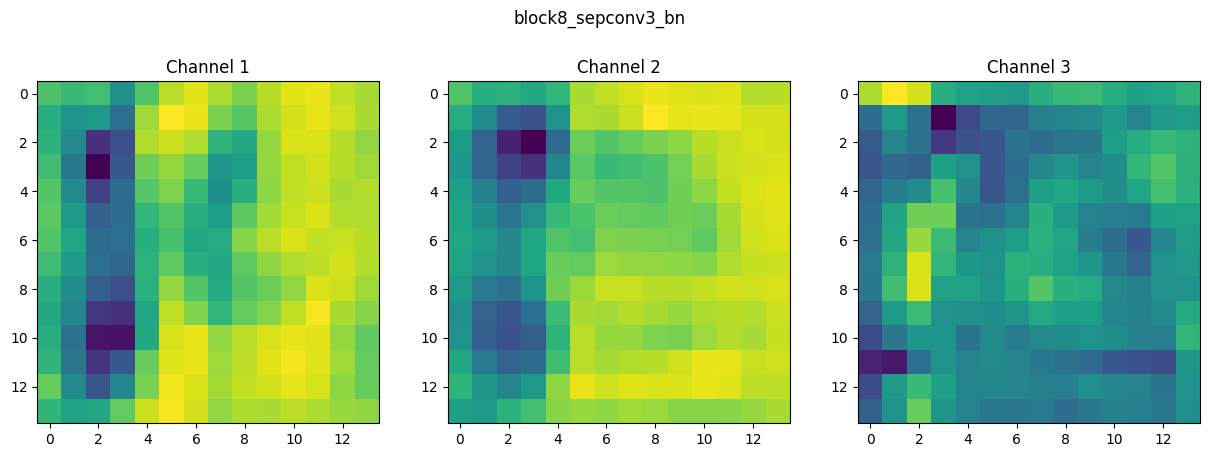

add_6 (1, 14, 14, 728)


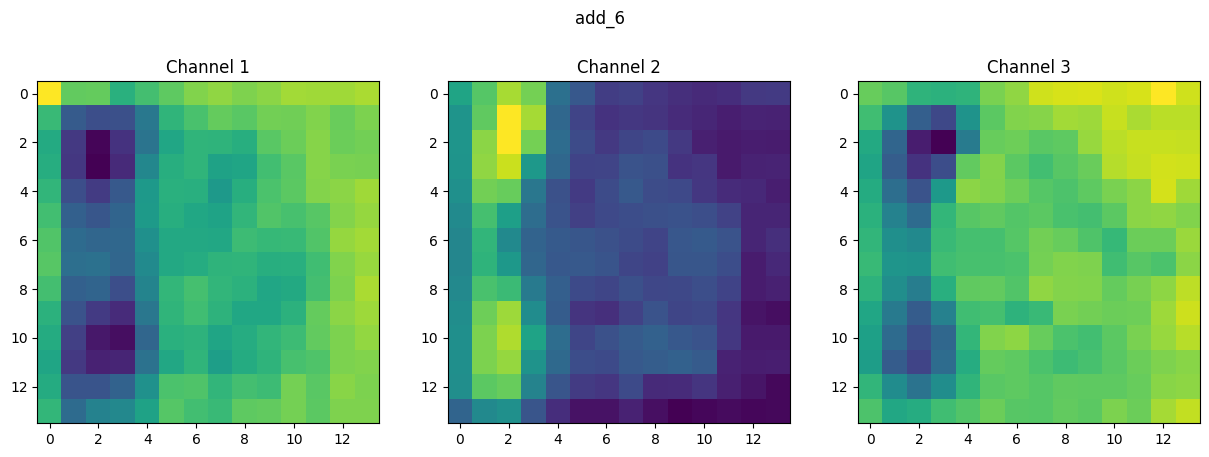

block9_sepconv1_act (1, 14, 14, 728)


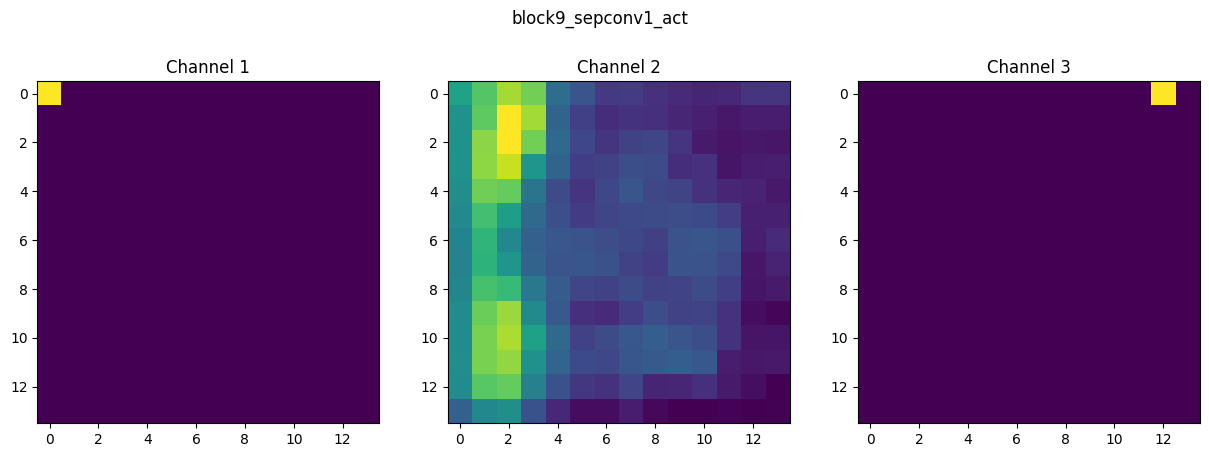

block9_sepconv1 (1, 14, 14, 728)


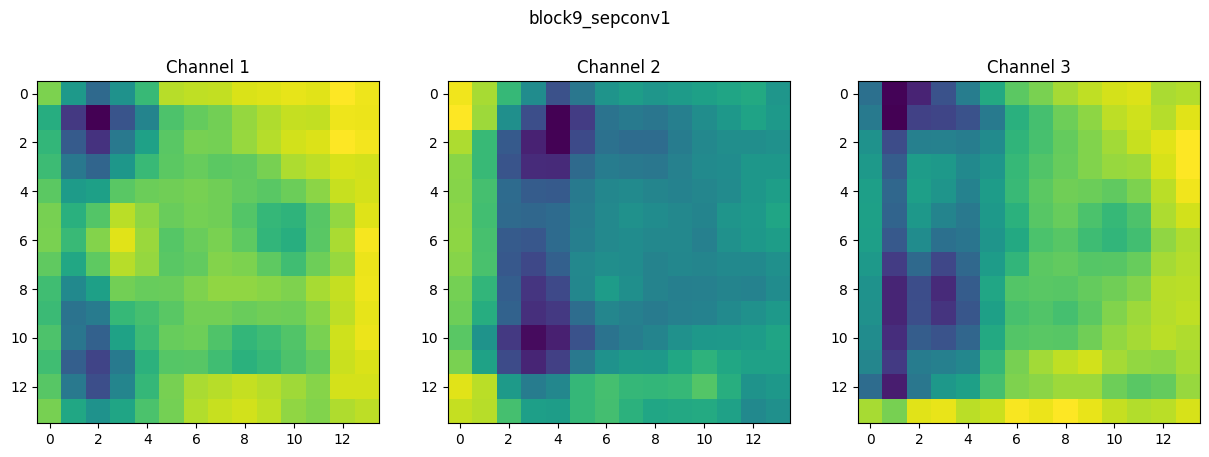

block9_sepconv1_bn (1, 14, 14, 728)


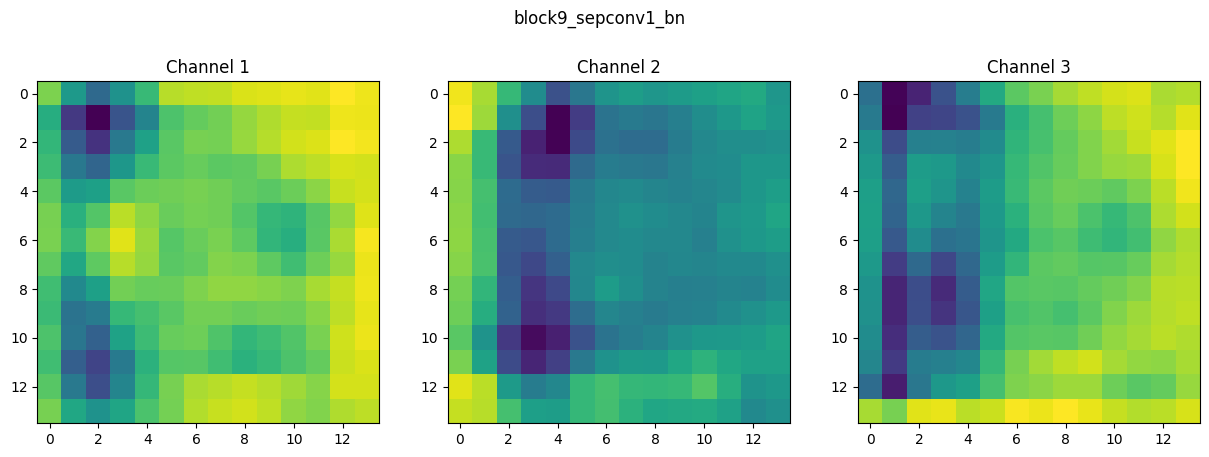

block9_sepconv2_act (1, 14, 14, 728)


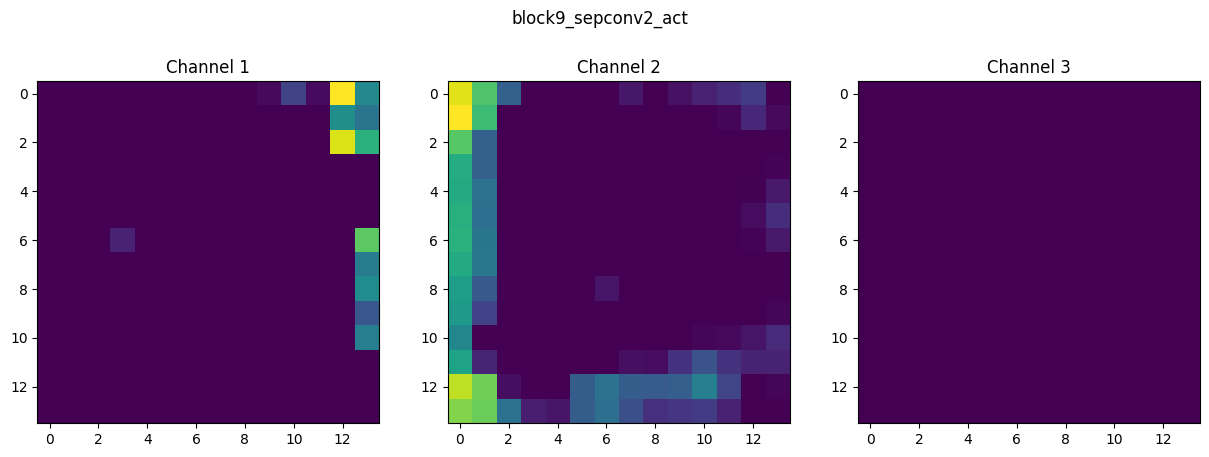

block9_sepconv2 (1, 14, 14, 728)


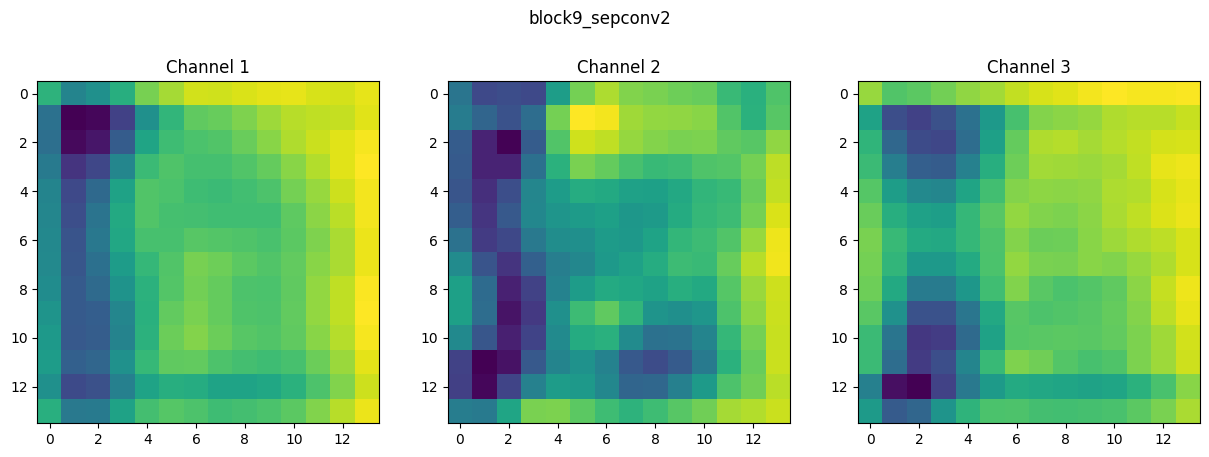

block9_sepconv2_bn (1, 14, 14, 728)


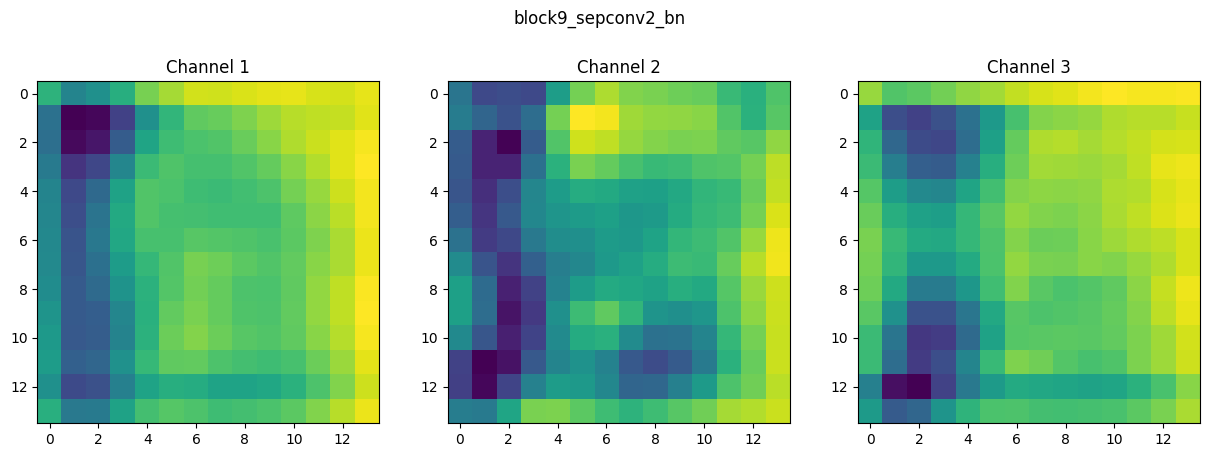

block9_sepconv3_act (1, 14, 14, 728)


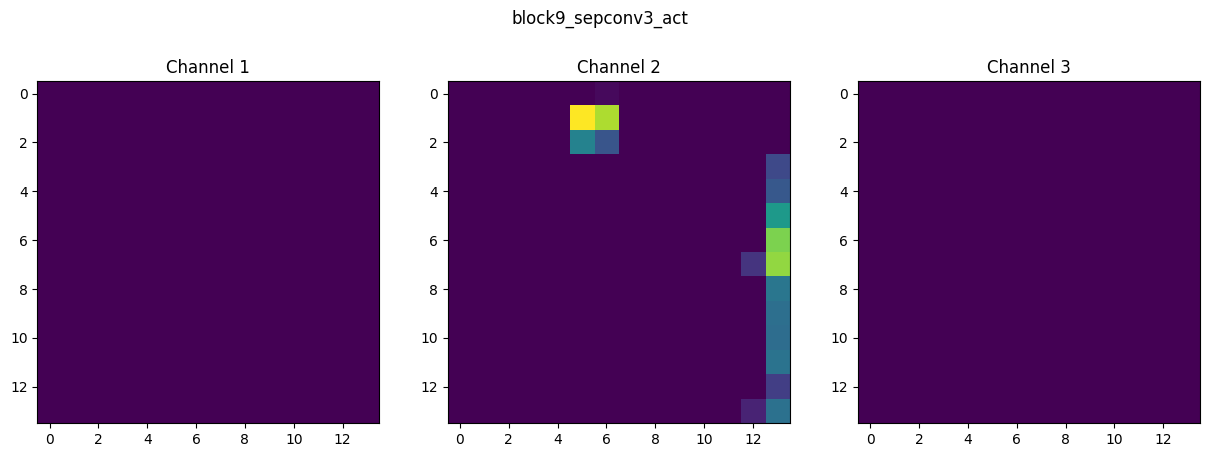

block9_sepconv3 (1, 14, 14, 728)


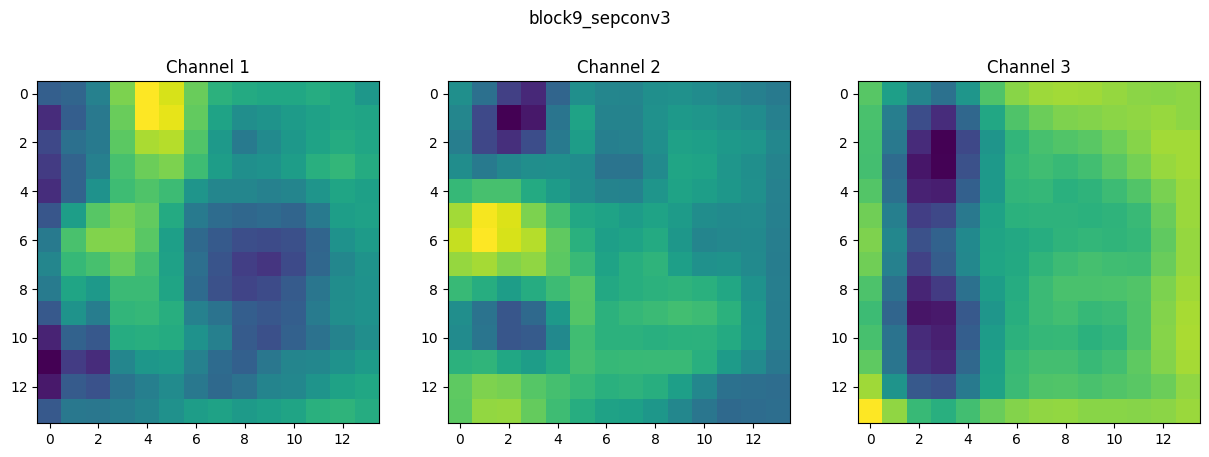

block9_sepconv3_bn (1, 14, 14, 728)


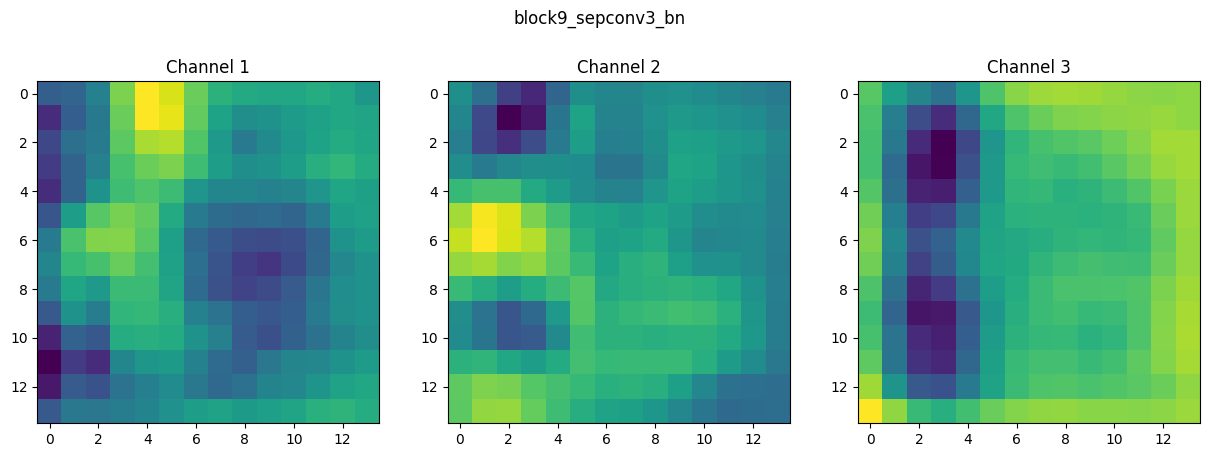

add_7 (1, 14, 14, 728)


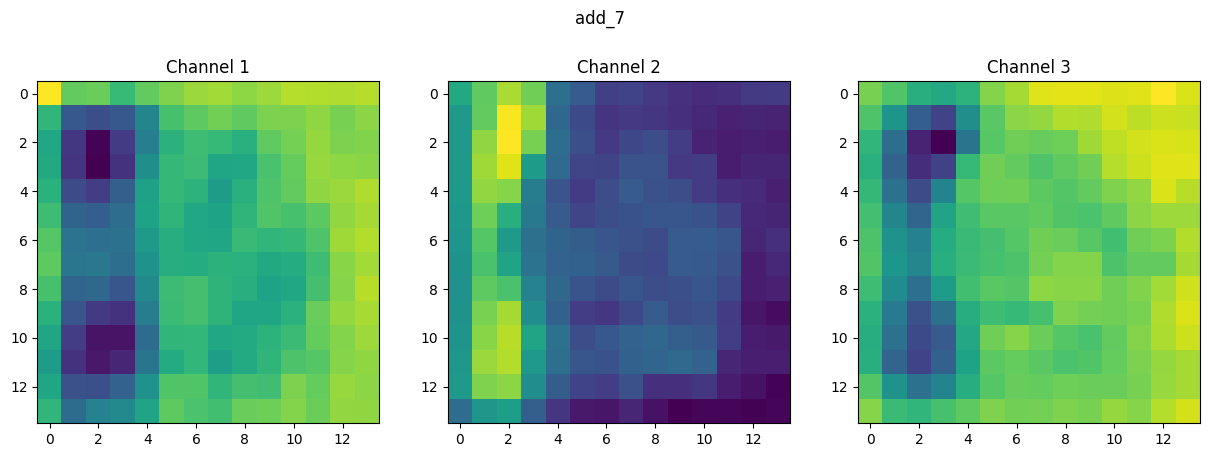

block10_sepconv1_act (1, 14, 14, 728)


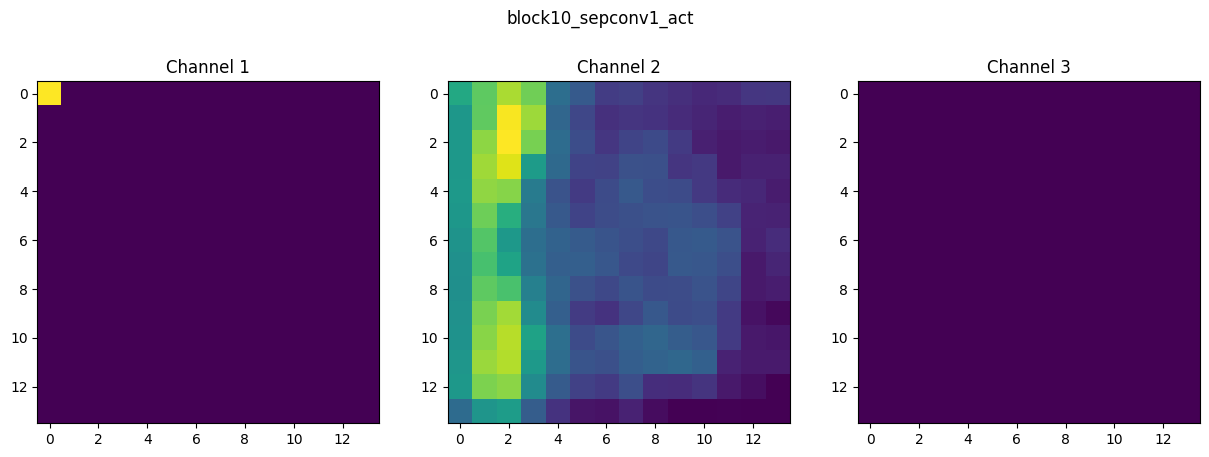

block10_sepconv1 (1, 14, 14, 728)


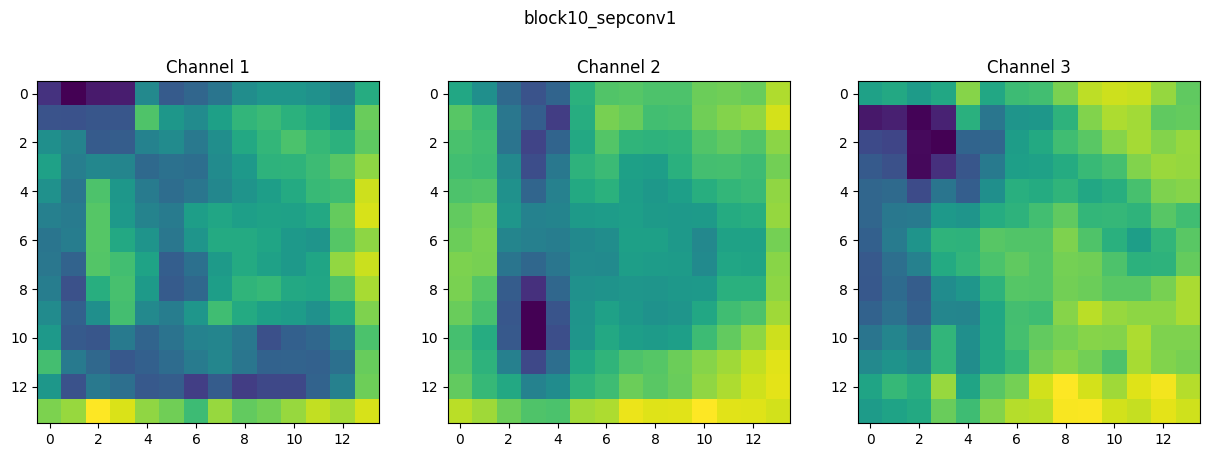

block10_sepconv1_bn (1, 14, 14, 728)


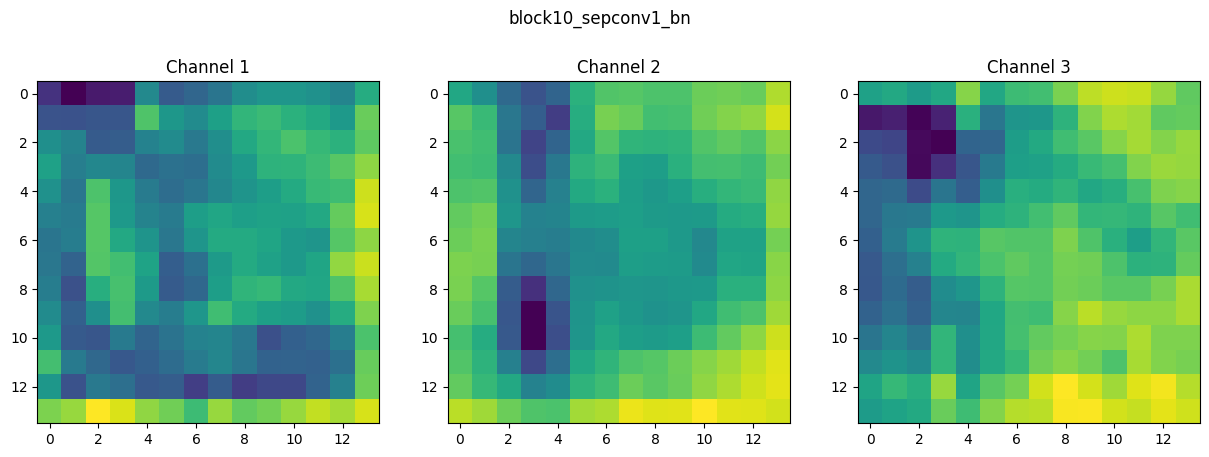

block10_sepconv2_act (1, 14, 14, 728)


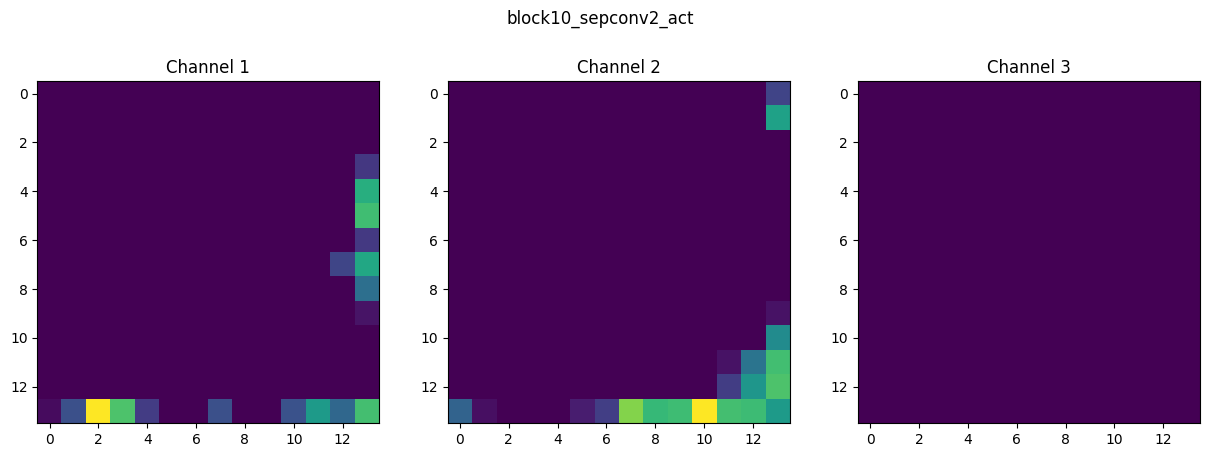

block10_sepconv2 (1, 14, 14, 728)


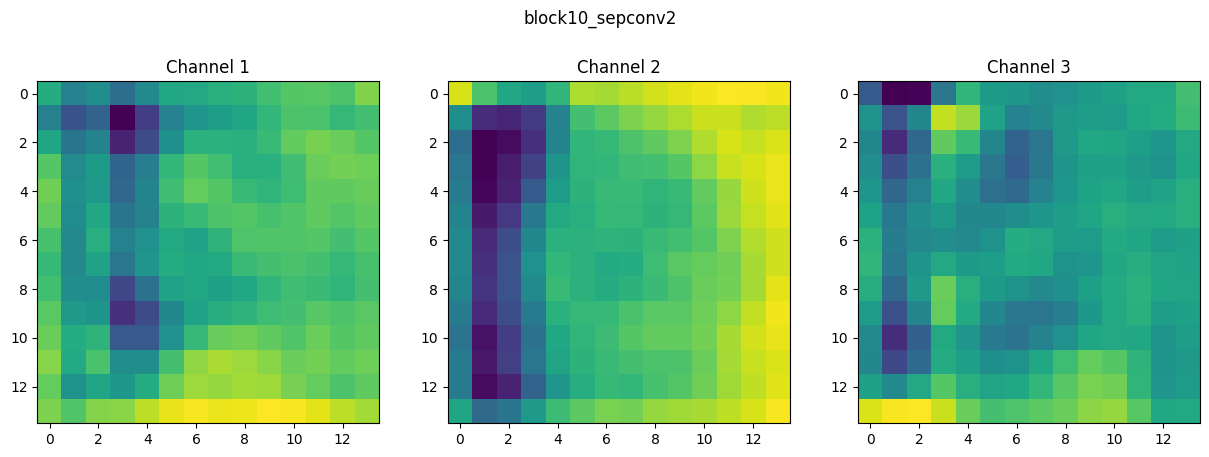

block10_sepconv2_bn (1, 14, 14, 728)


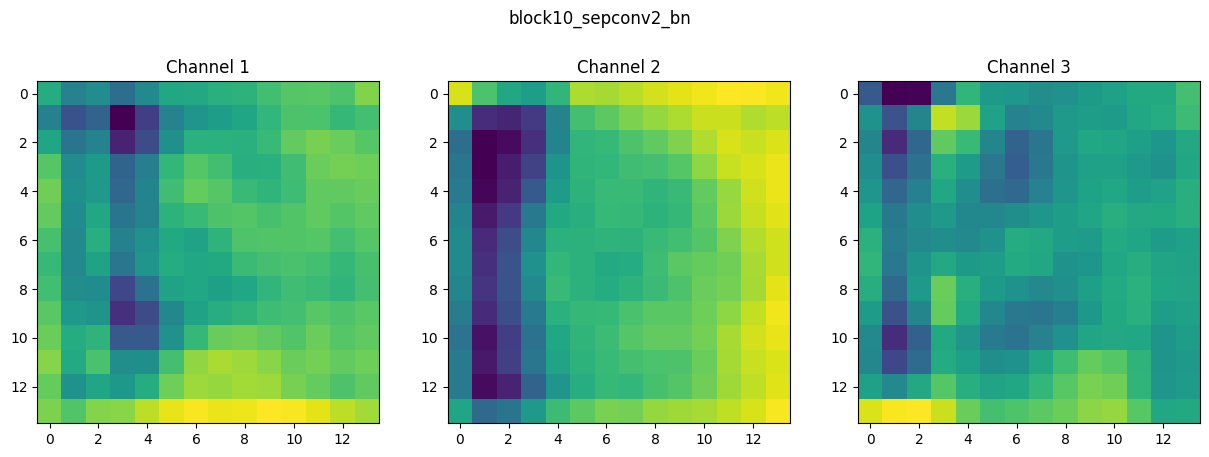

block10_sepconv3_act (1, 14, 14, 728)


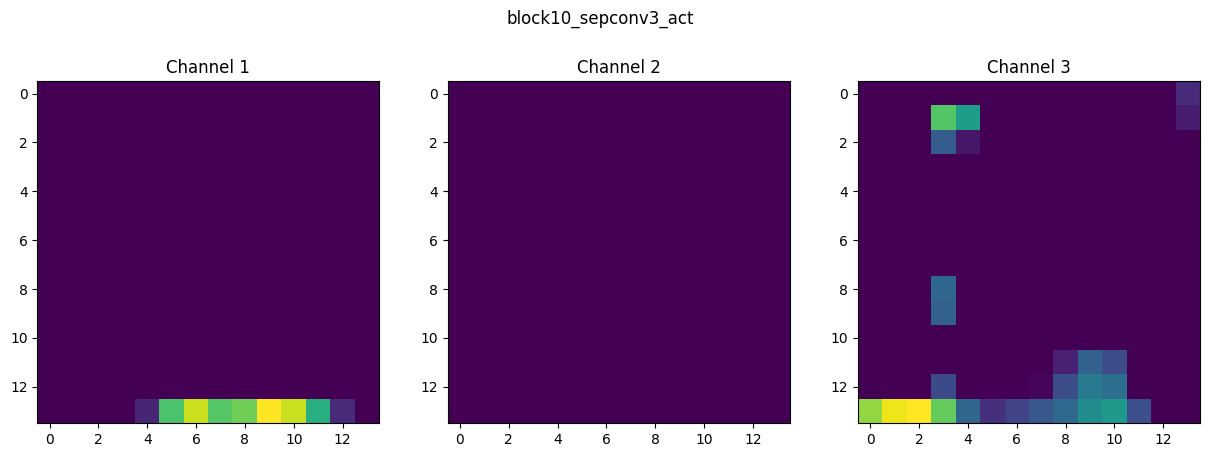

block10_sepconv3 (1, 14, 14, 728)


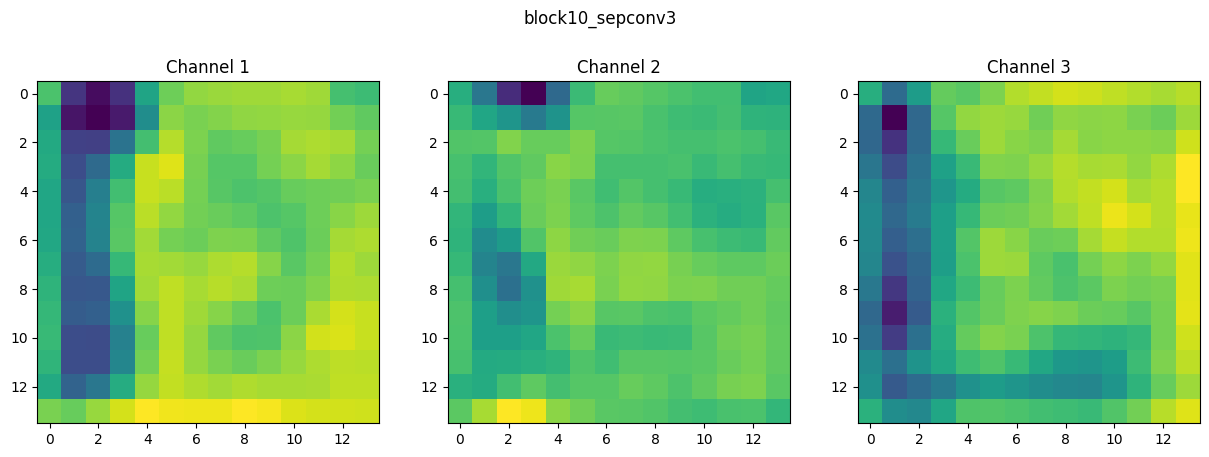

block10_sepconv3_bn (1, 14, 14, 728)


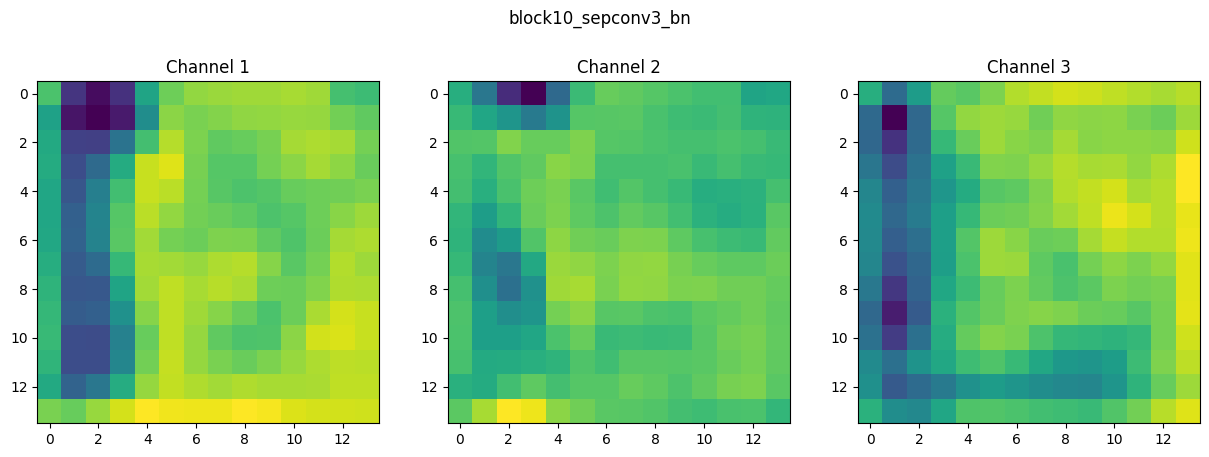

add_8 (1, 14, 14, 728)


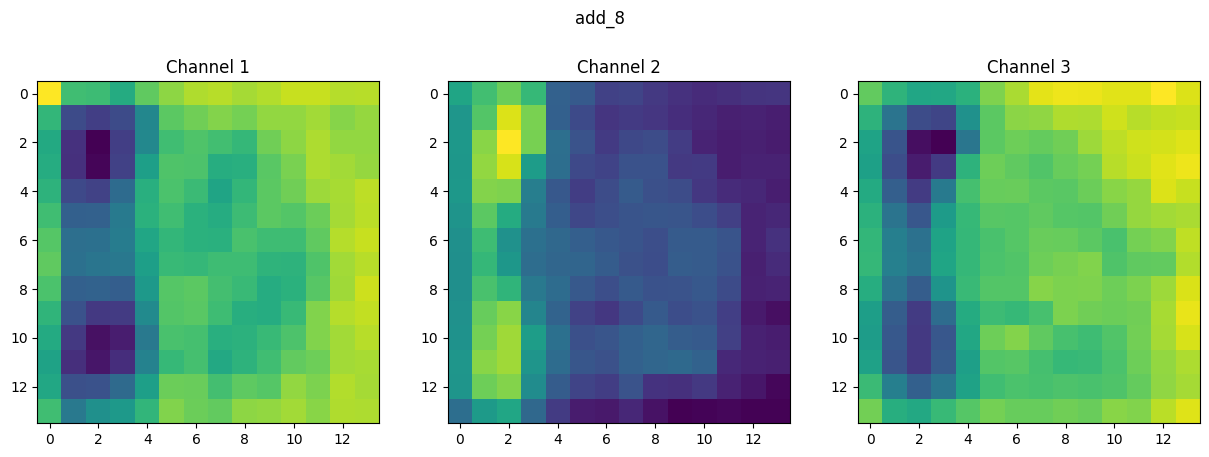

block11_sepconv1_act (1, 14, 14, 728)


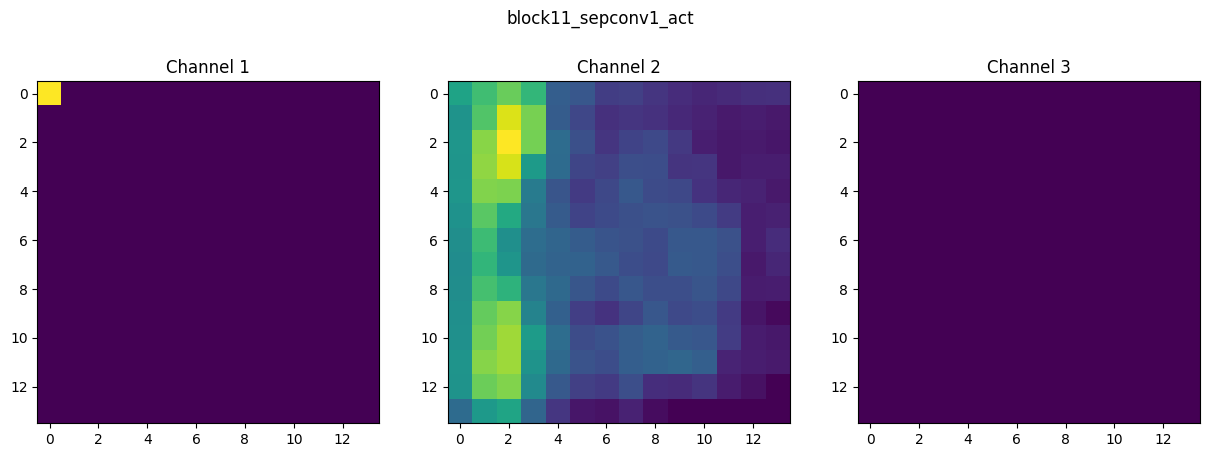

block11_sepconv1 (1, 14, 14, 728)


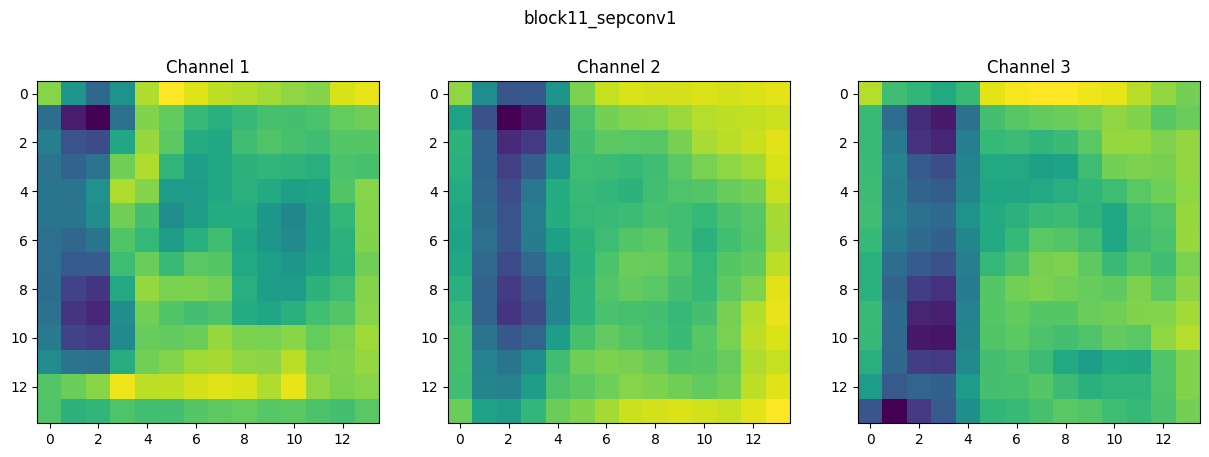

block11_sepconv1_bn (1, 14, 14, 728)


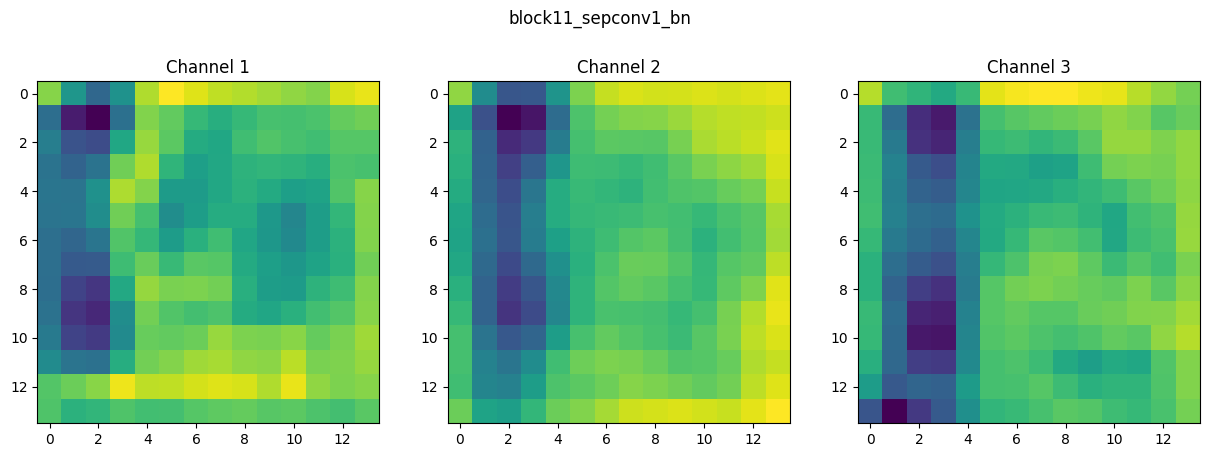

block11_sepconv2_act (1, 14, 14, 728)


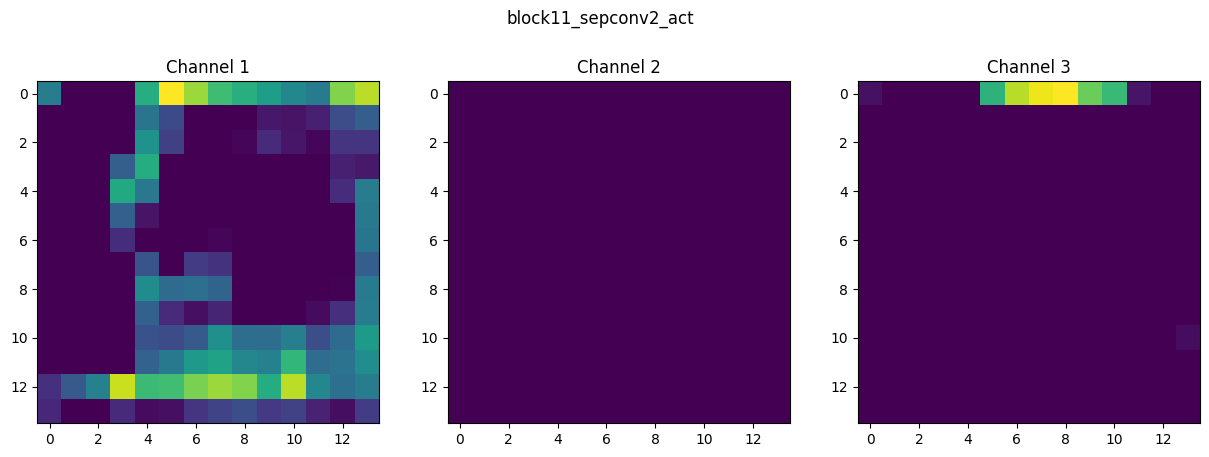

block11_sepconv2 (1, 14, 14, 728)


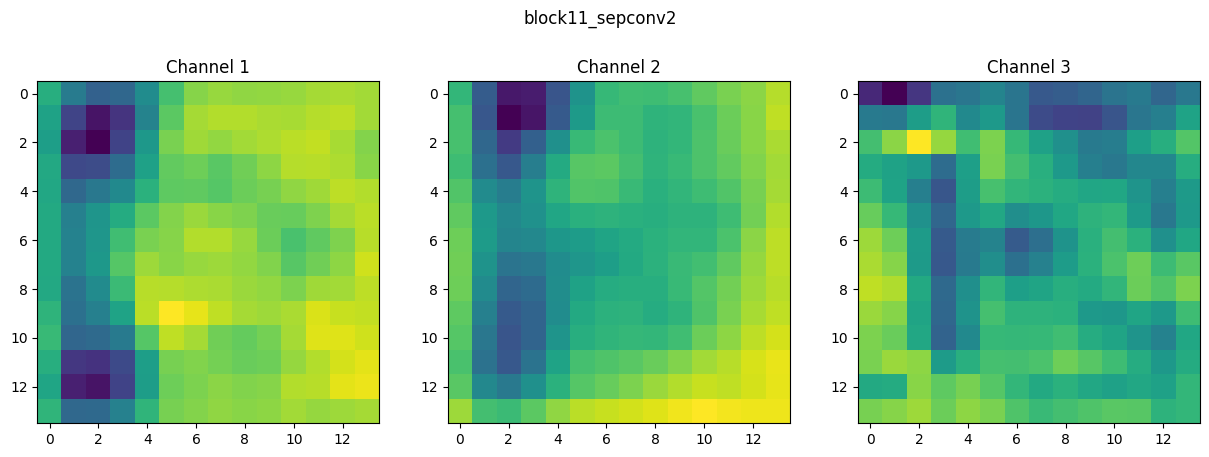

block11_sepconv2_bn (1, 14, 14, 728)


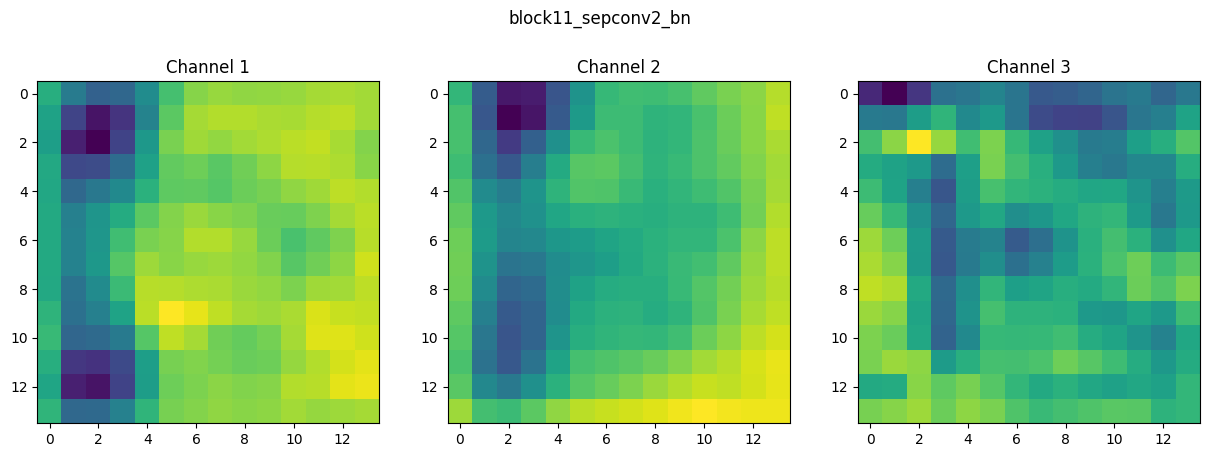

block11_sepconv3_act (1, 14, 14, 728)


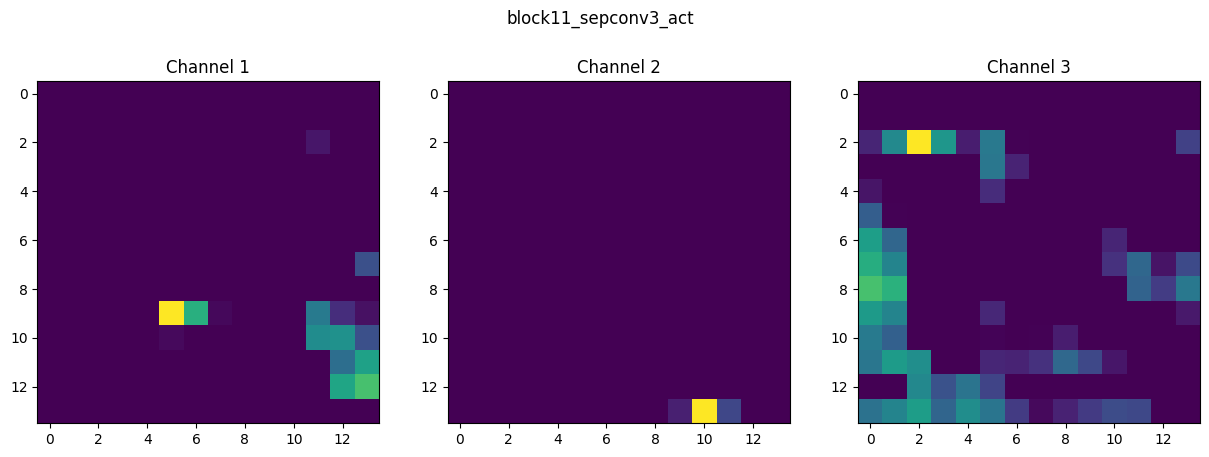

block11_sepconv3 (1, 14, 14, 728)


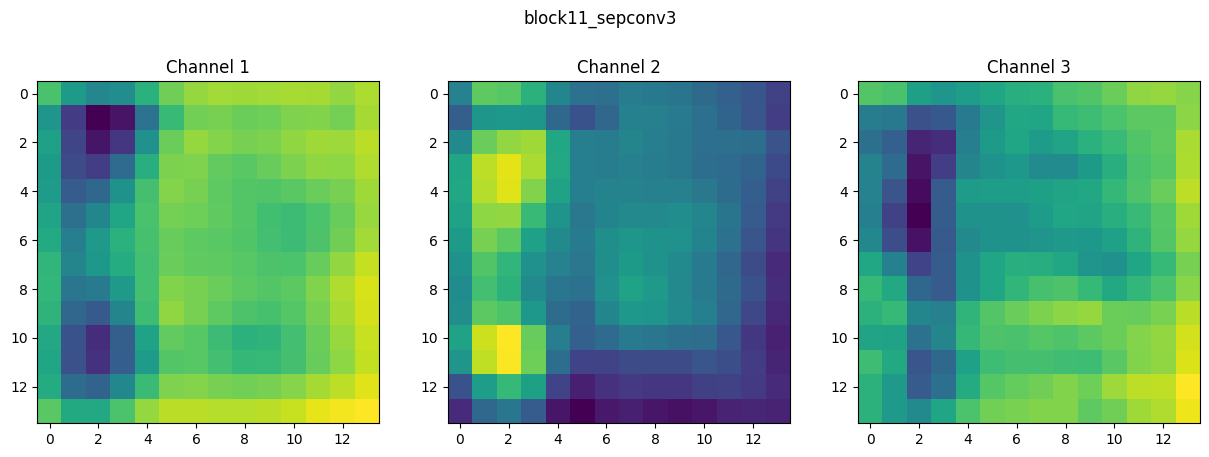

block11_sepconv3_bn (1, 14, 14, 728)


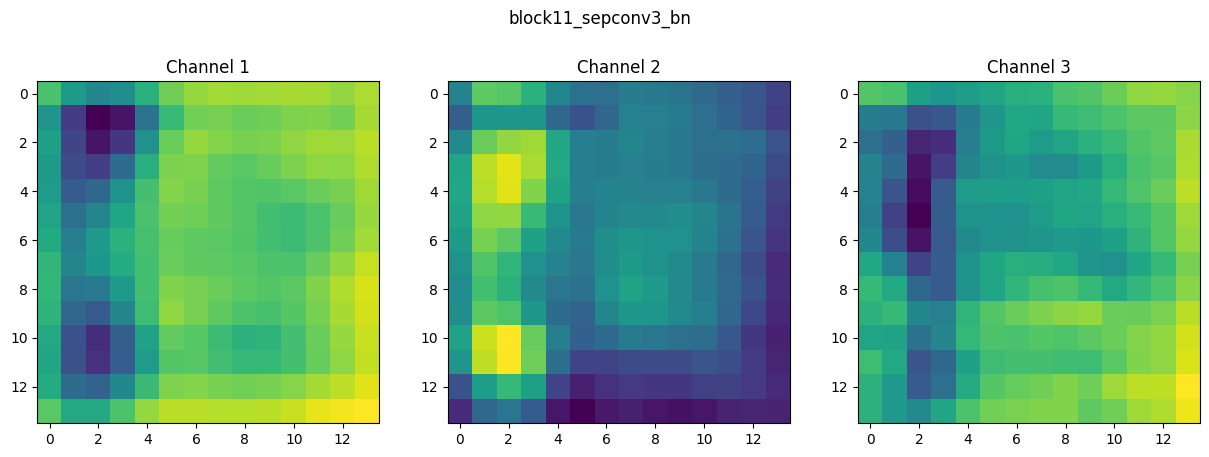

add_9 (1, 14, 14, 728)


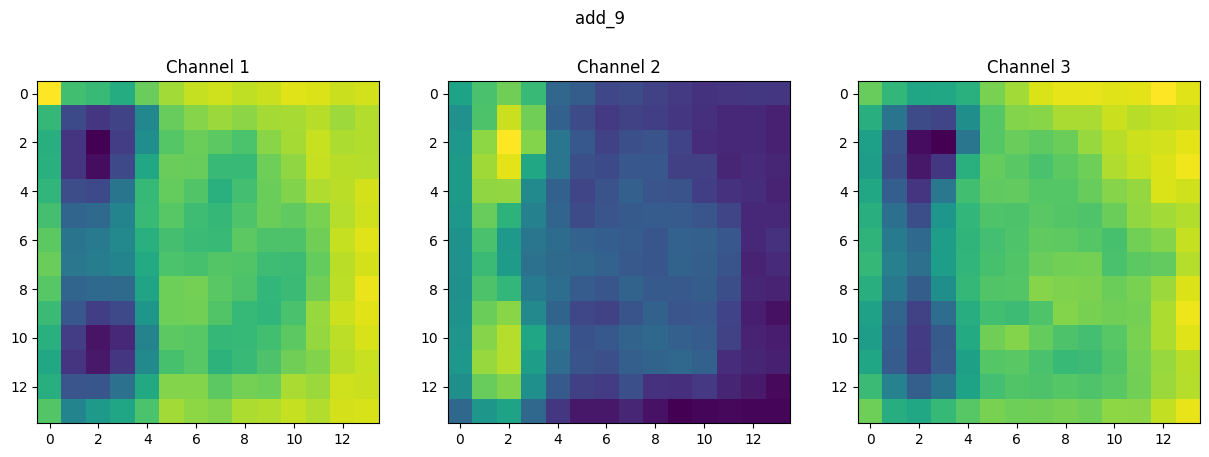

block12_sepconv1_act (1, 14, 14, 728)


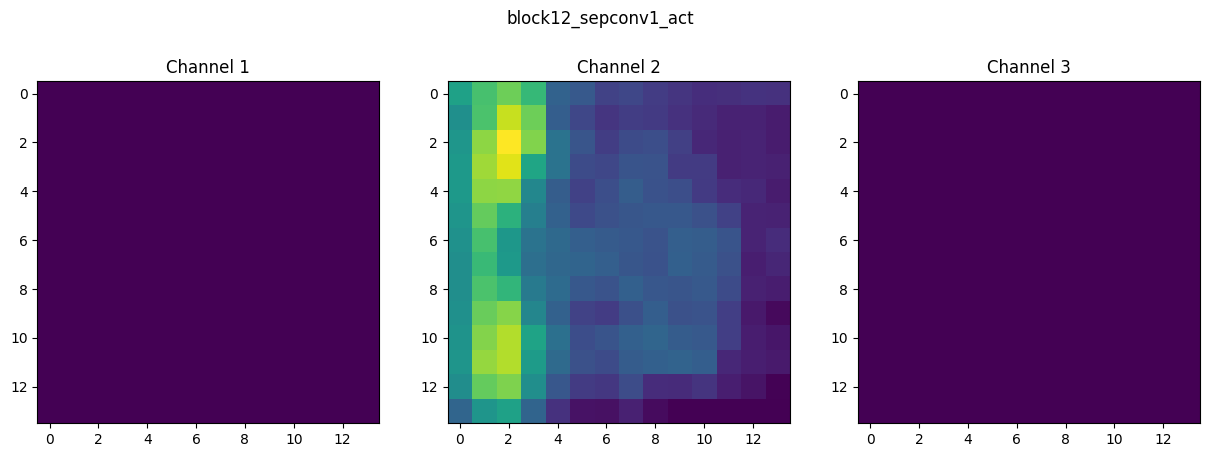

block12_sepconv1 (1, 14, 14, 728)


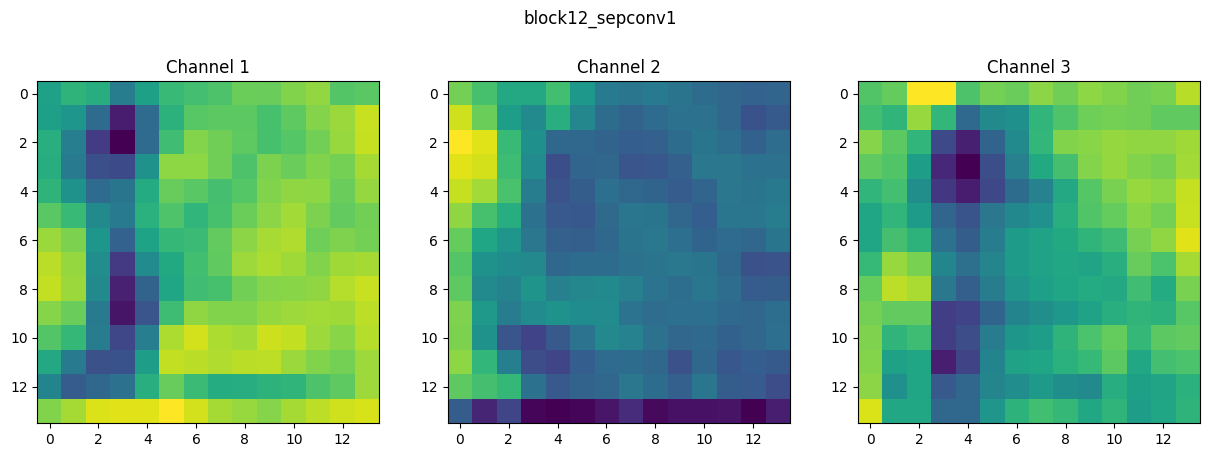

block12_sepconv1_bn (1, 14, 14, 728)


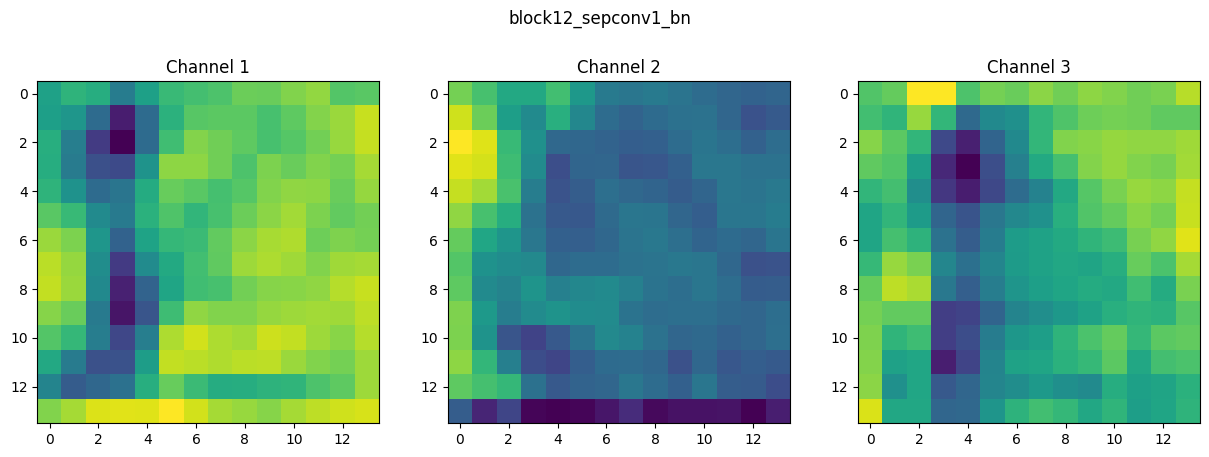

block12_sepconv2_act (1, 14, 14, 728)


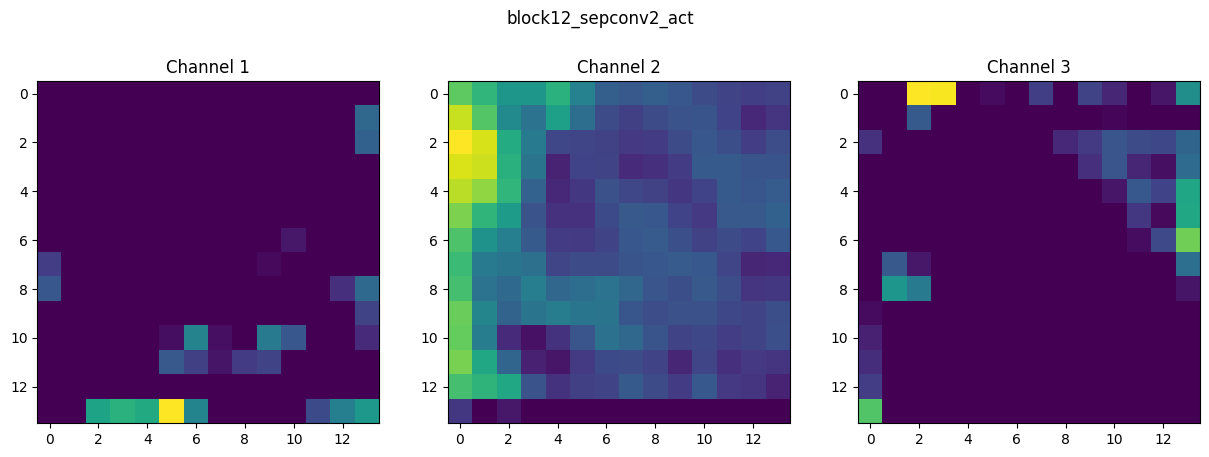

block12_sepconv2 (1, 14, 14, 728)


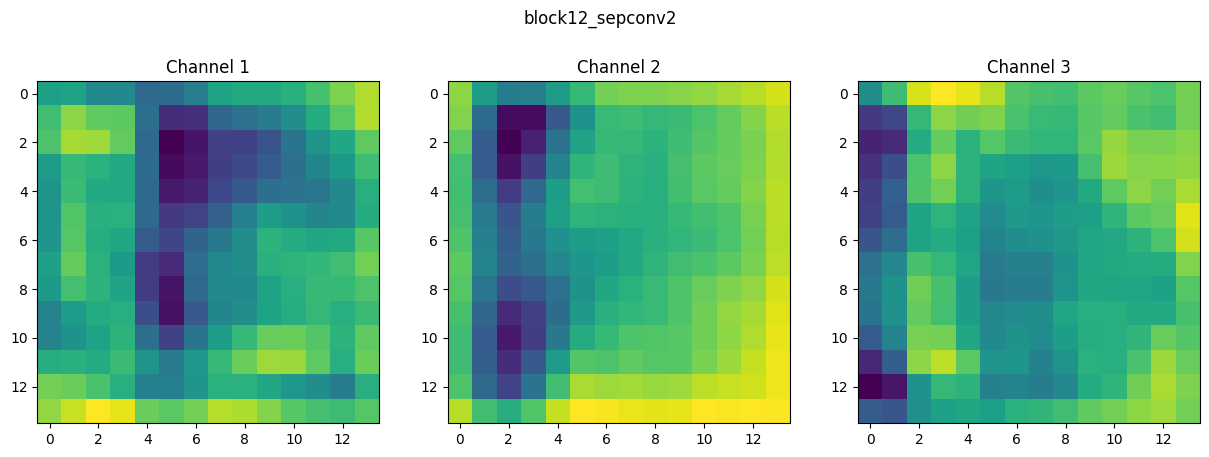

block12_sepconv2_bn (1, 14, 14, 728)


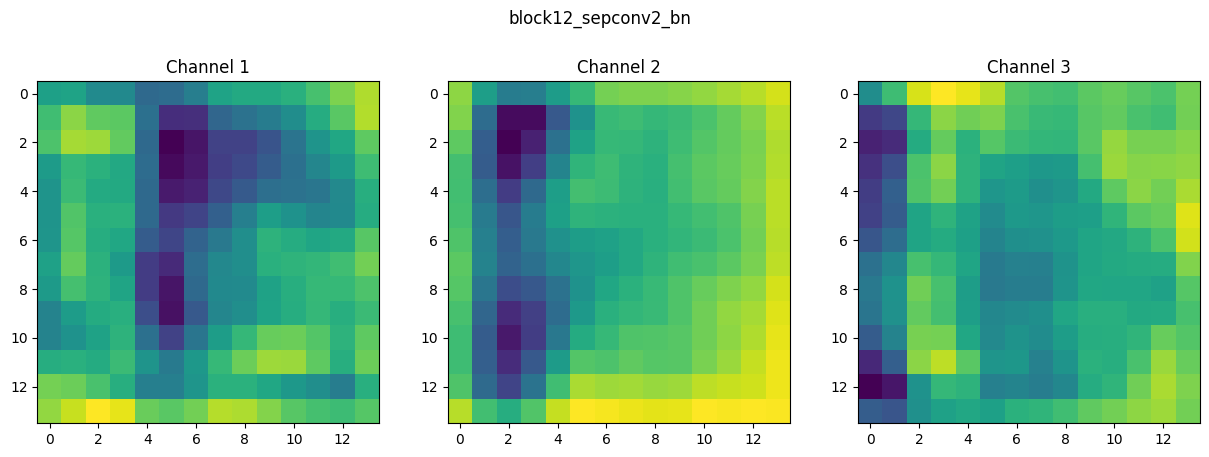

block12_sepconv3_act (1, 14, 14, 728)


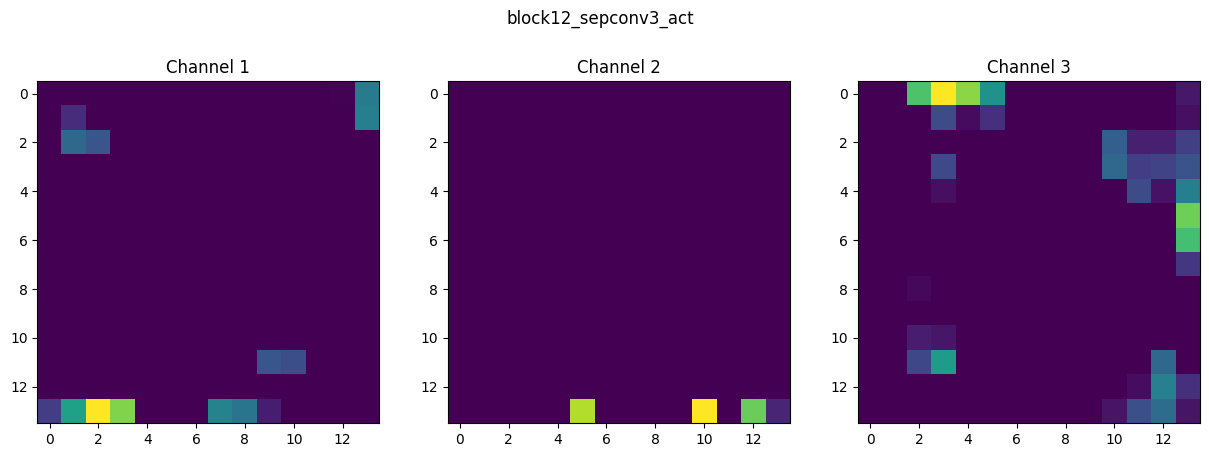

block12_sepconv3 (1, 14, 14, 728)


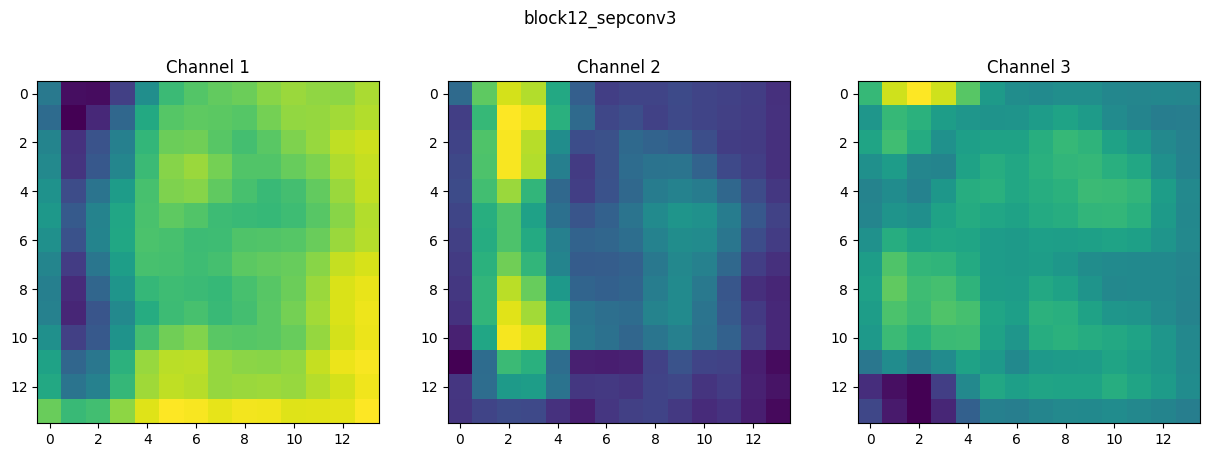

block12_sepconv3_bn (1, 14, 14, 728)


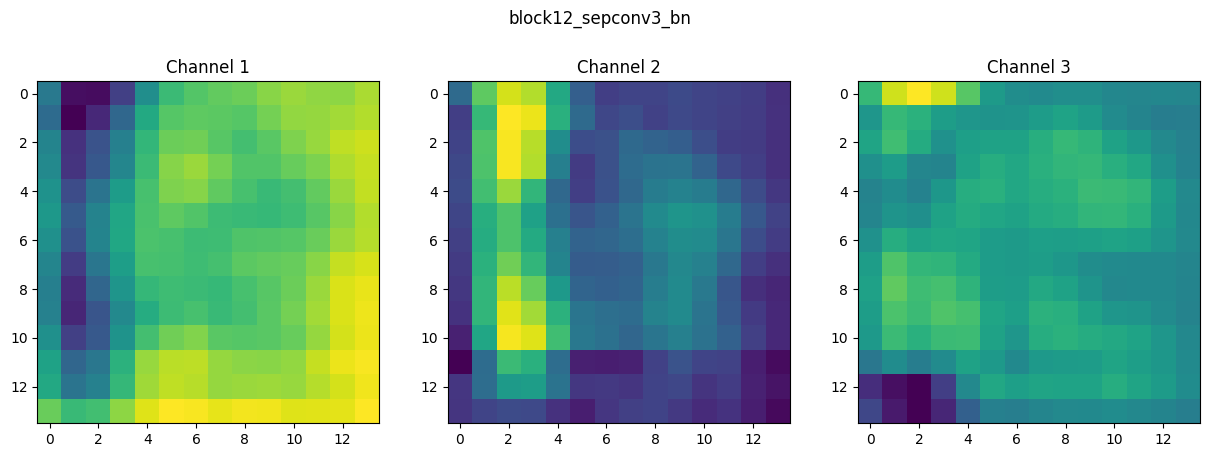

add_10 (1, 14, 14, 728)


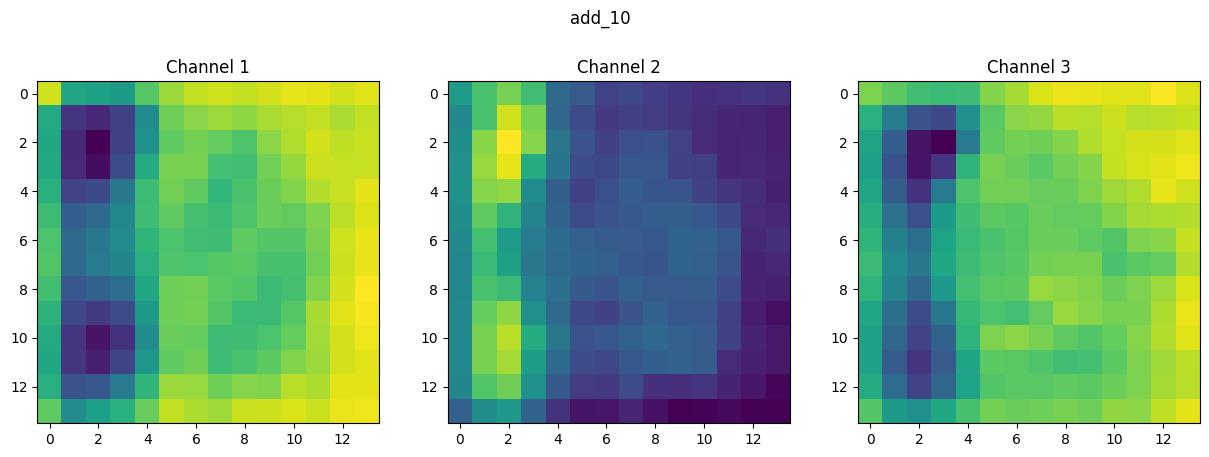

block13_sepconv1_act (1, 14, 14, 728)


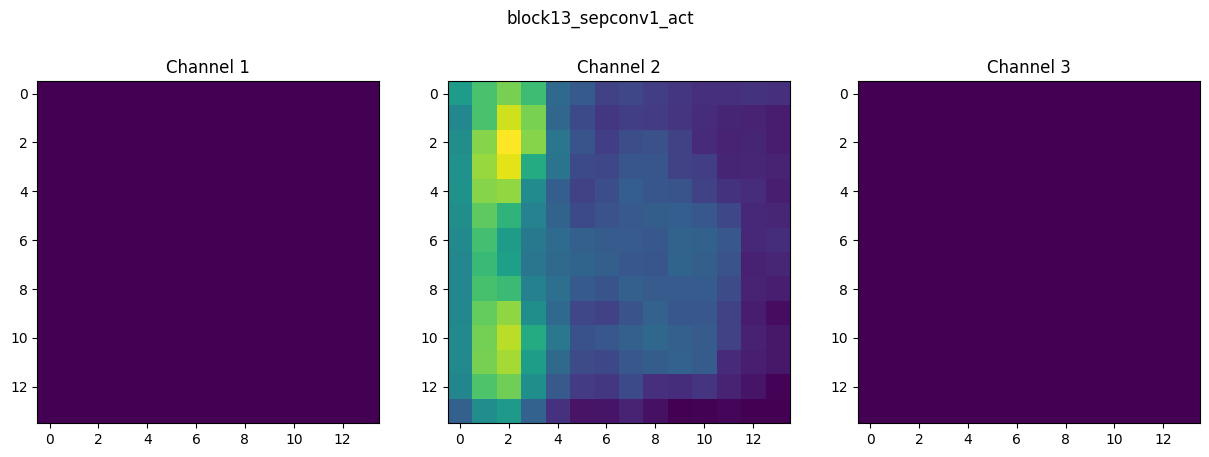

block13_sepconv1 (1, 14, 14, 728)


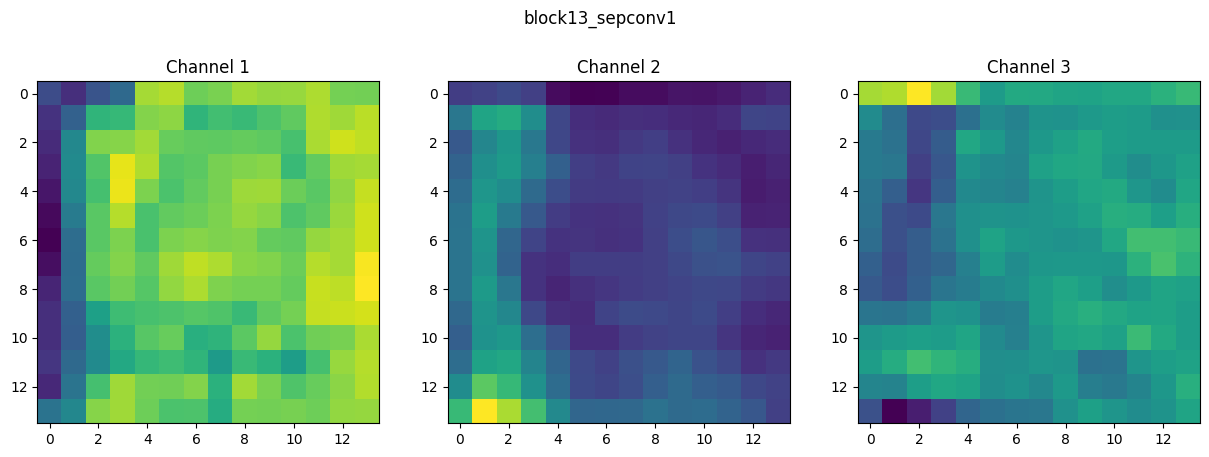

block13_sepconv1_bn (1, 14, 14, 728)


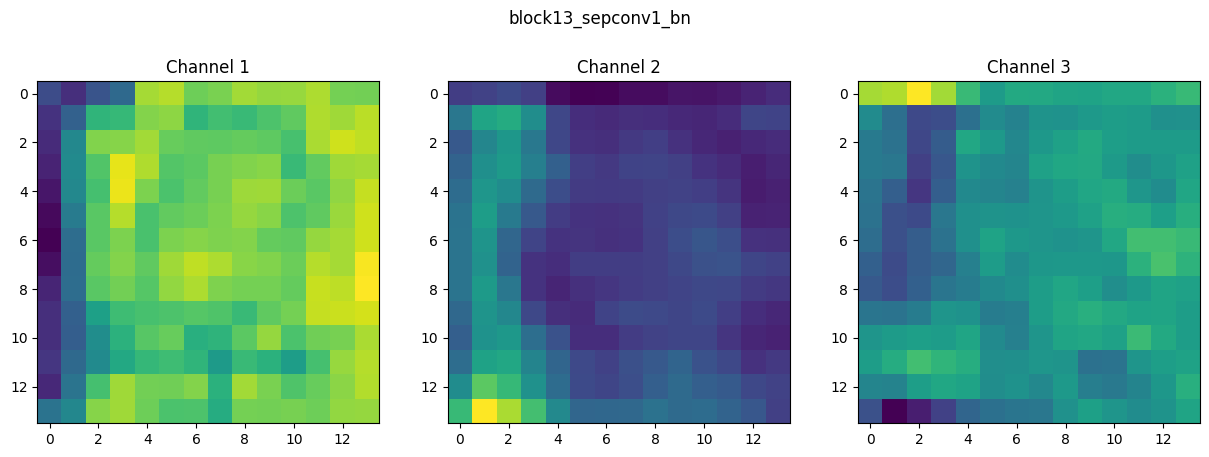

block13_sepconv2_act (1, 14, 14, 728)


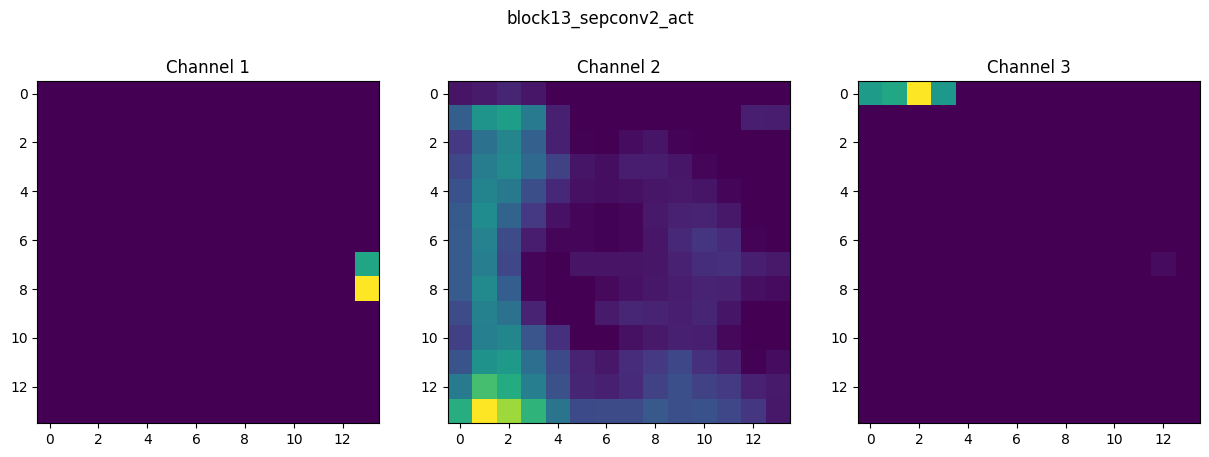

block13_sepconv2 (1, 14, 14, 1024)


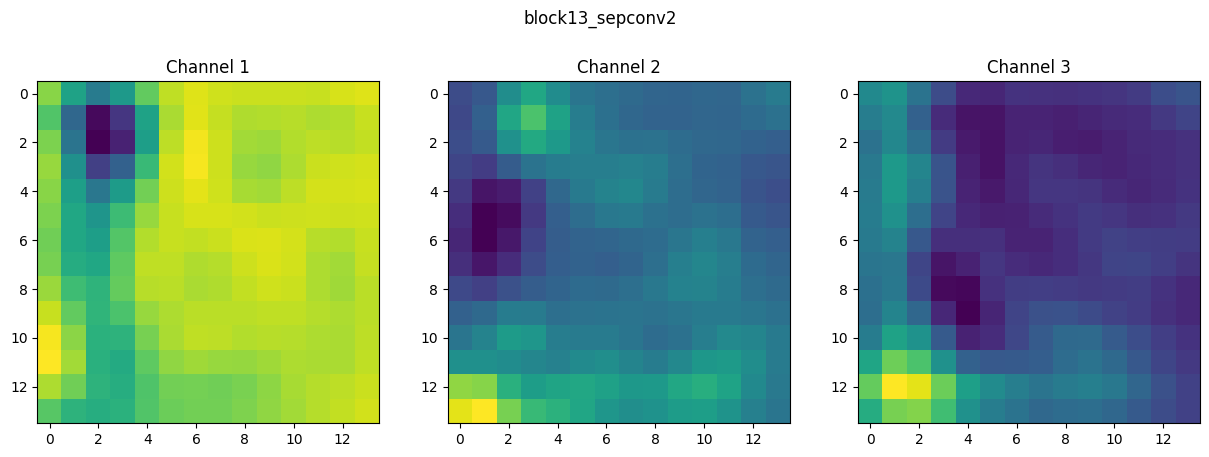

block13_sepconv2_bn (1, 14, 14, 1024)


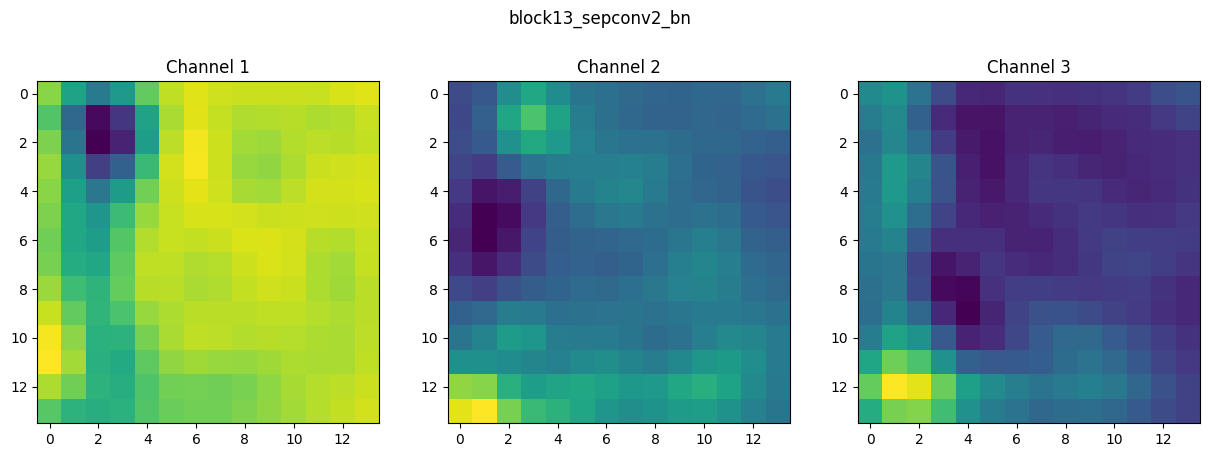

conv2d_3 (1, 7, 7, 1024)


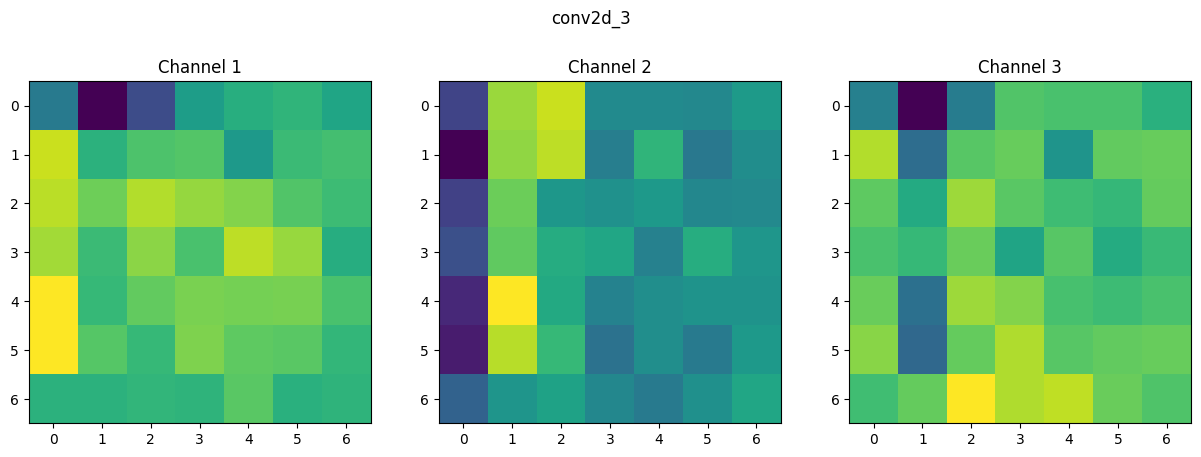

block13_pool (1, 7, 7, 1024)


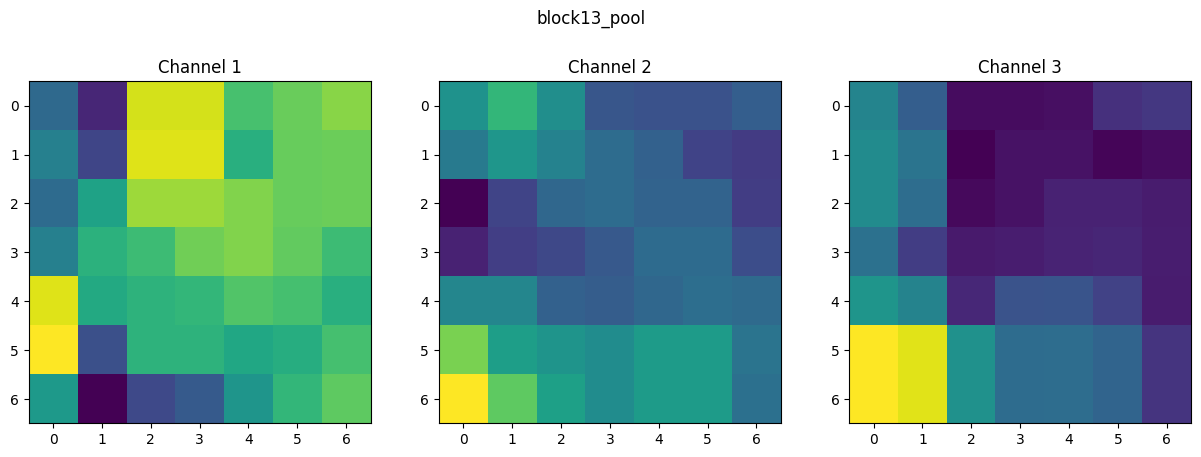

batch_normalization_3 (1, 7, 7, 1024)


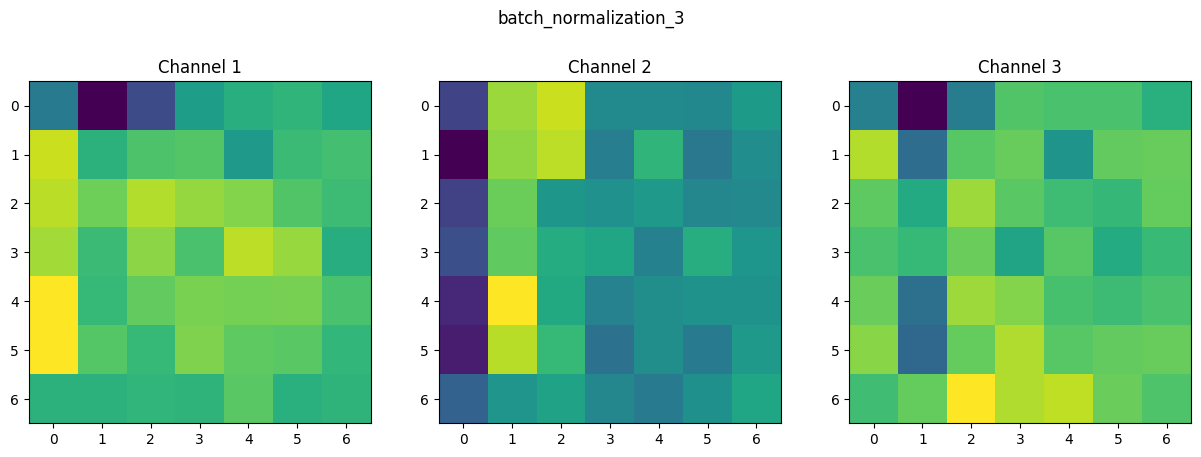

add_11 (1, 7, 7, 1024)


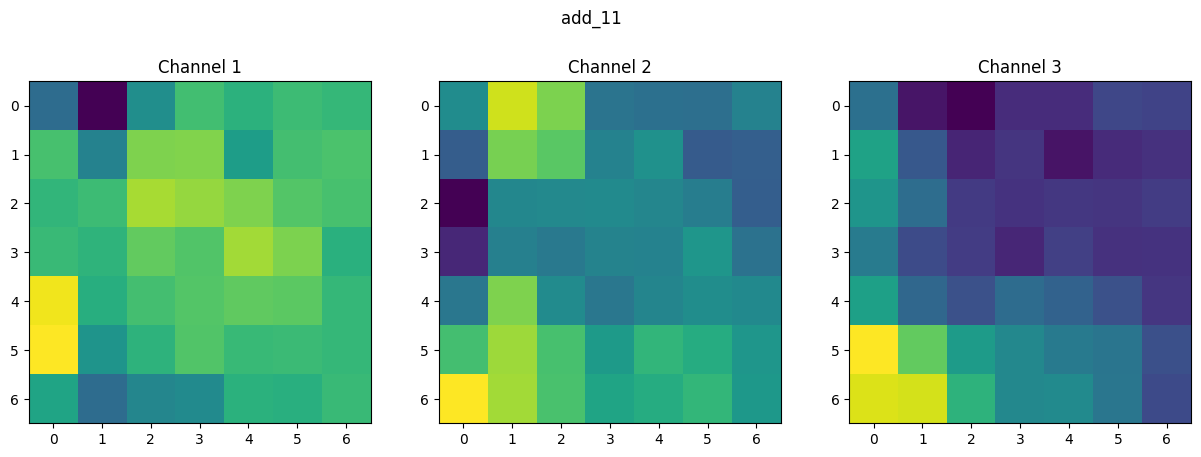

block14_sepconv1 (1, 7, 7, 1536)


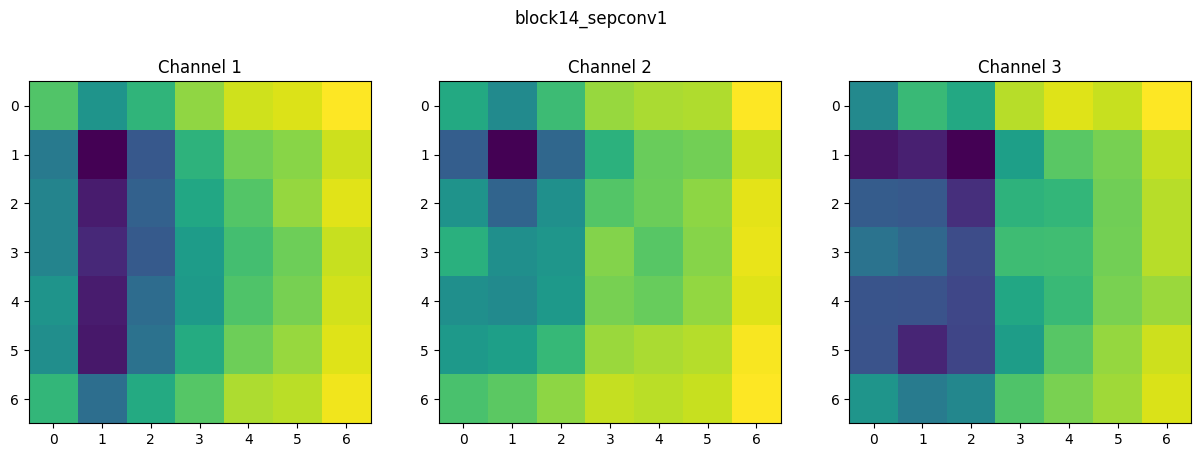

block14_sepconv1_bn (1, 7, 7, 1536)


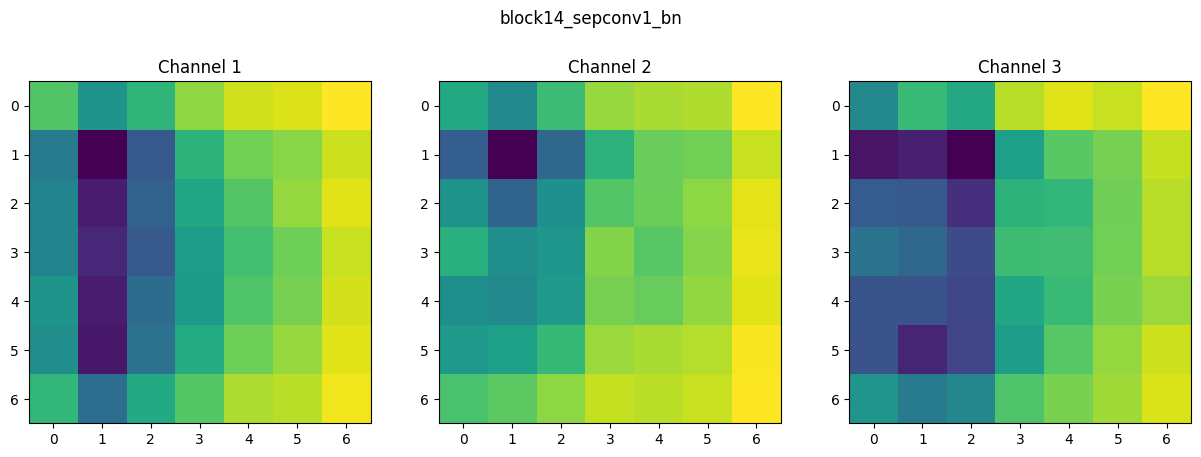

block14_sepconv1_act (1, 7, 7, 1536)


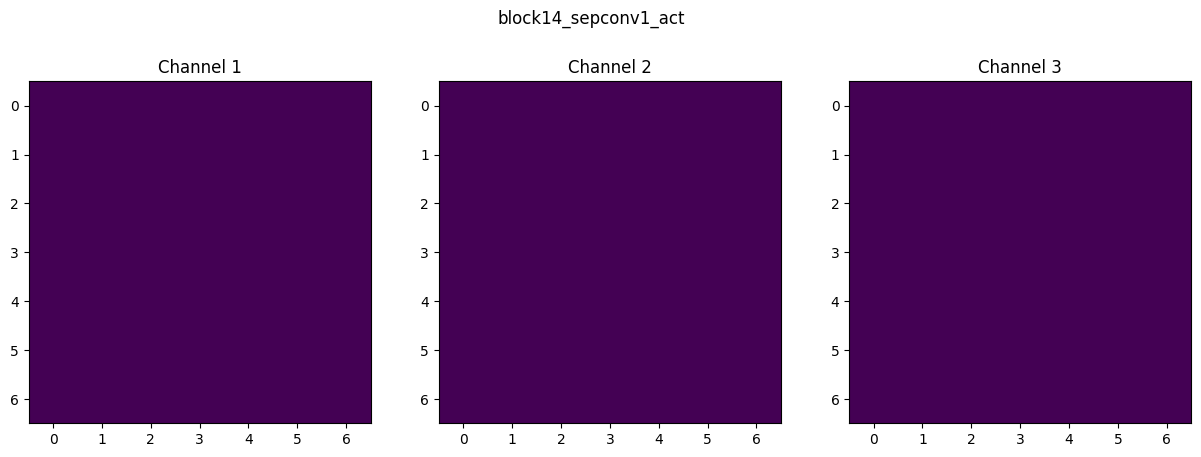

block14_sepconv2 (1, 7, 7, 2048)


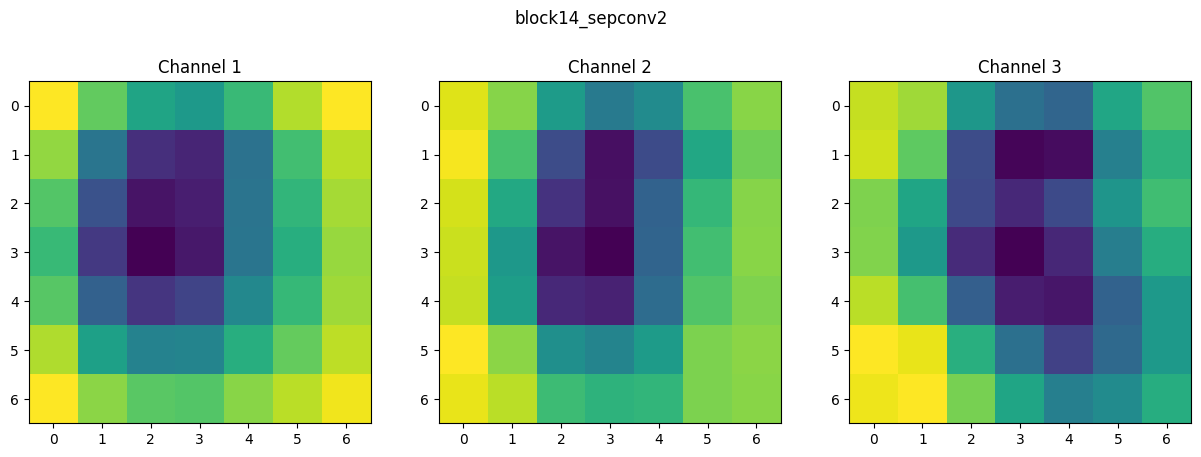

block14_sepconv2_bn (1, 7, 7, 2048)


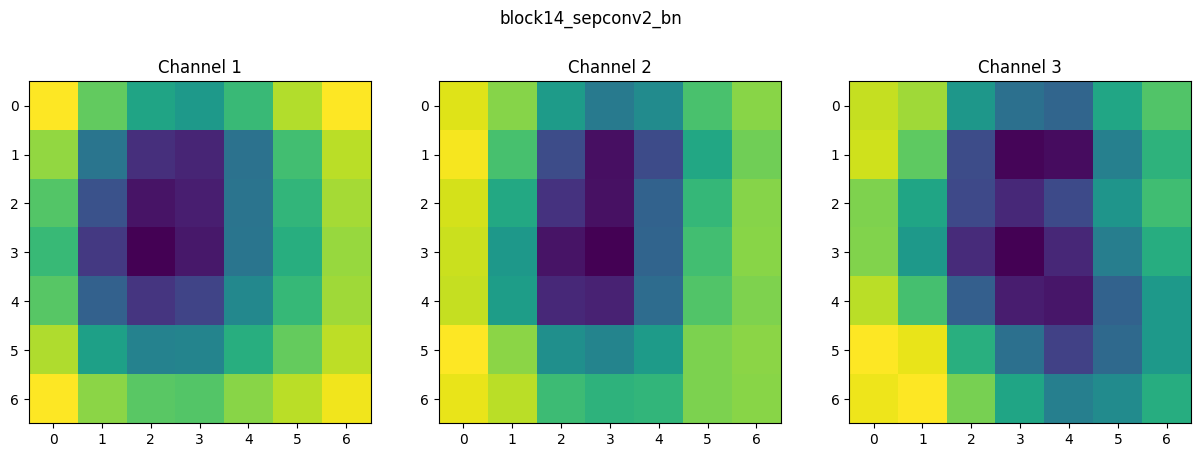

block14_sepconv2_act (1, 7, 7, 2048)


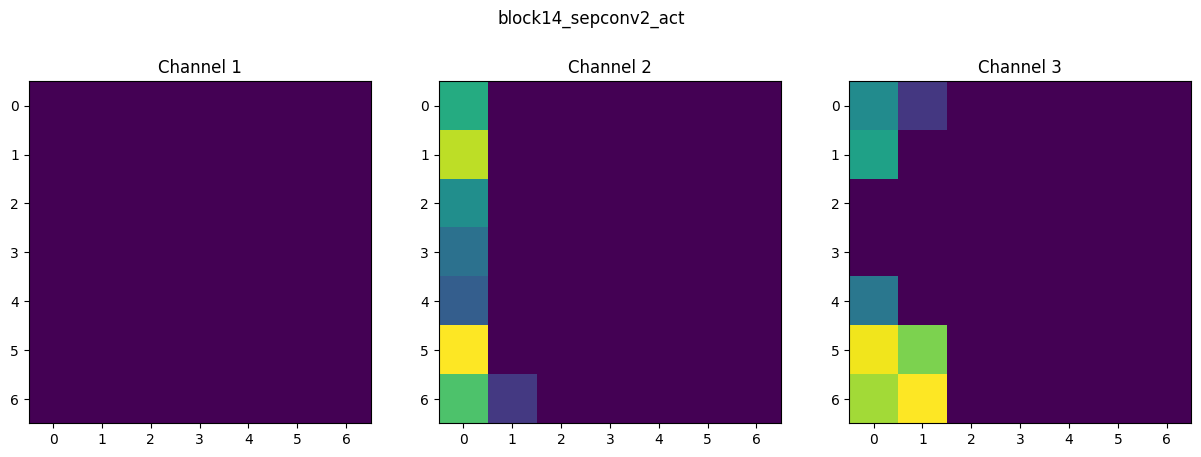

global_average_pooling2d (1, 2048)
dense (1, 256)
dense_1 (1, 55)


In [45]:
import matplotlib.pyplot as plt

# Assuming `activation_model` is already defined as in your code
layer_outputs = [layer.output for layer in xception_model.layers]
activation_model = Model(inputs=xception_model.input, outputs=layer_outputs)

# Assuming `sample_image` is already defined as in your code
activations = activation_model.predict(sample_image)

# Display activations
num_images_per_row = 3
for layer_name, activation in zip(xception_model.layers, activations):
    print(layer_name.name, activation.shape)
    if len(activation.shape) == 4:  # Check if the activation is of shape (batch_size, height, width, channels)
        num_channels = activation.shape[-1]
        num_images = min(num_images_per_row, num_channels)
        images_per_row = num_images_per_row if num_channels > num_images_per_row else num_channels
        fig, axes = plt.subplots(1, images_per_row, figsize=(15, 5))
        for i in range(num_images):
            axes[i].imshow(activation[0, :, :, i], cmap='viridis')
            axes[i].set_title(f'Channel {i+1}')
        plt.suptitle(layer_name.name)
        plt.show()


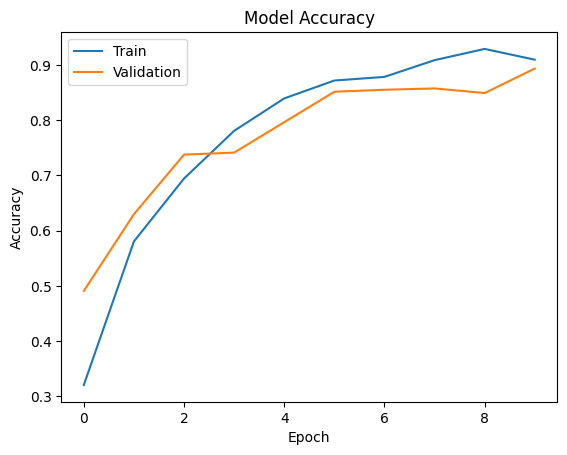

In [48]:
import matplotlib.pyplot as plt

# Assuming you have the `history` object from model training

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


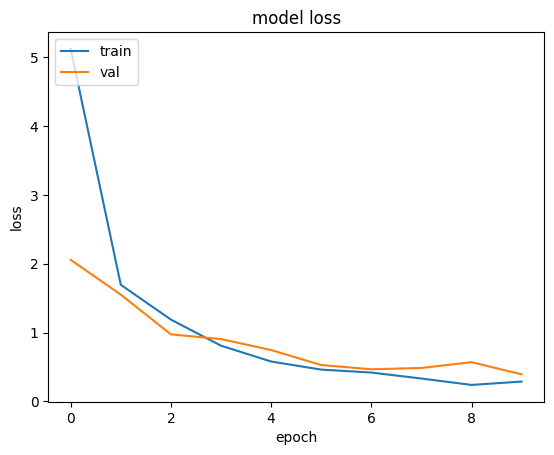

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

27/27 [==============================] - 177s 6s/step


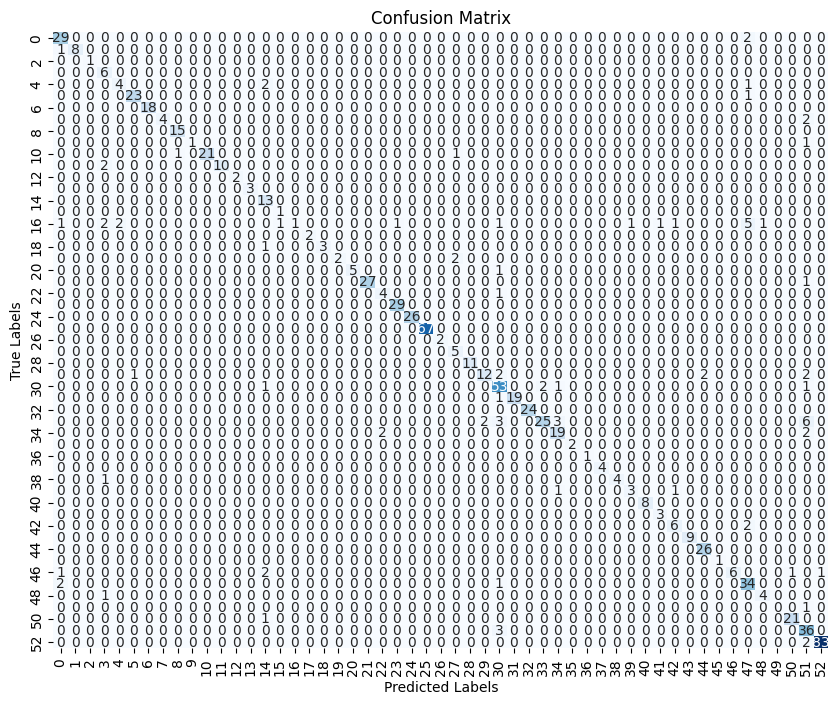

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        31
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00         1
           3       0.50      1.00      0.67         6
           4       0.67      0.57      0.62         7
           5       0.96      0.96      0.96        24
           6       1.00      1.00      1.00        18
           7       1.00      0.67      0.80         6
           8       0.94      1.00      0.97        15
          10       1.00      0.50      0.67         2
          11       1.00      0.91      0.95        23
          12       1.00      0.83      0.91        12
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         3
          16       0.65      1.00      0.79        13
          17       0.50      1.00      0.67         1
          18       1.00      0.06      0.11        18
          19       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = xception_model.predict(X_test_resized)

y_pred_labels = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test_encoded, y_pred_labels))

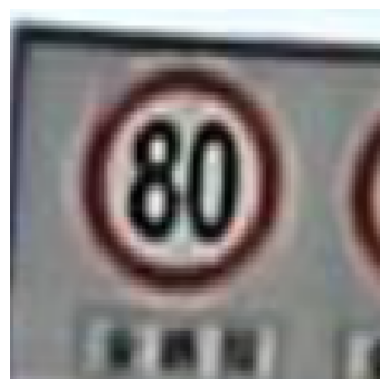

1/1 [==============================] - 1s 576ms/step
Predicted Label: speed limit (80km/h)


In [53]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load an image
img_path = '/content/drive/MyDrive/DL/traffic_Data/TEST/007_1_0024_1_j.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Make predictions
predictions = xception_model.predict(img_array)
predicted_label = np.argmax(predictions)

# Decode the predicted label
predicted_label = label_encoder.inverse_transform([predicted_label])[0]

print("Predicted Label:", predicted_label)
